## «Модель прогнозирования стоимости жилья для агентства недвижимости»

### 1. Знакомство с данными.

In [7]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import re
import optuna
import xgboost as xgb
from catboost import CatBoostRegressor
from statsmodels.graphics.gofplots import qqplot
import squarify
from statistics import mean
import pickle
from sklearn.pipeline import Pipeline

In [8]:
# загружаем данные
data = pd.read_csv('data/data_real_property.csv')
data.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак).

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [10]:
data.describe()

status private pool        propertyType                 street  \
count     337267         4181              342452                 377183   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156104         4181               92206                    672   

          baths                                          homeFacts fireplace  \
count    270847                                             377185    103114   
unique      229                                             321009      1652   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52466                                               7174     50356   

           city                                            schools    sqft  \
count    377151                                             377185  336608   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24442                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377185  285903  377185  226469    24942       40311  310305    374704  
unique    4549    1184      39     347    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53459  115449   67454        3       28793      24      1462

В представленном датасете данные о  блее чем 300 000 объектов недвижимости и 18 их характеристик, все признаки имеют тип данных object. 

### 2. Очистка данных - обработка пропусков и дубликатов.

Признаки MlsId и mls-id являются идентификаторами, которые никак не влияют на цену недвижимости, удалим их.

In [11]:
data = data.drop(['MlsId', 'mls-id'], axis = 1)

Посмотрим на наличие пропусков в данных.

In [12]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

private pool    98.891525
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64


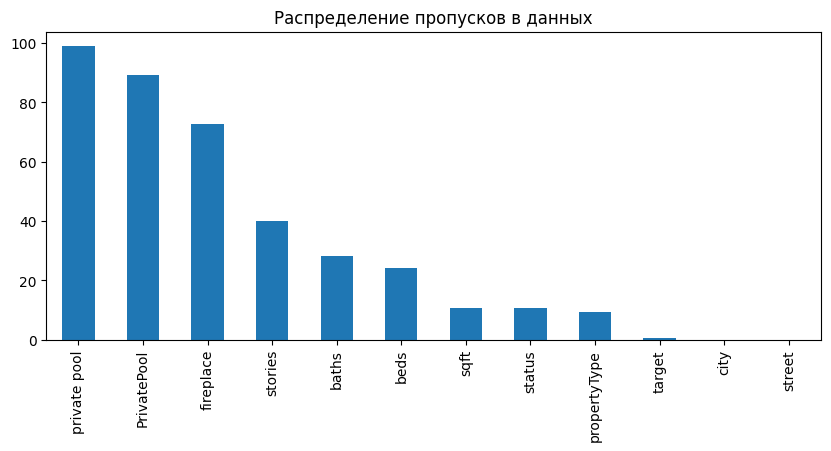

In [13]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

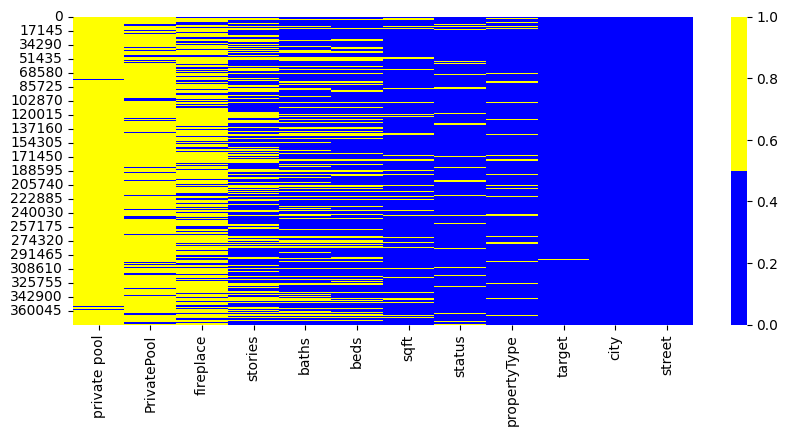

In [14]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

Очевидно, что три признака - private pool, PrivatePool, fireplace - имеют очень большое количество пропусков (более 70%). Кроме того, признаки private pool и PrivatePool несут одинаковую информацию о наличии бассейна, но даже объединив эти данные, доля пропусков все равно будет велика и их замена может исказить данные. Поэтмоу, несмотря на то, что наличие бассейна или камина могут оказывать влияние на стоимость недвижимости, эти данные придется удалить, так как восстановить их не представляется возможным.

In [15]:
# удалим все столбцы с пропусками более 40%
data = data.dropna(thresh=data.shape[0]*0.6, axis=1)

In [16]:
# найдем и удалим дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
sber_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Число найденных дубликатов: 141
Результирующее число записей: 377044


Проверим данные на неинформативные признаки, которые не играют роли при моделировании и лишь засоряют таблицу, увеличивая объем данных. Найдем признаки, в которых:
- 95% строк содержат одинаковые значения
- 95% строк содержат уникальные значения 

In [17]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
    else:
        print(f'{col} не является неинформативным признаком')

status не является неинформативным признаком
propertyType не является неинформативным признаком
street не является неинформативным признаком
baths не является неинформативным признаком
homeFacts не является неинформативным признаком
city не является неинформативным признаком
schools не является неинформативным признаком
sqft не является неинформативным признаком
zipcode не является неинформативным признаком
beds не является неинформативным признаком
state не является неинформативным признаком
stories не является неинформативным признаком
target не является неинформативным признаком


### 3. Преобразование данных и EDA.

Исследуем и преобразуем каждый признак.

Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении стимости недвижимости.

#### 3.1 Целевой признак - target.

In [18]:
# выведем статистику
data['target'].describe()

count       374704
unique       43939
top       $225,000
freq          1462
Name: target, dtype: object

In [19]:
# посмотрим на распределение
data['target'].value_counts().nlargest(15)

target
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
$375,000    1163
$450,000    1141
$499,000    1099
$175,000    1096
$425,000    1075
Name: count, dtype: int64

Признак имеет большое количество уникальных значение, что неудивительно, так как цена всегда индивидуальна для каждого объекта. 

- Проверим признак на пропуски и удалим их, так как это целевой признак, а значит строк с пропусками в нем быть не должно. 
- Проверим признак на специфические данные (возможно есть данные, не отвечающие сути признака)
- Переведем признак в тип данных float.
- Проверим и избавимся, если нужно от выбросов.

In [20]:
data['target'].isnull().mean()*100

0.6577674085660883

In [21]:
data = data.dropna(subset=['target'])

In [22]:
data[data.target.str.contains('/mo',regex=True)]

status        propertyType                   street      baths  \
547     for rent  single-family home  4323 N Central Park Ave  3.5 Baths   
609     for rent        multi-family    220 Boylston St #1412    2 Baths   
2075    for rent  single-family home          2830 NE 56th Ct    4 Baths   
3025    for rent        multi-family            411 Kline Aly  2.5 Baths   
3645    for rent        multi-family  240 E Illinois St #2011    2 Baths   
...          ...                 ...                      ...        ...   
371791  for rent        multi-family       9436 Turrentine Dr  1.5 Baths   
372459  for rent           townhouse            34 Jonquil Pl  2.5 Baths   
374288  for rent  single-family home       8864 Devonshire Dr    2 Baths   
375550  for rent           townhouse        2217 W Seybert St        NaN   
376976  for rent  single-family home      3819 Alabama Ave NE    2 Baths   

                                                homeFacts              city  \
547     {'atAGlanceFacts': [{'factValue': '1913', 'fac...           Chicago   
609     {'atAGlanceFacts': [{'factValue': '1985', 'fac...            Boston   
2075    {'atAGlanceFacts': [{'factValue': '1965', 'fac...   Fort Lauderdale   
3025    {'atAGlanceFacts': [{'factValue': '2014', 'fac...       Clarksville   
3645    {'atAGlanceFacts': [{'factValue': '2003', 'fac...           Chicago   
...                                                   ...               ...   
371791  {'atAGlanceFacts': [{'factValue': '', 'factLab...           El Paso   
372459  {'atAGlanceFacts': [{'factValue': '2014', 'fac...     The Woodlands   
374288  {'atAGlanceFacts': [{'factValue': '2016', 'fac...        Fort Worth   
375550  {'atAGlanceFacts': [{'factValue': '1920', 'fac...      Philadelphia   
376976  {'atAGlanceFacts': [{'factValue': '1961', 'fac...  Saint Petersburg   

                                                  schools        sqft zipcode  \
547     [{'rating': ['1/10', '4/10', '2/10', 'None/10'...  3,300 sqft   60618   
609     [{'rating': [], 'data': {'Distance': [], 'Grad...  1,673 sqft    2116   
2075    [{'rating': ['6/10', '2/10', '4/10'], 'data': ...  2,400 sqft   33308   
3025    [{'rating': ['8/10', '9/10', '7/10'], 'data': ...  1,280 sqft   37040   
3645    [{'rating': ['4/10', '7/10'], 'data': {'Distan...  1,473 sqft   60611   
...                                                   ...         ...     ...   
371791  [{'rating': ['4/10', '8/10', '6/10'], 'data': ...  1,050 sqft   79925   
372459  [{'rating': ['5/10', '8/10', '7/10', '8/10'], ...  2,601 sqft   77375   
374288  [{'rating': ['6/10', '5/10', '5/10'], 'data': ...  2,000 sqft   76131   
375550  [{'rating': ['1/10', '3/10'], 'data': {'Distan...    720 sqft   19121   
376976  [{'rating': ['2/10', '5/10', '4/10'], 'data': ...  1,304 sqft   33703   

          beds state stories      target  
547     4 Beds    IL     NaN   $5,500/mo  
609     2 Beds    MA     NaN  $10,500/mo  
2075    4 Beds    FL     NaN   $6,390/mo  
3025    2 Beds    TN     NaN   $1,200/mo  
3645    2 Beds    IL     NaN   $3,600/mo  
...        ...   ...     ...         ...  
371791  2 Beds    TX     NaN     $890/mo  
372459  3 Beds    TX     NaN   $2,500/mo  
374288  4 Beds    TX     NaN   $2,000/mo  
375550  2 Beds    PA     NaN   $1,500/mo  
376976  3 Beds    FL     NaN   $1,900/mo  

[398 rows x 13 columns]

В данных есть объекты, предназначенные для аренды, они имеют стоимость за месяц. Такие данных нужно удалить, чтобы не было путаницы между продажей и арендой.

In [23]:
data = data.drop(data[data['status'] == 'for rent'].index)

In [24]:
# удалим ненужные символы и переведем в тип данных float
data['target'] = data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', '')).astype(float)

Text(0.5, 1.0, 'Целевой признак до удаления выбросов')

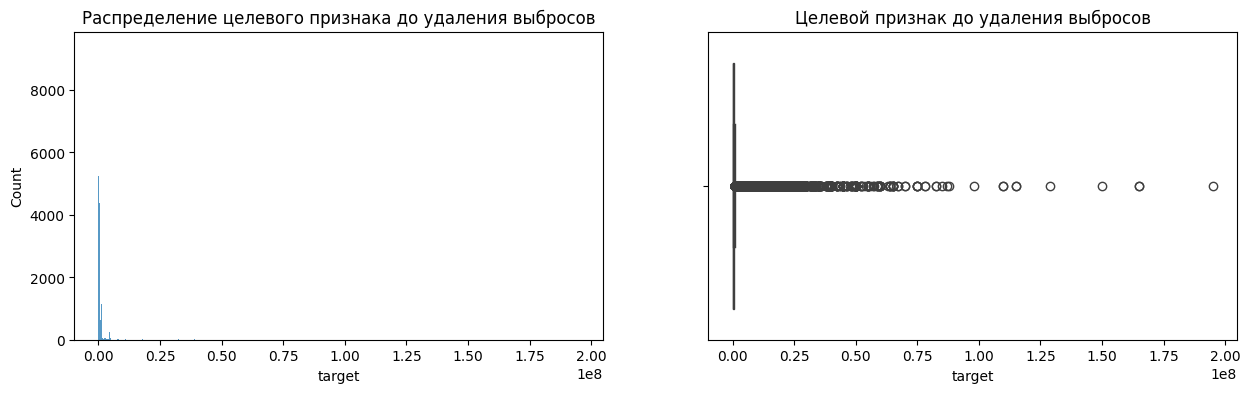

In [25]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак до удаления выбросов')

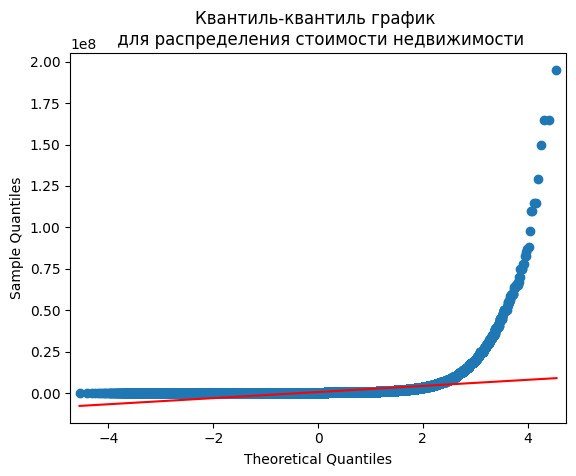

In [26]:
qqplot(data.target, line='s')
plt.title('Квантиль-квантиль график \n для распределения стоимости недвижимости')
plt.show()

Визуально распределение целевого признака не выглядит нормально. Проверим эту гипотезу с помощью статистического теста Д’Агостино (так как данных более 5000). 

H0 = 'Данные распределены нормально'

H1 = 'Данные не распределены нормально (мы отклоняем H0)'

Значение альфа - 0.5

In [27]:
alpha=0.5
_,p = stats.normaltest(data['target'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [28]:
def outliers_z_score(data, feature, log_scale=False):
    """Функция для определения выбросов в данных по методу z-отклонений и их удалению

    Args:
        data (DataFrame): таблица с данными
        feature: признак
        log_scale: параметр, отвечающий за логарифмирование (по умолчанию False)

    Returns:
        outliers: найденные выбросы
        cleaned: очищенная от выбросов таблица
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [29]:
outliers, data = outliers_z_score(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 6112
Результирующее число записей: 368194


Text(0.5, 1.0, 'Целевой признак после удаления выбросов')

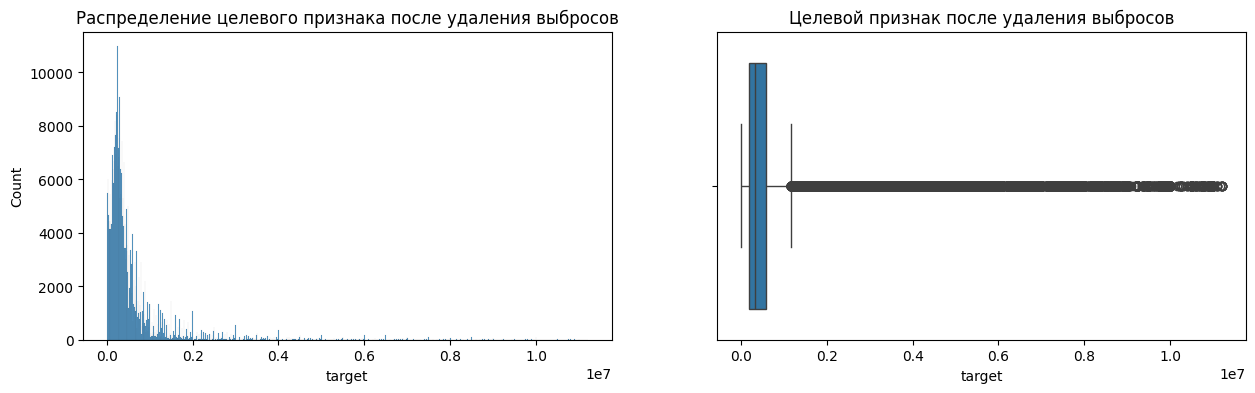

In [30]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак после удаления выбросов')

#### 3.2 Признак stories - количество этажей.

In [31]:
# выведем статистику
data['stories'].describe()

count     223369
unique       340
top          1.0
freq       66326
Name: stories, dtype: object

In [32]:
# посмотрим на распределение
data['stories'].value_counts().nlargest(15)

stories
1.0        66326
2.0        54599
1          22716
2          17869
3.0        11144
0.0         7153
One         5757
0           4204
3           4160
9.0         2905
2.00        2770
Two         2494
4.0         2111
2 Story     1970
1 Story     1253
Name: count, dtype: int64

In [33]:
# посмотрим уникальные значения
data['stories'].unique().tolist()

[nan,
 '2.0',
 '1.0',
 '3.0',
 'One',
 '2',
 'Multi/Split',
 '4.0',
 '0.0',
 '0',
 'One Level',
 '1',
 '9.0',
 '3',
 '1 Level, Site Built',
 'One Story',
 '3.00',
 '1.00',
 '14.0',
 'Two',
 '3+',
 '1 Story',
 '5.0',
 '2 Story',
 'Ranch/1 Story',
 'Condominium',
 'Stories/Levels',
 '7.0',
 '2 Level, Site Built',
 '2 Level',
 '15',
 '3 Level, Site Built',
 '4',
 '22.0',
 '2.00',
 '6.0',
 '1.0000',
 'Lot',
 '3 Story',
 'Three Or More',
 '1.5',
 '1 Level',
 'Two Story or More',
 'Site Built, Tri-Level',
 '54.0',
 '23',
 'Farm House',
 '8.0',
 '16.0',
 '1.50',
 '18',
 '9',
 '21',
 '8',
 '12.0',
 'Split Level w/ Sub',
 '11.0',
 '1.5 Stories',
 '7',
 '11',
 'Townhouse',
 '12',
 '21.0',
 '16',
 '1.5 Story/Basement',
 '28.0',
 'Traditional',
 '2.5 Story',
 '17',
 '2.0000',
 '63.0',
 'Acreage',
 'Ground Level, One',
 '6',
 'Split Foyer',
 '2 Stories',
 '27.0',
 '19.0',
 '2.50',
 '1.30',
 '2 Story/Basement',
 'Split Level',
 '1.5 Story',
 '1.5 Level',
 '2 Or More Stories',
 '1 Level, Condo, Site 

In [34]:
data['stories'].isnull().mean()*100

39.33388376779632

Значения у признака очень разные и очень многие не совсем понятные: например 3.5, 96, Multi Level, Two Story or More и т.д. Такие значения невозможно трактовать однозначно. Произвести какую-то градацию не представляется возможным, слишком много значений, которые будет сложно отнести к какой-то группе. Кроме того в признаке почти 40% пропусков, удалим этотм признак.

In [35]:
data = data.drop('stories', axis =1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368194 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        329228 non-null  object 
 1   propertyType  334587 non-null  object 
 2   street        368192 non-null  object 
 3   baths         266798 non-null  object 
 4   homeFacts     368194 non-null  object 
 5   city          368165 non-null  object 
 6   schools       368194 non-null  object 
 7   sqft          330605 non-null  object 
 8   zipcode       368194 non-null  object 
 9   beds          280991 non-null  object 
 10  state         368194 non-null  object 
 11  target        368194 non-null  float64
dtypes: float64(1), object(11)
memory usage: 36.5+ MB


#### 3.3 Признаки zipcode - почтовый индекс и  street - адрес объекта.

Несомненно эти признаки сильно коррелируют друг с другом, так как индекс привязан к адресу. Поэтому признак индекс удалим.

In [37]:
data = data.drop('zipcode', axis =1)

In [38]:
# выведем статистику
data['street'].describe()

count                    368192
unique                   328699
top       Address Not Disclosed
freq                        670
Name: street, dtype: object

In [39]:
# посмотрим на распределение
data['street'].value_counts().nlargest(15)

street
Address Not Disclosed         670
Undisclosed Address           512
(undisclosed Address)         386
Address Not Available         174
Unknown Address                72
2103 E State Hwy 21            57
11305 Gulf Fwy                 54
17030 Youngblood Rd.           38
NE 58th Cir                    34
9470 Lancaster Rd. SW          32
1 Palmer Dr                    27
8426 Terrace Valley Circle     25
9845 Basil Western Rd NW       25
6320 SW 89th Court Road        24
8447 SW 99th Street Rd         22
Name: count, dtype: int64

Признак street имеет много уникальных значений, что неудивительно, так как у каждого объекта свой адрес. 

In [40]:
# проверим признак на пропуски
data['street'].isnull().mean()*100

0.0005431919042678588

Так как признак категориальный, заменим небольшое количество пропусков модой.

In [41]:
data['street'] = data['street'].fillna(data['street'].mode()[0])

Извлечем из адреса типы улиц (бульвар, проспект, площадь и т.д.), так как расположение дома на определенных типах улицы может влиять на его стоимость и это придаст структуру данным. 

In [42]:
data['street'] = data['street'].astype(str)
data['street'] = data['street'].str.lower()
# удалим ненужные символы
data['street'] = data['street'].apply(lambda x: str(x).replace('(', '').replace(')', ''))

In [43]:
def get_type_of_street(street):
    """Функция для извлечения типа улицы из адреса

    Args:
        street: признак с адресом

    Returns:
        str: тип улицы
    """
    for type in street:
        if street is np.nan:
            return np.nan
        elif 'address not disclosed' in street or 'undisclosed address' in street:
            return 'undisclosed'
        elif 'address not available' in street:
            return 'not available'
        elif 'unknown address' in street:
            return 'unkown'
        elif 'parkway' in street or 'prwy' in street:
            return 'prwy'
        elif 'boulevard' in street or 'blw' in street or'blwd' in street:
            return 'blw'
        elif 'railway' in street or 'rw' in street or'rwy' in street:
            return 'rwy'
        elif 'quay' in street or 'qy' in street:
            return 'qy'
        elif 'lane' in street or 'ln' in street:
            return 'ln'
        elif 'square' in street or 'sq' in street:
            return 'sq'
        elif 'place' in street or 'pl' in street:
            return 'pl'
        elif 'drive' in street or 'dr' in street:
            return 'dr'
        elif 'avenue' in street or 'ave' in street:
            return 'ave'
        elif 'terrace' in street or 'tce' in street:
            return 'tce'
        elif 'street' in street or 'st' in street:
            return 'st'
        elif 'hill' in street or 'hl' in street:
            return 'hl'
        elif 'road' in street or 'rd' in street:
            return 'rd'
        elif 'highway' in street or 'hwy' in street:
            return 'hwy'
        else:
            return 'unkown'

In [44]:
data['street'] = data['street'].apply(get_type_of_street)

In [45]:
data_street = data.groupby('street')['street'].value_counts()
data_street = data_street.sort_values(ascending=False)

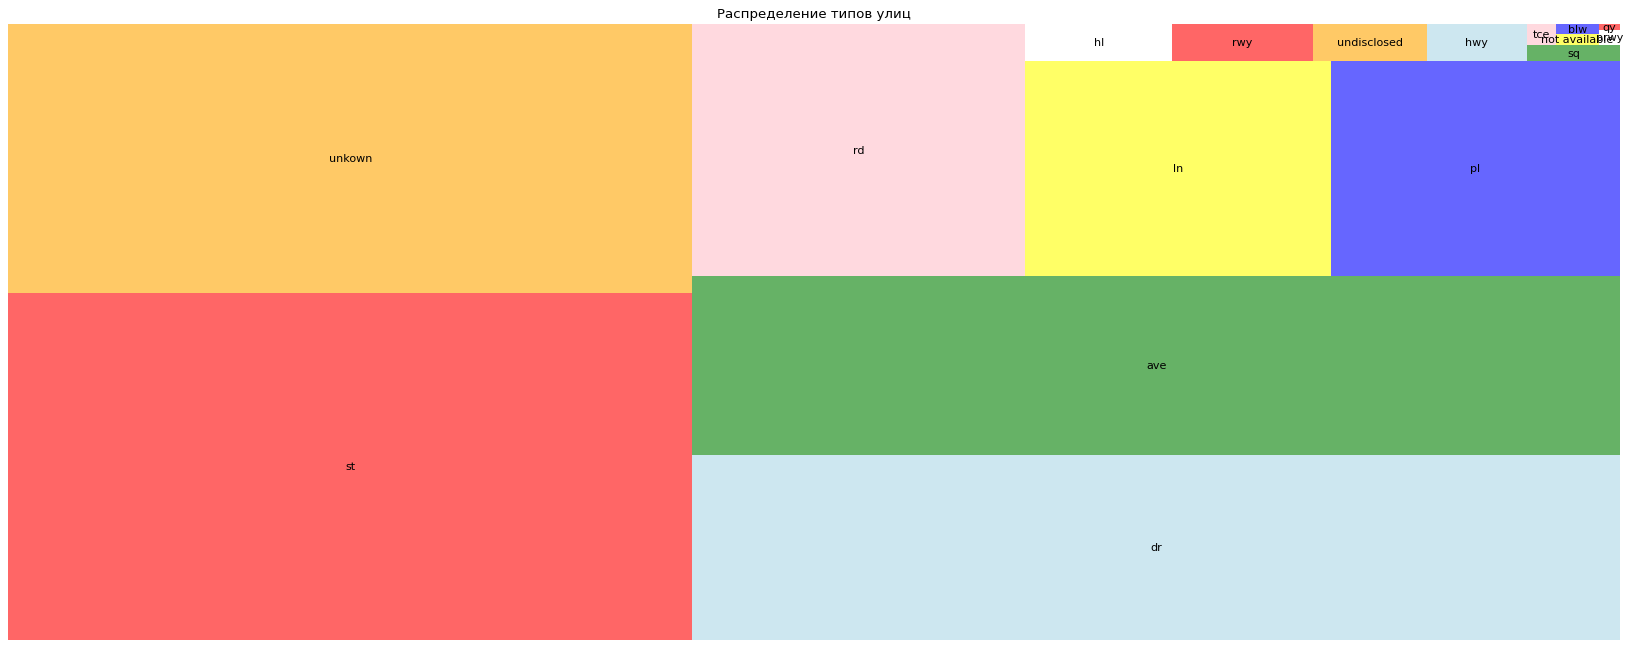

In [46]:
# строим древовидную диаграмму с рапределением стран проживания среди специалистов DS
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_street.values, label = data_street.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Распределение типов улиц')
plt.axis('off')
plt.show()

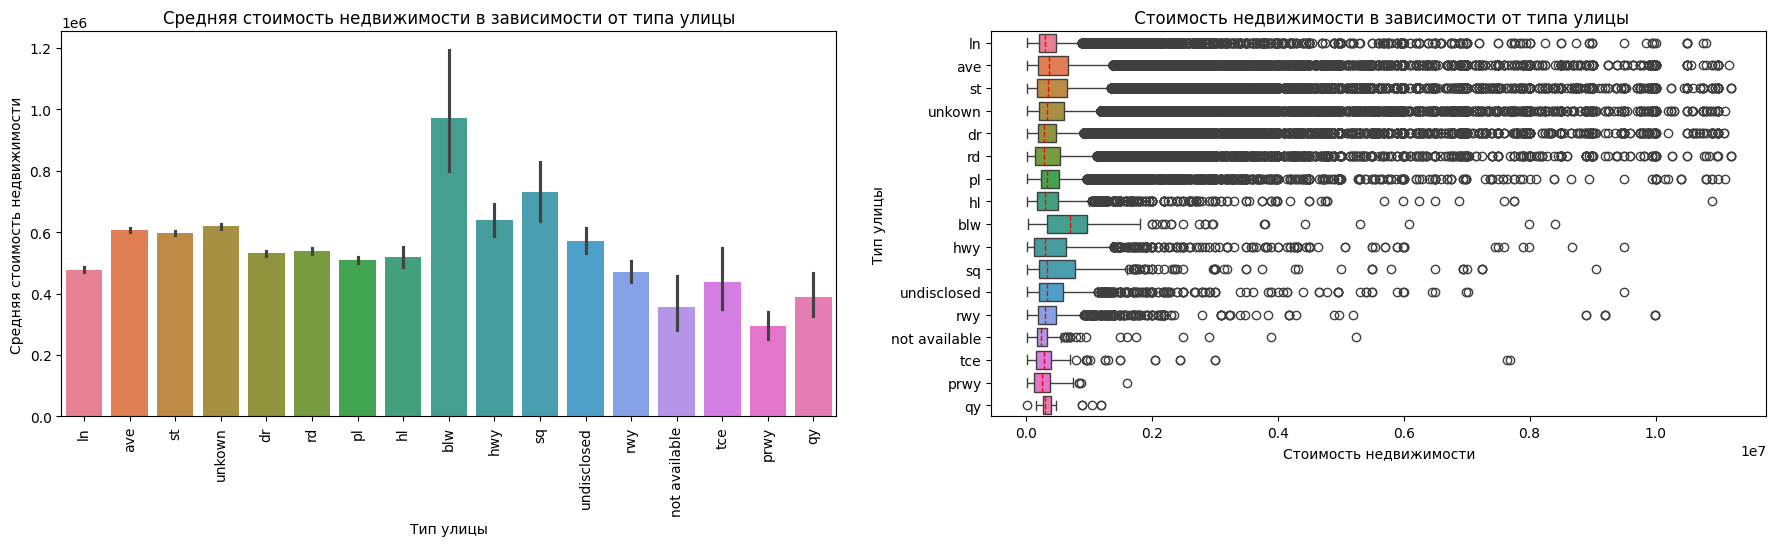

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа улицы
sns.barplot(
            data, 
            x='street', 
            y='target', 
            hue='street', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип улицы', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа улицы')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа улицы
sns.boxplot(
            data, 
            x='target', 
            y='street', 
            orient='h', 
            hue='street',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип улицы')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа улицы')

plt.show()

Большинство адресов находятся на улицах, проспектах, проездах, а так же неизвестно. Самая высокая средняя стоимость у недвижимости, которая находится на бульварах и площадях. Самая низкая средняя стоимость у недвижимости, которая находится на тех типах улиц, что встречаются реже всего в данных - аллеи, набарежные и недостыпные адреса. Возможно это связано с маленьким количеством данных в этих категориях. Коробчатая диаграмма показывает, что медианная цена недвижимости, распложенной на бульварах выше, чем у других категорий. Расположение недвижимости на определенных типах улиц влияет на ее стоимость.

Закодируем признак street однократным кодированием (признак номинальный, количество значений не велико)

In [48]:
encoder = ce.OneHotEncoder(cols = ['street'], use_cat_names=True)
street_bin = encoder.fit_transform(data['street'])
data = pd.concat([data, street_bin], axis=1)

In [49]:
data = data.drop('street', axis = 1)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368194 entries, 0 to 377184
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                329228 non-null  object 
 1   propertyType          334587 non-null  object 
 2   baths                 266798 non-null  object 
 3   homeFacts             368194 non-null  object 
 4   city                  368165 non-null  object 
 5   schools               368194 non-null  object 
 6   sqft                  330605 non-null  object 
 7   beds                  280991 non-null  object 
 8   state                 368194 non-null  object 
 9   target                368194 non-null  float64
 10  street_ln             368194 non-null  int64  
 11  street_ave            368194 non-null  int64  
 12  street_st             368194 non-null  int64  
 13  street_unkown         368194 non-null  int64  
 14  street_dr             368194 non-null  int64  
 15  stree

#### 3.4 Признаки state - штат и  city - город.

Как и в паре индекс-адрес, признаки штат и город сильно коррелируют друг с другом, так как определенные города расположены в определенных штатах. Оставлять оба признака не имеет смысла. Удалим признак state.

In [51]:
data = data.drop('state', axis=1)

In [52]:
# выведем статистику
data['city'].describe()

count      368165
unique       2008
top       Houston
freq        24366
Name: city, dtype: object

In [53]:
# посмотрим на распределение
data['city'].value_counts().nlargest(20)

city
Houston            24366
San Antonio        15478
Miami              15294
Jacksonville        9820
Dallas              8721
Brooklyn            7231
Chicago             6806
Charlotte           6516
New York            6332
Las Vegas           5948
Fort Worth          5474
Orlando             5147
Austin              5120
Fort Lauderdale     5025
Nashville           4977
Cleveland           4960
Philadelphia        4744
Tampa               4696
Washington          4569
Los Angeles         4027
Name: count, dtype: int64

In [54]:
data['city'].isnull().mean()*100

0.007876282611883953

Признак категориальный, заменим пропуски модой.

In [55]:
data['city'] = data['city'].fillna(data['city'].mode()[0])

Оставить все значения городов будет очень ресурсозатратно, поэтому выделим 20 наиболее часто встречающихся, остальные заменим на 'other'.

In [56]:
popular_city = data['city'].value_counts().nlargest(20).index
data['city'] = data['city'].apply(lambda x: x if x in popular_city else 'other')

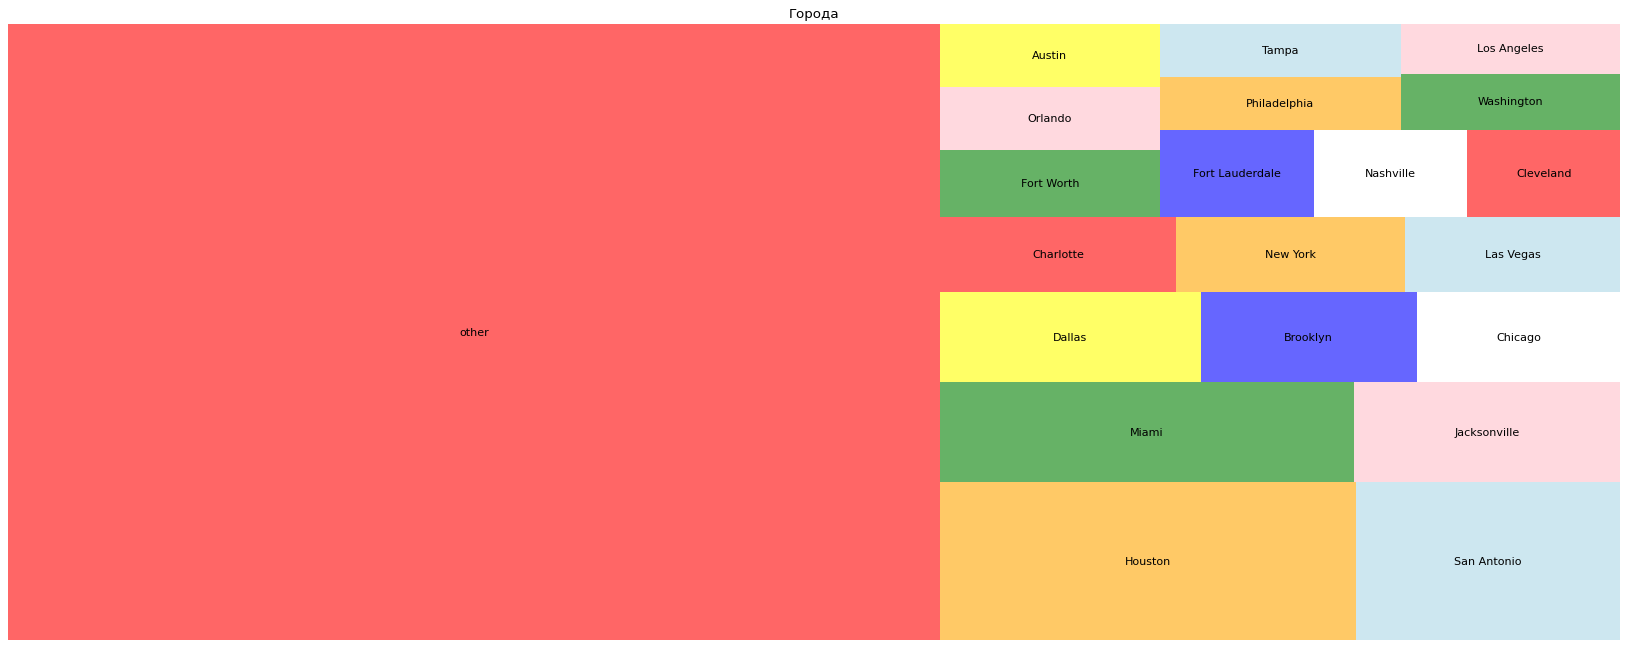

In [57]:
data_city = data.groupby('city')['city'].value_counts()
data_city = data_city.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением городов, в которях находится недвижимость
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_city.values, label = data_city.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Города')
plt.axis('off')
plt.show()

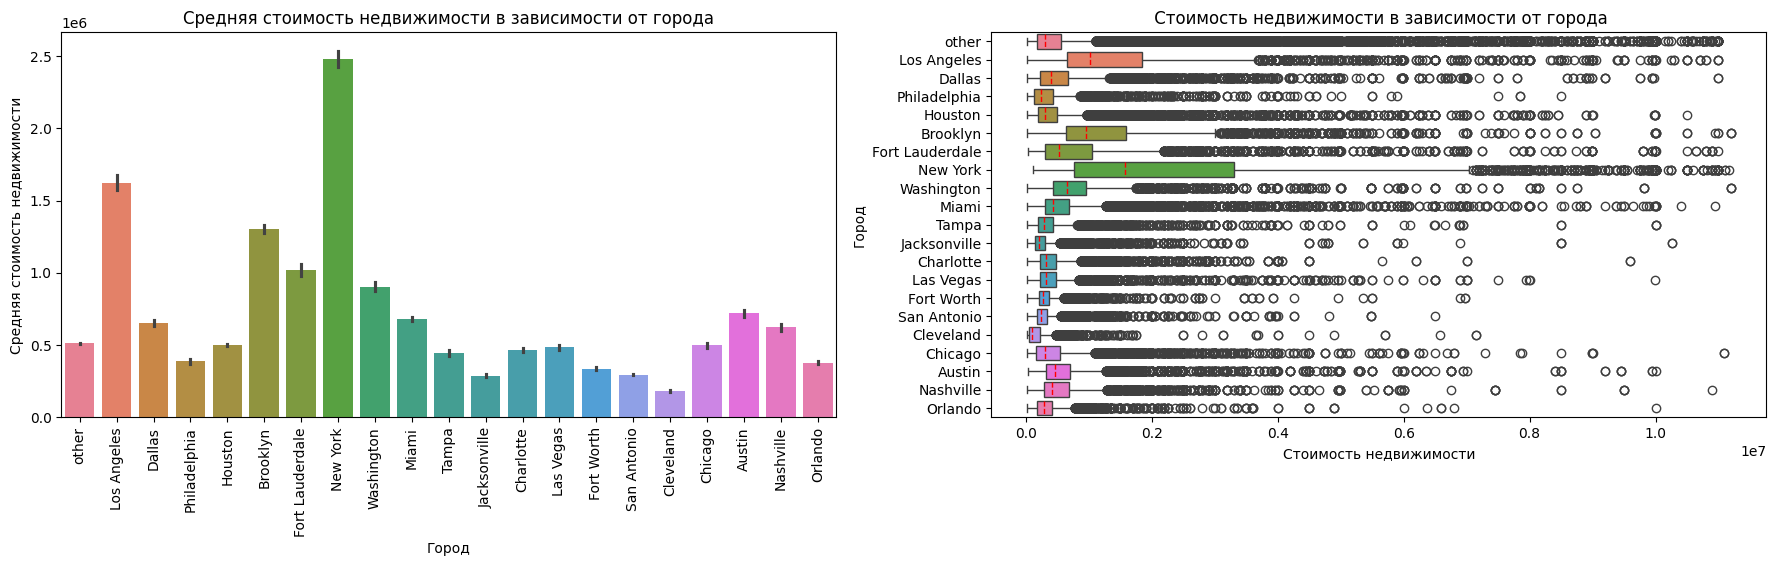

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от города
sns.barplot(
            data, 
            x='city', 
            y='target', 
            hue='city', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Город', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от города')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от города
sns.boxplot(
            data, 
            x='target', 
            y='city', 
            orient='h', 
            hue='city',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Город')
axes[1].set_title(' Стоимость недвижимости в зависимости от города')

plt.show()

Очевидно, что самая высокая средняя стоимость недвижимости будет в самых крупных и дорогих городах - Нью-Йорке и Лос-Анджелесе. Медианная цена также намного выше в этих городах, а также Бруклине (это часть Нью-Йорка), Вашингтоне (столице) и Форт-Лодердейл (город на юго-восточном побережье Флориды, который славится своими пляжами и каналами, популярными у любителей прогулок на яхтах, дорогими ресторанами и отелями). Расположение недвижимости в определенном городе влияет на его цену и разница может доходть до сотен процентов.

Закодируем признак city однократным кодированием (признак номинальный, количество значений не велико)

In [59]:
encoder = ce.OneHotEncoder(cols = ['city'], use_cat_names=True)
city_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, city_bin], axis=1)

In [60]:
data = data.drop('city', axis = 1)

#### 3.5 Признак beds - количество спален.

In [61]:
# выведем статистику
data['beds'].describe()

count     280991
unique      1119
top       3 Beds
freq       52331
Name: beds, dtype: object

In [62]:
# посмотрим на распределение
data['beds'].value_counts().nlargest(15)

beds
3 Beds    52331
4 Beds    34825
3         31140
2 Beds    25880
4         19816
2         15970
Baths     15212
3 bd      12661
5 Beds    11060
4 bd       8176
3.0        8078
5          6286
4.0        5228
2 bd       5154
1          4570
Name: count, dtype: int64

In [63]:
data['beds'].isnull().mean()*100

23.683981813935045

In [64]:
data['beds'].unique().tolist()

['4',
 '3 Beds',
 '5 Beds',
 '2 Beds',
 nan,
 '3',
 '4 Beds',
 '3 bd',
 'Baths',
 '4 bd',
 '5 bd',
 '8 Beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 Beds',
 'Bath',
 '12 Beds',
 '6',
 '14',
 '0.25 acres',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '1 bd',
 '9 Beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '7 Beds',
 '0.32 acres',
 '8,637 sqft',
 '6 bd',
 '7.0',
 '16 Beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '8',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '10 Beds',
 '0.46 acres',
 '0.59 acres',
 '20 Beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 Beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 '8,189 sqft',
 '1.04 acres'

Одна и таже информация о количестве спален записана в разных форматах, по сути нам нужна только цифра. Кроме того есть строки со значением площади в футах (1435 строк) и акрах(1640 строк), как их интерпретировать не ясно, заменим их на np.nan, так как их общее количество менее 1%. Далее оставим только цифру, заменим пропуски на моду, проверим и очистим данные от выбросов.

In [65]:
# заменяем на np.nan строки с площадью
data['beds'] = data['beds'].fillna('unkown')
data['beds'] = data['beds'].apply(lambda x: np.nan if 'sqft' in x or 'acr' in x or 'unkown' in x else x)
# оставляем только числа
data['beds'] = data['beds'].str.replace(r"[^\d\.]", "", regex=True)
data['beds'] = data['beds'].apply(lambda x: str(x).replace('.', '') if  str(x).endswith('.') else x)
data['beds'] = data['beds'].apply(lambda x: np.nan if  x == '' else x)

Не смотря на то, что по сути получается числовой признак, считаю, что пропуски нужно заменить модой - как самое часто встречающееся количество спален.

In [66]:
data['beds'] = data['beds'].fillna(data['beds'].mode()[0])
data['beds'] = data['beds'].astype(float)
data['beds'] = data['beds'].astype(int)

Text(0.5, 1.0, 'Признак beds до удаления выбросов')

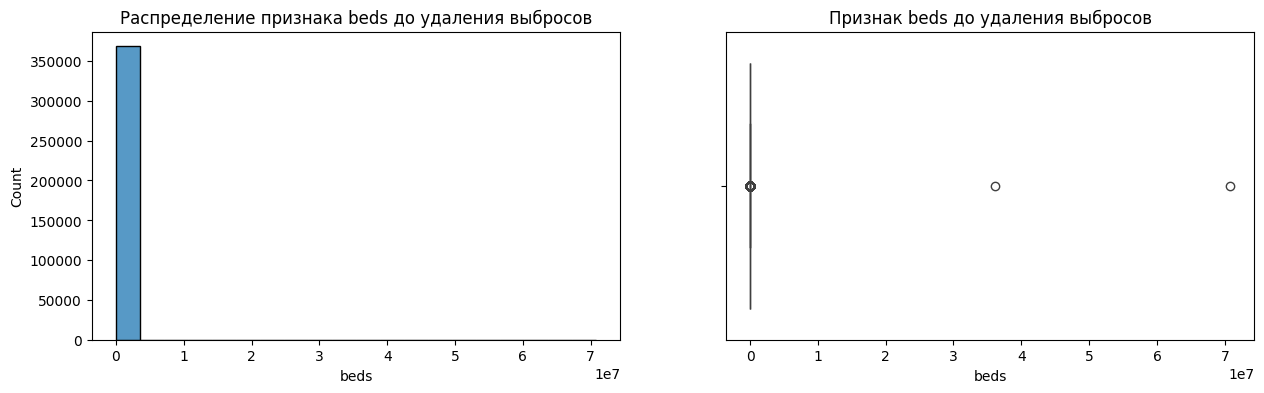

In [67]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'beds', bins=20, ax = axes[0]);
histplot.set_title('Распределение признака beds до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'beds', ax = axes[1])
boxplot.set_title('Признак beds до удаления выбросов')

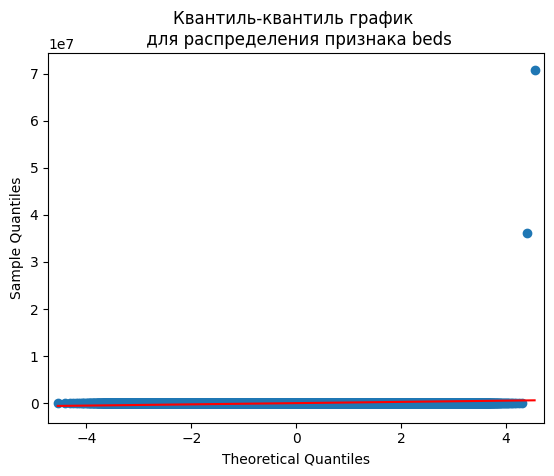

In [68]:
qqplot(data.beds, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака beds')
plt.show()

Визуально не удается определить нормально ли распределение, но выбросы точно есть. Используем тест Д'Агостино для проверки распределения на нормальность.

In [69]:
alpha=0.5
_,p = stats.normaltest(data['beds'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [70]:
outliers, data = outliers_z_score(data, 'beds', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 3989
Результирующее число записей: 364205


In [71]:
data['beds'].unique().tolist()

[4, 3, 5, 2, 1, 6, 7]

Text(0.5, 1.0, 'Признак beds после удаления выбросов')

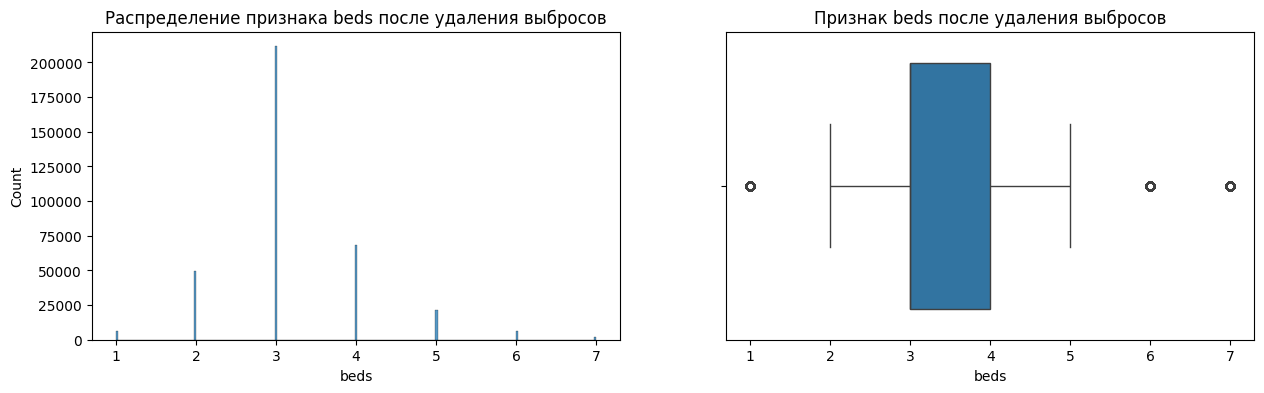

In [72]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'beds', ax = axes[0]);
histplot.set_title('Распределение признака beds после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'beds', ax = axes[1])
boxplot.set_title('Признак beds после удаления выбросов')

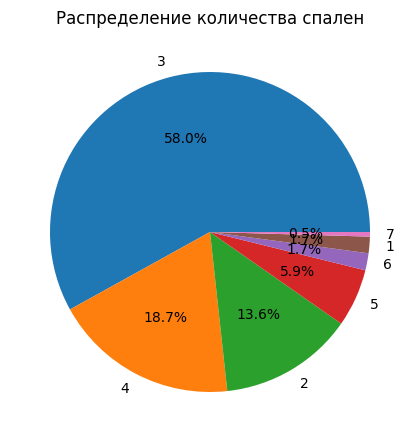

In [73]:
# визуализируем распределение недвижимости по количеству спален
beds_count = data['beds'].value_counts()
fig = plt.figure(figsize = (4,4))
axes = fig.add_axes([0,0,1,1])
axes.pie(beds_count, labels = beds_count.index, autopct = '%.1f%%')
axes.set_title('Распределение количества спален');

Text(0.5, 1.0, ' Стоимость недвижимости в зависимости от количества спален')

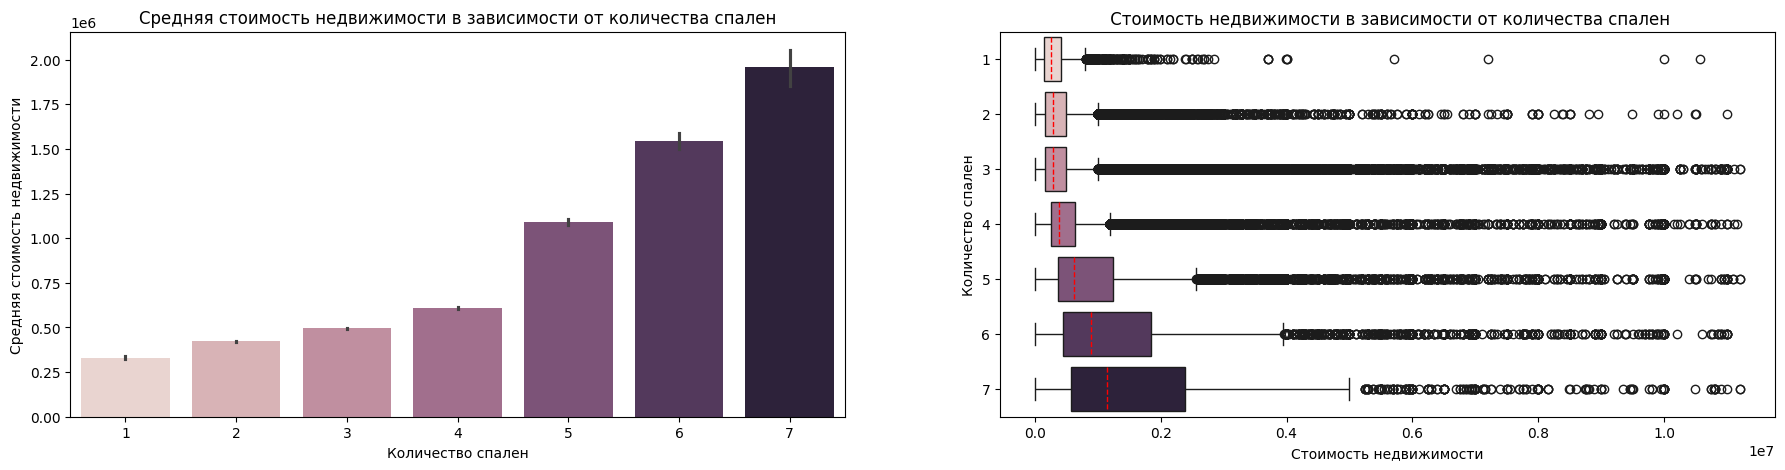

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от количества спален
sns.barplot(
            data, 
            x='beds', 
            y='target', 
            hue='beds', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Количество спален', ylabel='Средняя стоимость недвижимости')
axes[0].set_title('Средняя стоимость недвижимости в зависимости от количества спален')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от количества спален
sns.boxplot(
            data, 
            x='target', 
            y='beds', 
            orient='h', 
            hue='beds',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Количество спален')
axes[1].set_title(' Стоимость недвижимости в зависимости от количества спален')

Наиболшее количество объектов недвижимости имеют от 2 до 4 спален. Средняя стоимость недвижимости возрастает с увеличением количества спален, что логично, чем больше спален, тем больше площадь дома и соответственно его цена. Тоже самое можно сказать про медианную цену. Объекты, в которых до 3-х спален, имеют близкую медианную цену, а начиная с объектов с 4-мя спальнями медианная цена постепенно увличивается. От количества спален цена объекта определенно зависит.

#### 3.6 Признак baths - количество ванных комнат.

In [75]:
# выведем статистику
data['baths'].describe()

count      263682
unique        169
top       2 Baths
freq        51622
Name: baths, dtype: object

In [76]:
# посмотрим на распределение
data['baths'].value_counts().nlargest(15)

baths
2 Baths         51622
3 Baths         35115
2               20399
2.0             16305
4 Baths         14303
3.0             10763
3               10063
Bathrooms: 2     9394
2.5              8110
Bathrooms: 3     6544
1                6363
1.0              5466
5 Baths          5070
4.0              4494
2.5 Baths        4386
Name: count, dtype: int64

In [77]:
data['baths'].isnull().mean()*100

27.600664460949194

In [78]:
data['baths'].unique().tolist()

['3.5',
 '3 Baths',
 '2 Baths',
 '8 Baths',
 nan,
 '2',
 '3',
 'Bathrooms: 2',
 '1,750',
 '4 Baths',
 '2 ba',
 'Bathrooms: 5',
 '1,000',
 '2.0',
 '3.0',
 'Bathrooms: 1',
 '4.0',
 '2.1 Baths',
 '2.5 Baths',
 '1',
 'Bathrooms: 3',
 '4.5',
 '6 Baths',
 'Bathrooms: 4',
 '3 ba',
 '5',
 '2,500',
 '5.5 Baths',
 '1.0',
 '5 Baths',
 '1.5',
 '4',
 '~',
 '2.5',
 '4,000',
 '3.5 Baths',
 '2,000',
 '3,000',
 '1 ba',
 '0',
 '5.0',
 '1,500',
 '7.0',
 '1,250',
 '9 Baths',
 '2,250',
 '6.0',
 '5.5',
 '7 Baths',
 '3,500',
 '1.5 Baths',
 '2,750',
 'Bathrooms: 6',
 '4.5 Baths',
 '750',
 '5.5+',
 '6',
 '6 ba',
 '10 Baths',
 '4 ba',
 '12 ba',
 '2.5+',
 '8',
 '7.5+',
 '0 / 0',
 'Sq. Ft. ',
 '8.0',
 '5 ba',
 '-- baths',
 'Bathrooms: 7',
 '7',
 '3.5+',
 '1.5+',
 '11 Baths',
 '5,000',
 '1.75 Baths',
 '10.0',
 'Bathrooms: 10',
 '12.0',
 '6.5',
 'Bathrooms: 8',
 '4.5+',
 '19 Baths',
 'Bathrooms: 9',
 '13 Baths',
 '9.0',
 '8.5+',
 '7 ba',
 '1.1 Baths',
 '2.5 ba',
 '12 Baths',
 'Bathrooms: 241',
 '9',
 '10',
 '6.5+',

Признак baths похож по содержанию на признак beds, информация записана в разном формате. По сути нам нужна только цифра. Пропуски как и в случае с beds заменим на моду - как самый часто встречающийся вариант с ванными комнатами. Проверим и очистим признак от выбросов. Так же хочется обратить внимание на дробные значения.Типы ванных комнат определяются на основе того, какие из четырех основных приборов для ванной комнаты включены: унитаз, раковина, ванна и душ. Полноценной считается ванная комната с туалетом, раковиной и ванной/душевой кабиной, а помещение, где есть только туалет и раковина — это 0.5 ванной комнаты. Ванная комната на три четверти будет иметь три из четырех ключевых компонентов. Чаще всего такие комнаты будут включать туалет, раковину и душевую кабину без ванны.

In [79]:
# оставляем только числа
data['baths'] = data['baths'].apply(lambda x: np.nan if '/' in str(x) else x)
data['baths'] = data['baths'].str.replace(r"[^\d\.]", "", regex=True)
data['baths'] = data['baths'].apply(lambda x: np.nan if  x == '..' or x == '' else x)

In [80]:
data['baths'] = data['baths'].fillna(data['baths'].mode()[0])

In [81]:
data['baths'] = data['baths'].astype(float)

Text(0.5, 1.0, 'Признак baths до удаления выбросов')

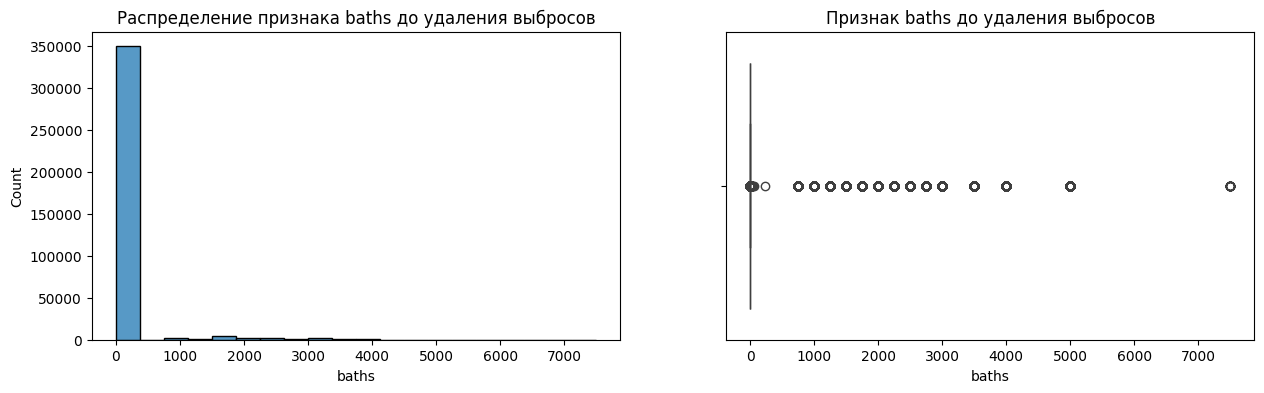

In [82]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'baths', bins=20, ax = axes[0]);
histplot.set_title('Распределение признака baths до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'baths', ax = axes[1])
boxplot.set_title('Признак baths до удаления выбросов')

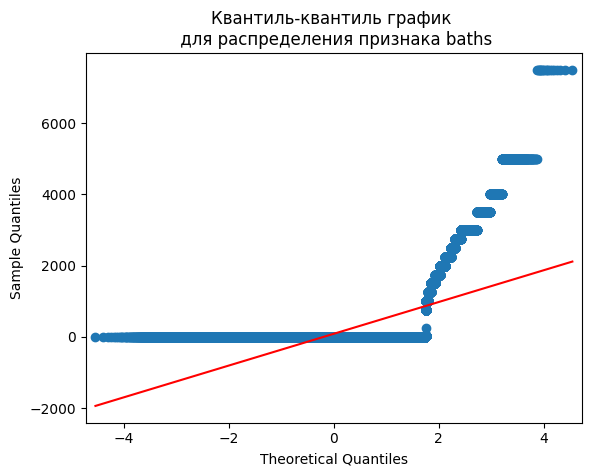

In [83]:
qqplot(data.baths, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака baths')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [84]:
alpha=0.5
_,p = stats.normaltest(data['baths'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [85]:
outliers, data = outliers_z_score(data, 'baths', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 14573
Результирующее число записей: 349632


In [86]:
data['baths'].describe()

count    349632.000000
mean          2.499686
std           1.091293
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          60.000000
Name: baths, dtype: float64

Text(0.5, 1.0, 'Признак baths после удаления выбросов')

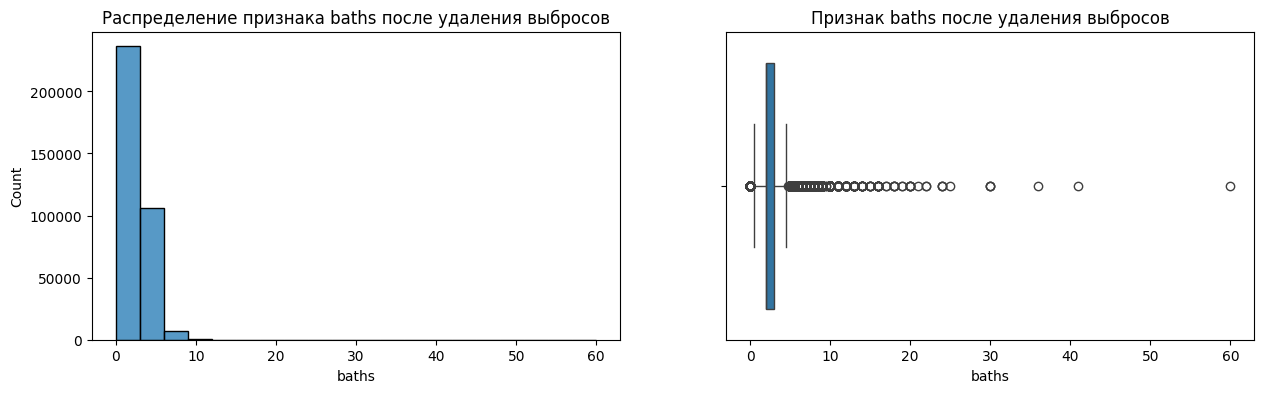

In [87]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'baths', bins = 20, ax = axes[0]);
histplot.set_title('Распределение признака baths после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'baths', ax = axes[1])
boxplot.set_title('Признак baths после удаления выбросов')

Даже после удаления выбросов кажутся не совсем реальными объекты недвижимости с более чем 20-ю ванными комнатами. Удалим такие строки.

In [88]:
data = data.drop(data[data['baths']>=20].index)

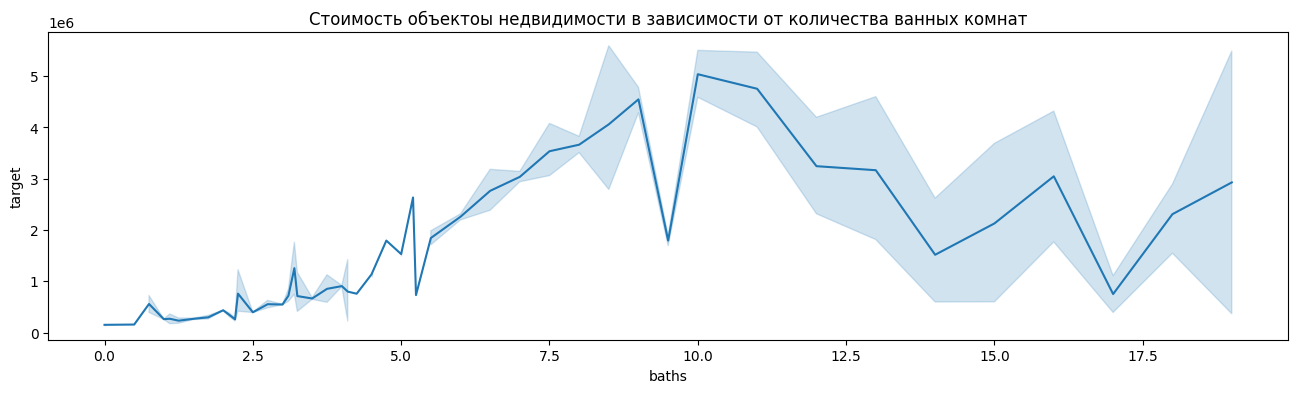

In [89]:
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=data, x="baths", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от количества ванных комнат');

Text(0.5, 1.0, ' Стоимость недвижимости в зависимости от количества ванных комнат')

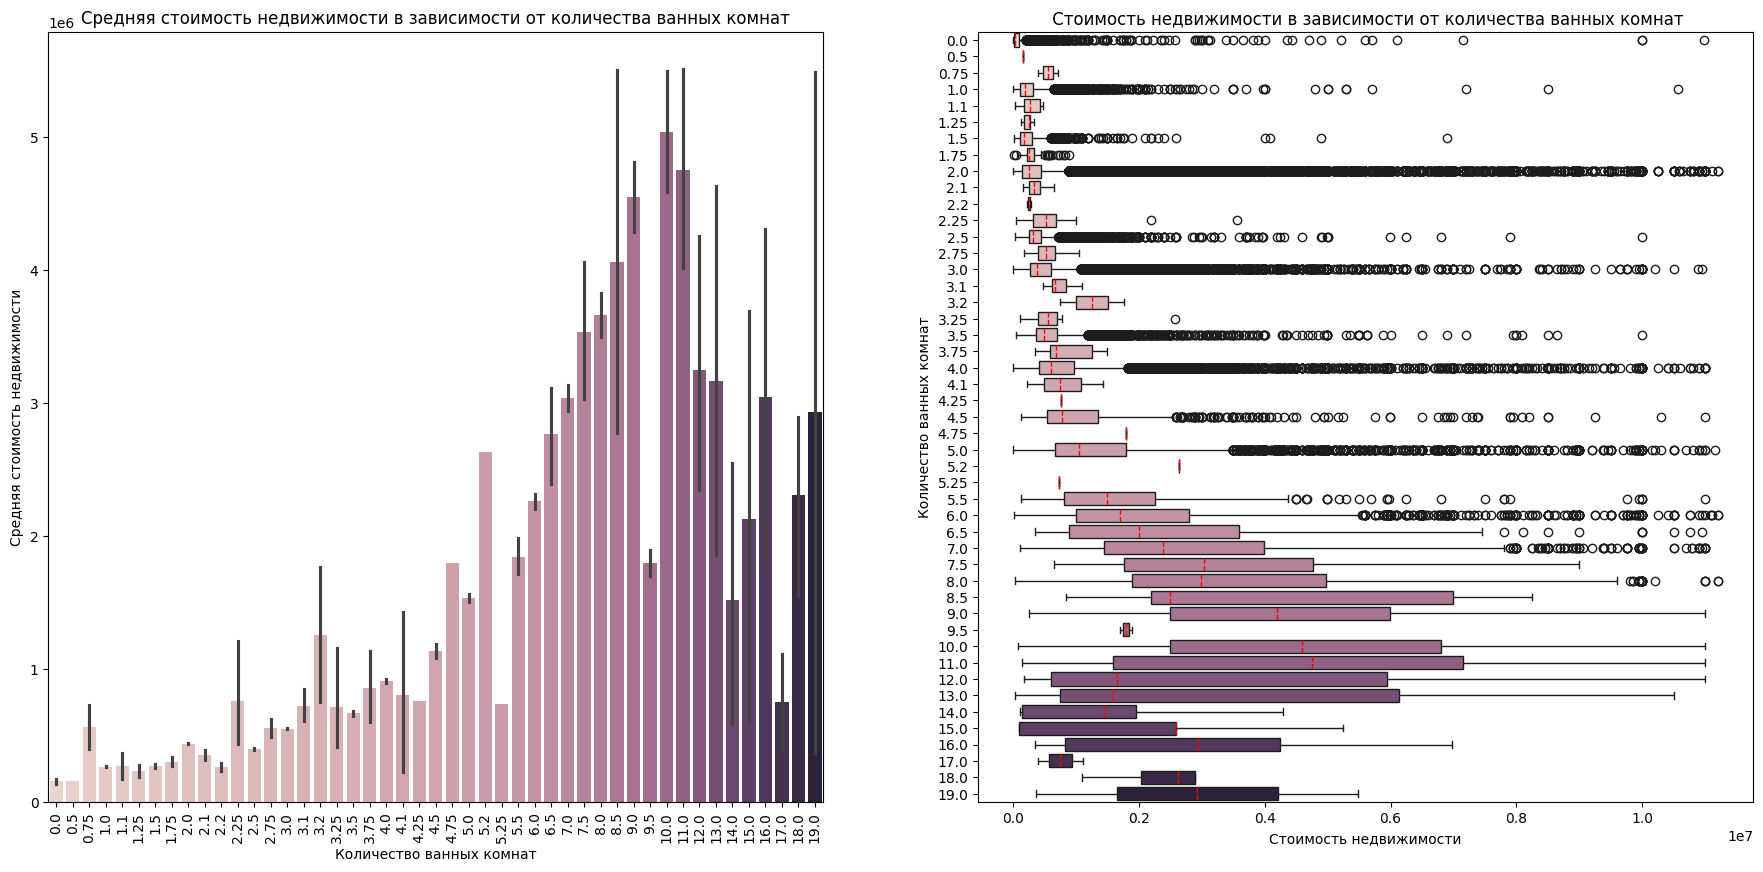

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от количества ванных комнат
sns.barplot(
            data, 
            x='baths', 
            y='target', 
            hue='baths', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Количество ванных комнат', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от количества ванных комнат')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от количества ванных комнат
sns.boxplot(
            data, 
            x='target', 
            y='baths', 
            orient='h', 
            hue='baths',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Количество ванных комнат')
axes[1].set_title(' Стоимость недвижимости в зависимости от количества ванных комнат')

Визуализации говорят о том, что средняя и медианная стоимость недвижимости растет с ростом количества ванных комнат до 11. Провал в цене случается на значениях 5.25 и 9.5, видимо потому что, таких объектов мало (один). Далее средняя и медианная цены снижаются, скорее всего недвижимость с очень большим количеством спален - достаточно специфическая и не пользуется популярностью. Количество ванных комнат влияет на стоимость недвижимости и отличаться стоимость может в разы.

#### 3.7 Признак sqft - площадь в футах.

In [91]:
# выведем статистику
data['sqft'].describe()

count     313892
unique     24130
top            0
freq       10421
Name: sqft, dtype: object

In [92]:
# посмотрим на распределение
data['sqft'].value_counts().nlargest(15)

sqft
0             10421
1,200 sqft      801
1,000 sqft      622
1,100 sqft      555
1,800 sqft      548
1,500 sqft      528
1,400 sqft      507
2,000 sqft      507
--              487
1,600 sqft      442
800 sqft        439
900 sqft        396
1,300 sqft      395
1,440 sqft      366
2,400 sqft      351
Name: count, dtype: int64

In [93]:
data['sqft'].unique().tolist()

['2900',
 '1,947 sqft',
 '3,000 sqft',
 '6,457 sqft',
 '897 sqft',
 '1,507',
 nan,
 '3588',
 '1,930',
 '1,300 sqft',
 '3,130',
 '2,839 sqft',
 'Total interior livable area: 1,820 sqft',
 '2,454',
 '3,325',
 '3,080 sqft',
 '1,612 sqft',
 '1,731 sqft',
 'Total interior livable area: 5,266 sqft',
 '3,645 sqft',
 '1,953 sqft',
 '2,575 sqft',
 '2,349 sqft',
 '935 sqft',
 '1736',
 'Total interior livable area: 1,677 sqft',
 '1,176 sqft',
 '1,085',
 '864 sqft',
 '900 sqft',
 '1,448 sqft',
 '1,396',
 'Total interior livable area: 1,232 sqft',
 '1,720 sqft',
 '2,388 sqft',
 '1,081 sqft',
 '1101',
 'Total interior livable area: 5,358 sqft',
 '1,683 sqft',
 '0',
 '1,200 sqft',
 '1,873',
 '1,908 sqft',
 '1,632 sqft',
 '4339',
 '1,681 sqft',
 '3,756 sqft',
 '1,504 sqft',
 '2,088 sqft',
 '1,076 sqft',
 '2,688',
 '1308',
 '2,200 sqft',
 '1,244 sqft',
 '2272',
 '770 sqft',
 '1,160',
 '3,928 sqft',
 'Total interior livable area: 2,383 sqft',
 '5131',
 '4,520 sqft',
 '1,250 sqft',
 '1,060 sqft',
 '538',

In [94]:
data['sqft'].isnull().mean()*100

10.217554216936394

Площадь объектов в футах представлена в виде строк, в которых указана или только цифра площади или цифра с описанием. Оставляем только цифры, пропуски заменим на медиану, т.к. она менее чувствительна к выбросам. Проверим и очистим признак от выбросов. Площадь несомненно важный, один из ключевых признаков, влияющих на стоимость.

In [95]:
data['sqft'] = data['sqft'].str.replace(r"[^\d\.]", "", regex=True)
data['sqft'] = data['sqft'].apply(lambda x: np.nan if  x == '--' or x ==  '' else x)

In [96]:
data['sqft'] = data['sqft'].fillna(data['sqft'].median())

In [97]:
data['sqft'] = data['sqft'].astype(int)

Text(0.5, 1.0, 'Признак sqft до удаления выбросов')

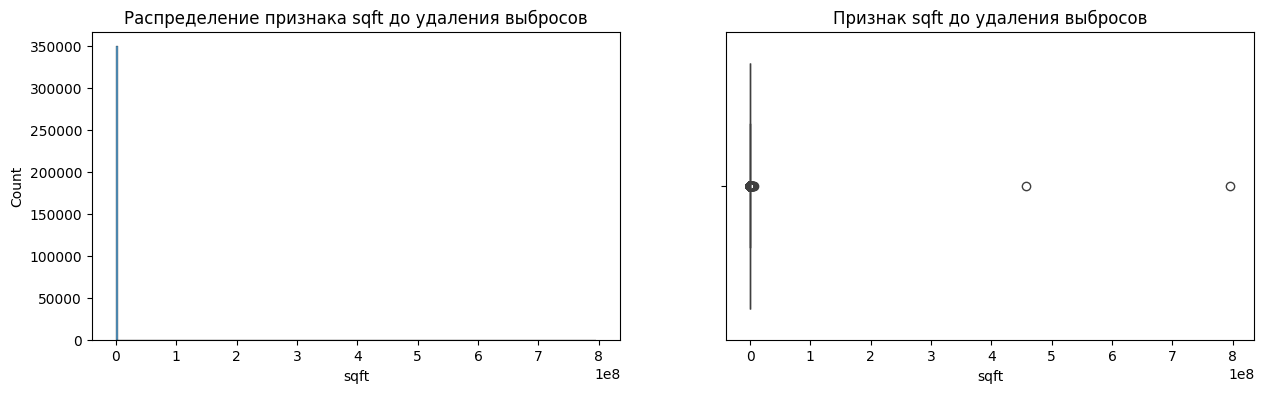

In [98]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'sqft', bins = 200, ax = axes[0]);
histplot.set_title('Распределение признака sqft до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'sqft', ax = axes[1])
boxplot.set_title('Признак sqft до удаления выбросов')

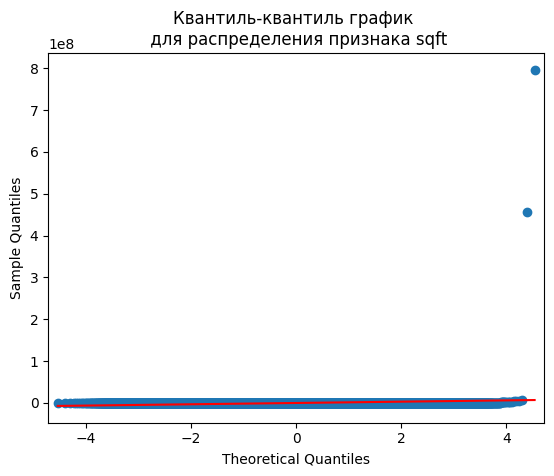

In [99]:
qqplot(data.sqft, line='s')
plt.title('Квантиль-квантиль график \n для распределения признака sqft')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [100]:
alpha=0.5
_,p = stats.normaltest(data['sqft'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [101]:
outliers, data = outliers_z_score(data, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 11204
Результирующее число записей: 338410


Text(0.5, 1.0, 'Признак sqft после удаления выбросов')

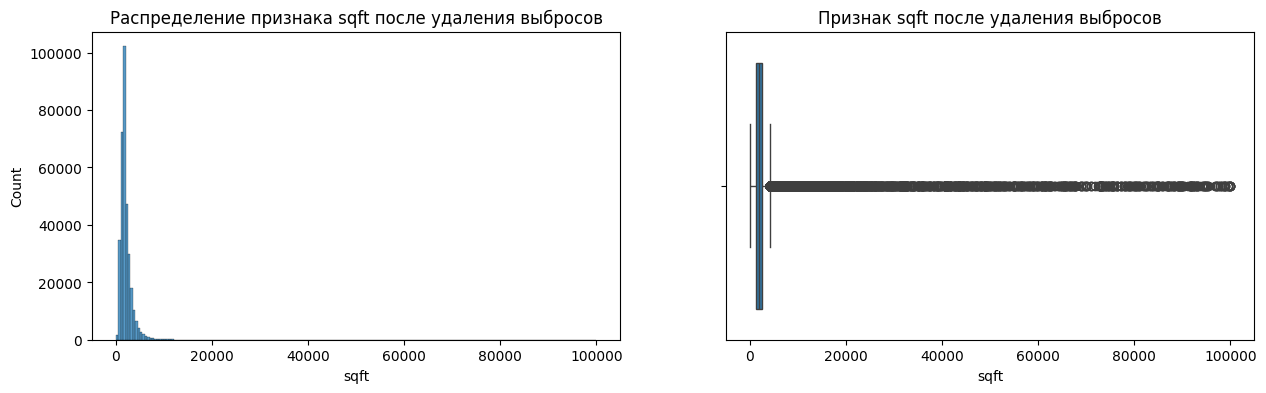

In [102]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'sqft', bins = 200, ax = axes[0]);
histplot.set_title('Распределение признака sqft после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'sqft', ax = axes[1])
boxplot.set_title('Признак sqft после удаления выбросов')

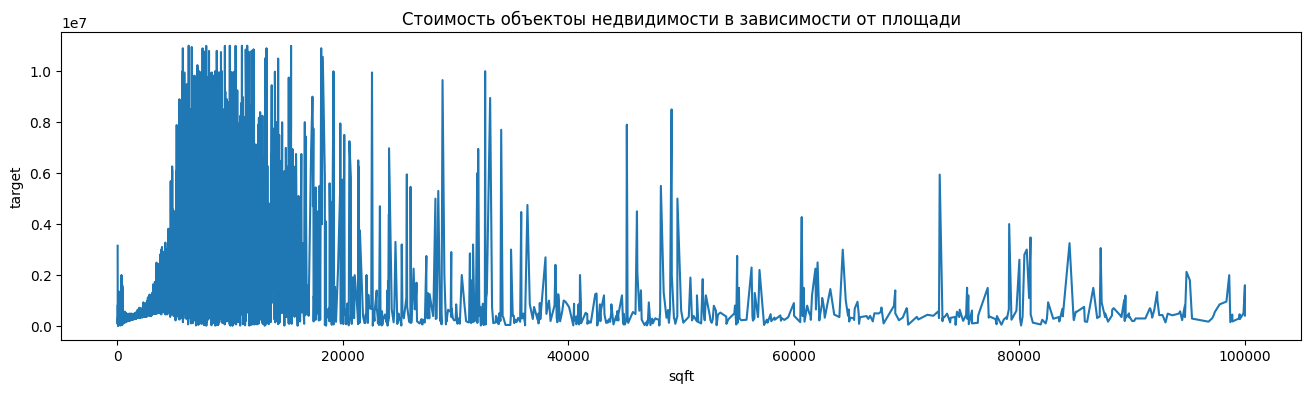

In [103]:
line_data = data.groupby('sqft', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=line_data, x="sqft", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от площади');

Определенной зависимости цены от площади не прослеживается. Все же на стоимость недвижимости влияет несколько ее характеристик.

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                300145 non-null  object 
 1   propertyType          310283 non-null  object 
 2   baths                 338410 non-null  float64
 3   homeFacts             338410 non-null  object 
 4   schools               338410 non-null  object 
 5   sqft                  338410 non-null  int32  
 6   beds                  338410 non-null  int32  
 7   target                338410 non-null  float64
 8   street_ln             338410 non-null  int64  
 9   street_ave            338410 non-null  int64  
 10  street_st             338410 non-null  int64  
 11  street_unkown         338410 non-null  int64  
 12  street_dr             338410 non-null  int64  
 13  street_rd             338410 non-null  int64  
 14  street_pl             338410 non-null  int64  
 15  stree

#### 3.8 Признак status - статус продажи.

In [105]:
# выведем статистику
data['status'].describe()

count       300145
unique         144
top       for sale
freq        151465
Name: status, dtype: object

In [106]:
# посмотрим на распределение
data['status'].value_counts().nlargest(15)

status
for sale                     151465
Active                        78824
For sale                      42310
New construction               5425
foreclosure                    4680
Pending                        4086
Pre-foreclosure                1990
P                              1446
Pre-foreclosure / auction      1277
Under Contract Show            1062
 / auction                      786
Under Contract   Showing        742
Active Under Contract           676
Under Contract                  646
Contingent                      510
Name: count, dtype: int64

In [107]:
data['status'].unique().tolist()

['Active',
 'for sale',
 nan,
 'New construction',
 'New',
 'For sale',
 'Pending',
 'P',
 ' / auction',
 'Under Contract',
 'Pre-foreclosure / auction',
 'Under Contract   Showing',
 'Pre-foreclosure',
 'Under Contract Backups',
 'Active Under Contract',
 'foreclosure',
 'Foreclosed',
 'Option Pending',
 'Under Contract Show',
 'Auction',
 'A Active',
 'Contingent',
 'Pending   Continue To Show',
 'Price Change',
 'Back on Market',
 'Active Option',
 'Foreclosure',
 'Coming soon: Nov 21.',
 'Contingent Finance And Inspection',
 'Coming soon: Dec 4.',
 'P Pending Sale',
 'Coming soon: Nov 23.',
 'Active With Contingencies',
 'Contingent Show',
 'Contingent Take Backup',
 'Backup Contract',
 'Option Contract',
 'Pending Continue To Show',
 'pending',
 'Active Option Contract',
 'C',
 'Auction - Active',
 'Contingent   Show',
 'Pi',
 'Contract Contingent On Buyer Sale',
 'U Under Contract',
 'Coming soon: Nov 29.',
 'Coming soon: Dec 2.',
 'Active Contingency',
 'Pending With Contingenci

In [108]:
data['status'].isnull().mean()*100

11.307289973700541

Признак status имеет 144 уникальных значения, но при детальном рассмотрении, одни и теже данные записаны в разном формате. Систематизируем их, уменьшим количество категорий, пропуски заменим модой и закодируем признак.

In [109]:
data['status'] = data['status'].str.lower()

In [110]:
def get_status(status):
    str_status = str(status)
    for type in str_status:
        if str_status is np.nan:
            return np.nan
        elif 'for sale' in str_status:
            return 'for sale'
        elif 'under contract' in str_status:
            return 'under contract'
        elif 'active' in str_status:
            return 'active'
        elif 'new' in str_status:
            return 'new'
        elif 'pending' in str_status:
            return 'pending'
        elif 'foreclosed' in str_status or 'foreclosure' in str_status:
            return 'foreclosed'
        elif 'auction' in str_status:
            return 'auction'
        elif 'coming soon' in str_status:
            return 'coming soon'
        else:
            return 'other'

In [111]:
data['status'] = data['status'].apply(get_status)

In [112]:
data['status'] = data['status'].fillna(data['status'].mode()[0])

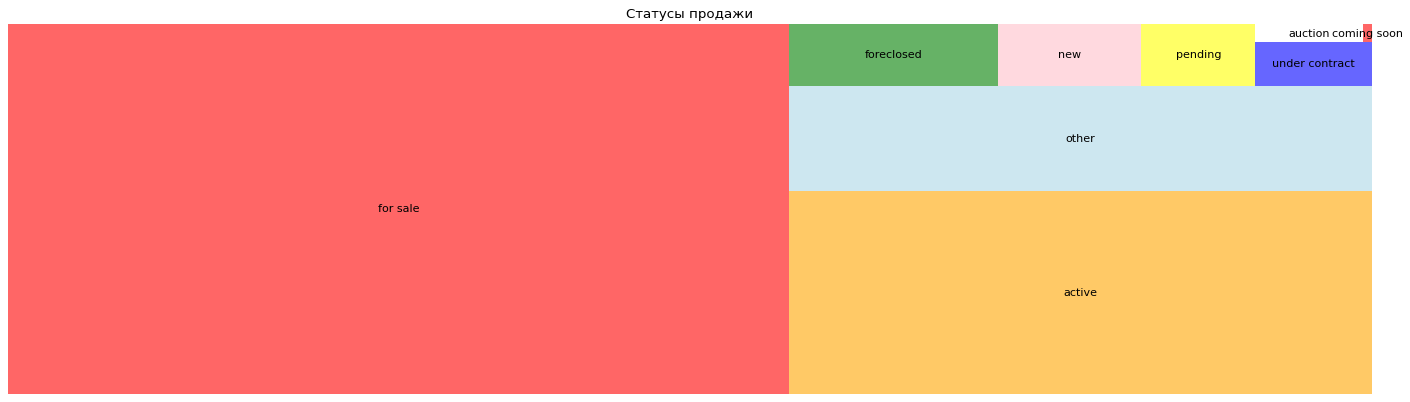

In [113]:
# визуализируем распределение недвижимости по статусу продажи
data_status = data.groupby('status')['status'].value_counts()
data_status = data_status.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением статусов продажи
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_status.values, label = data_status.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Статусы продажи')
plt.axis('off')
plt.show()

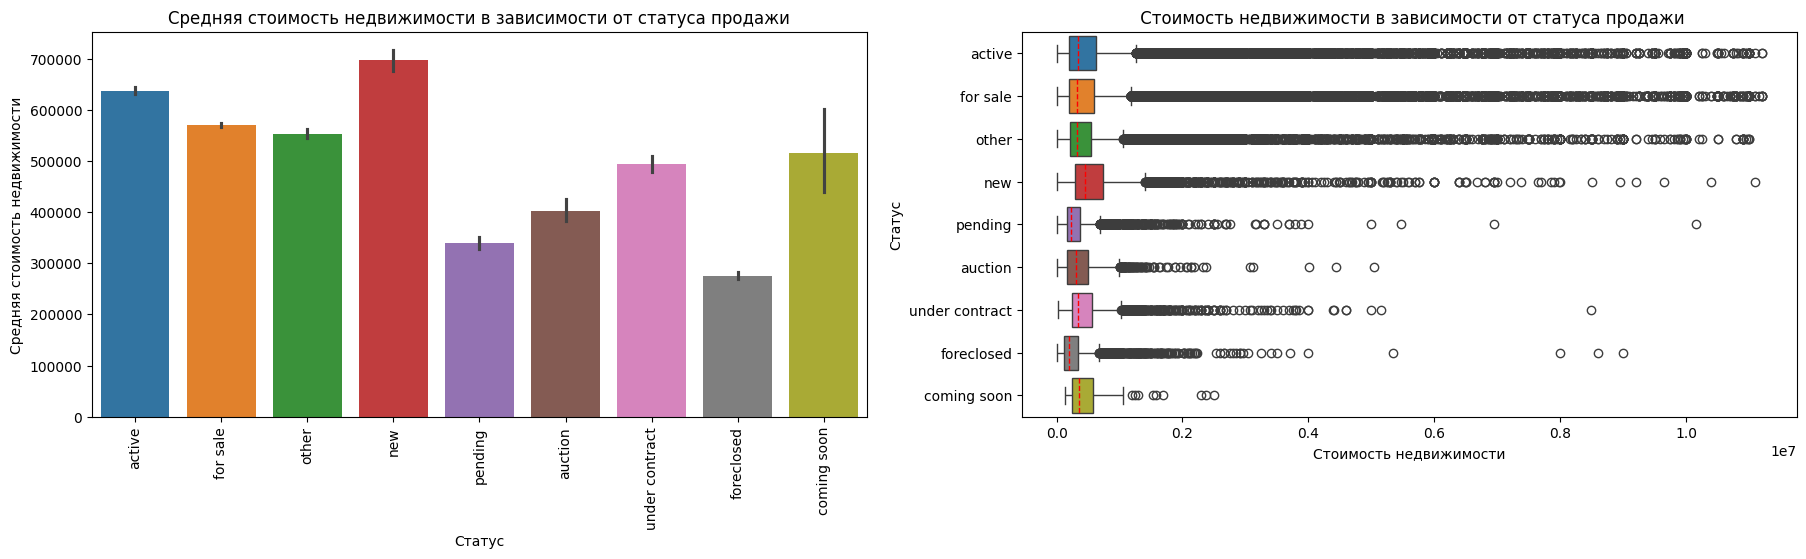

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от статуса продажи
sns.barplot(
            data, 
            x='status', 
            y='target', 
            hue='status', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Статус', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от статуса продажи')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от статуса продажи
sns.boxplot(
            data, 
            x='target', 
            y='status', 
            orient='h', 
            hue='status',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Статус')
axes[1].set_title(' Стоимость недвижимости в зависимости от статуса продажи')

plt.show()

Большинство объектов находятся в статусе for sale и active, что скорее всего значит одно и тоже. Средняя стоимость выше у новых объектов, самая низкая у объектов, лишенных права выкупа. Статус объекта влияет на его цену, которая может отличаться в 2 раза в зависимости от статуса.

In [115]:
encoder = ce.OneHotEncoder(cols = ['status'], use_cat_names=True)
status_bin = encoder.fit_transform(data['status'])
data = pd.concat([data, status_bin], axis=1)

In [116]:
data = data.drop('status', axis = 1)

#### 3.9 Признак propertyType - тип объекта недвижимости.

In [117]:
# выведем статистику
data['propertyType'].describe()

count                 310283
unique                  1075
top       single-family home
freq                   89590
Name: propertyType, dtype: object

In [118]:
# посмотрим на распределение
data['propertyType'].value_counts().nlargest(15)

propertyType
single-family home               89590
Single Family                    61146
Single Family Home               31015
condo                            25640
lot/land                         18657
Condo                            16007
townhouse                        11286
Condo/Townhome/Row Home/Co-Op     7478
Townhouse                         6794
multi-family                      6493
Traditional                       4342
coop                              2718
Multi Family                      2050
mobile/manufactured               1606
High Rise                         1547
Name: count, dtype: int64

In [119]:
data['propertyType'].isnull().mean()*100

8.311515617150793

In [120]:
data['propertyType'].unique().tolist()

['Single Family Home',
 'single-family home',
 'townhouse',
 'Florida',
 nan,
 'Single Family',
 'coop',
 'English',
 '2 Story',
 'Townhouse',
 'multi-family',
 'Multi-Family Home',
 'Condo',
 'condo',
 'lot/land',
 ' ',
 'Detached, Two Story',
 'Other Style',
 'Colonial',
 'Transitional',
 'High Rise',
 'mobile/manufactured',
 'Tri-Level, Northwestern Contemporary',
 'Condo/Townhome/Row Home/Co-Op',
 'Detached, One Story',
 'Craftsman',
 'Single Detached, French',
 'Single Detached, Traditional',
 '1 Story, Traditional',
 'Federal',
 'Multi Family',
 'Traditional',
 'Custom',
 'Cooperative',
 'Cape Cod, Contemporary, Florida, Key West',
 'Mobile / Manufactured',
 'Contemporary/Modern',
 'Miscellaneous',
 'Mfd/Mobile Home',
 'Bungalow',
 '1 Story',
 'Spanish/Mediterranean',
 'Contemporary',
 'Multi-Level, Modern',
 'Condo/Unit',
 '2 Stories, Traditional',
 'Ranch',
 'Low-Rise (1-3 Stories)',
 '1 Story, Contemporary',
 'Bungalow, Cape Cod',
 'Single Detached',
 'Urban Contemporary',
 '2

Как и в предыдущих признаках большое количество уникальных значений в призаке propertyType объясняется тем, что одна и таже информация записана в разном формате. Систематизируем ее, уменьшим количество значений, пропуски заменим на моду и закодируем признак.

In [121]:
data['propertyType'] = data['propertyType'].str.lower()

In [122]:
def get_property_type(property_type):
    str_property_type = str(property_type)
    for type in str_property_type:
        if property_type is np.nan:
            return np.nan
        elif 'detached' in str_property_type:
            return 'detached'
        elif 'single-family' in str_property_type or 'single family' in str_property_type:
            return 'single-family'
        elif 'multi-family' in str_property_type or 'multi family' in str_property_type:
            return 'multi-family'
        elif 'condo' in str_property_type:
            return 'condo'
        elif 'lot' in str_property_type:
            return 'lot'
        elif 'townhouse' in str_property_type:
            return 'townhouse'
        else:
            return 'other'

In [123]:
data['propertyType'] = data['propertyType'].apply(get_property_type)

In [124]:
data['propertyType'] = data['propertyType'].fillna(data['propertyType'].mode()[0])

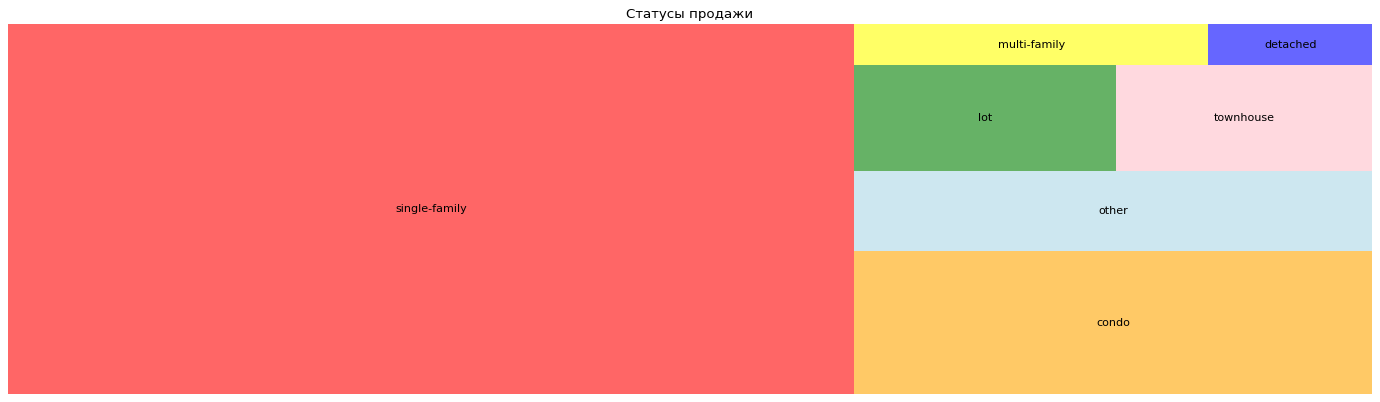

In [125]:
# визуализируем распределение недвижимости по типу недвижимости
data_propertyType = data.groupby('propertyType')['propertyType'].value_counts()
data_propertyType = data_propertyType.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением статусов продажи
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_propertyType.values, label = data_propertyType.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Статусы продажи')
plt.axis('off')
plt.show()

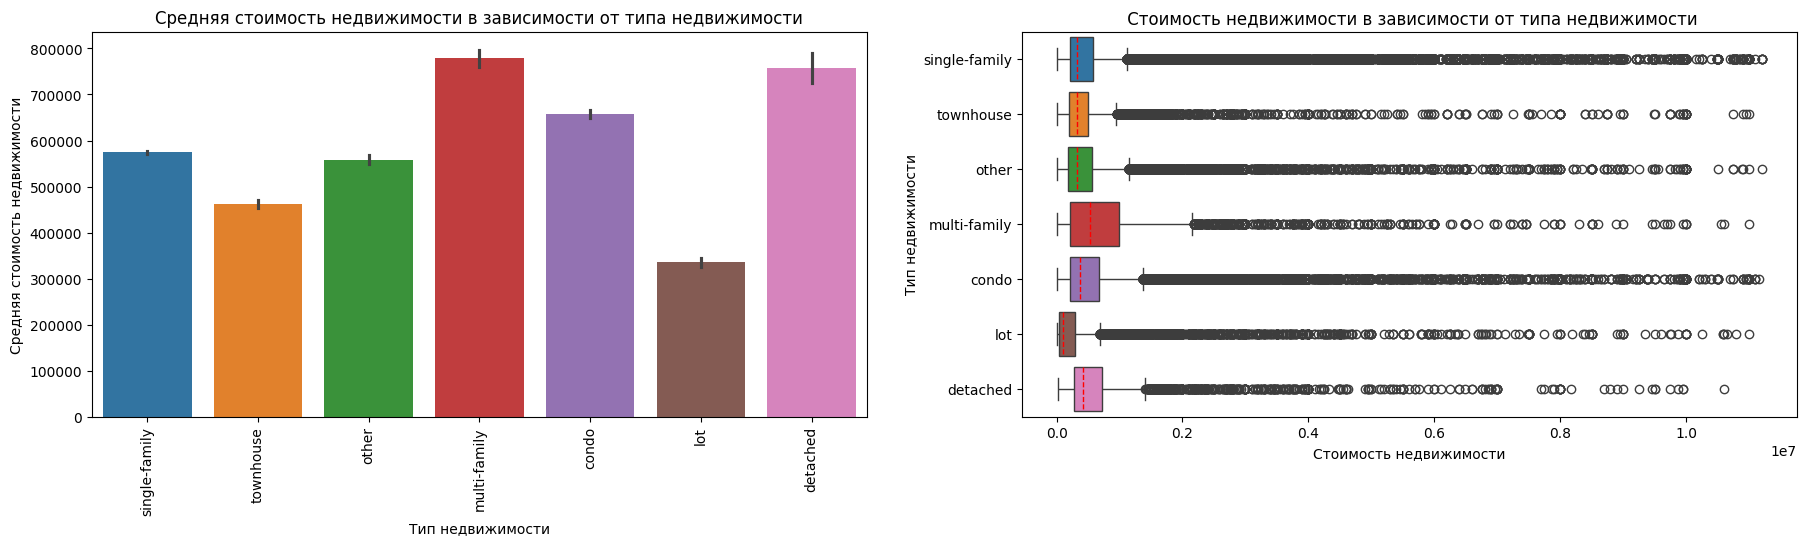

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа недвижимости
sns.barplot(
            data, 
            x='propertyType', 
            y='target', 
            hue='propertyType', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип недвижимости', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа недвижимости')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа недвижимости
sns.boxplot(
            data, 
            x='target', 
            y='propertyType', 
            orient='h', 
            hue='propertyType',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип недвижимости')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа недвижимости')

plt.show()

Наивысшая средняя стоимость у отдельно стоящей недвижимости (что неудевительно) и недвижимости, расположенной в многоквартирном доме (это неожиданно). Медианная цена также немного выше в этих двух категориях. Тип недвижимости влияет на ее стоимость, но большинство категорий не имеет сильной разницы в цене.

In [127]:
encoder = ce.OneHotEncoder(cols = ['propertyType'], use_cat_names=True)
propertyType_bin = encoder.fit_transform(data['propertyType'])
data = pd.concat([data, propertyType_bin], axis=1)

In [128]:
data = data.drop('propertyType', axis = 1)

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 60 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       338410 non-null  float64
 1   homeFacts                   338410 non-null  object 
 2   schools                     338410 non-null  object 
 3   sqft                        338410 non-null  int32  
 4   beds                        338410 non-null  int32  
 5   target                      338410 non-null  float64
 6   street_ln                   338410 non-null  int64  
 7   street_ave                  338410 non-null  int64  
 8   street_st                   338410 non-null  int64  
 9   street_unkown               338410 non-null  int64  
 10  street_dr                   338410 non-null  int64  
 11  street_rd                   338410 non-null  int64  
 12  street_pl                   338410 non-null  int64  
 13  street_hl          

#### 3.10 Признак homeFacts - сведения о строительстве объекта.

In [130]:
# выведем статистику
data['homeFacts'].describe()

count                                                338410
unique                                               294179
top       {'atAGlanceFacts': [{'factValue': '', 'factLab...
freq                                                   6347
Name: homeFacts, dtype: object

In [131]:
# посмотрим на распределение
data['homeFacts'].value_counts().nlargest(15)

homeFacts
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                 6347
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}      3431
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '', 'factLabe

In [132]:
data['homeFacts'].isnull().mean()*100

0.0

Признак homeFacts состоит из словаря со сведениями об объекте:

 - год постройки
 - год реконструкции
 - отопление
 - кондиционирование
 - парковка
 - размер участка
 - цена за кв.фут
 
Выделим каждый из фактов в отдельный признак и обработаем их.

In [133]:
new_home_facts_cols = ['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize', 'price/sqft']

for index, col in enumerate(new_home_facts_cols):
    data[col] = data['homeFacts'].apply(lambda x: eval(x).get('atAGlanceFacts')[index].get('factValue'))

Признак Price/sqft - цена за кв. фут является утечкой данных, поэтому его удаляем сразу. И признак homeFacts так же удаляем, всю информацию из него мы получили.

In [134]:
data = data.drop(['homeFacts', 'price/sqft'], axis = 1)

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       338410 non-null  float64
 1   schools                     338410 non-null  object 
 2   sqft                        338410 non-null  int32  
 3   beds                        338410 non-null  int32  
 4   target                      338410 non-null  float64
 5   street_ln                   338410 non-null  int64  
 6   street_ave                  338410 non-null  int64  
 7   street_st                   338410 non-null  int64  
 8   street_unkown               338410 non-null  int64  
 9   street_dr                   338410 non-null  int64  
 10  street_rd                   338410 non-null  int64  
 11  street_pl                   338410 non-null  int64  
 12  street_hl                   338410 non-null  int64  
 13  street_blw         

#### 3.10.1 Признак year built - год постройки.

In [136]:
# выведем статистику
data['year_built'].describe()

count     334977
unique       225
top             
freq       44021
Name: year_built, dtype: object

In [137]:
# посмотрим на распределение
data['year_built'].value_counts().nlargest(15)

year_built
        44021
2019    29775
2006     7528
2005     7064
2007     6715
2018     6424
2004     5183
2017     4836
2016     4706
2008     4692
1950     4253
2003     4247
2002     4023
1920     4004
2001     3922
Name: count, dtype: int64

In [138]:
data['year_built'].isnull().mean()*100

1.0144499276026122

In [139]:
data['year_built'].sort_values().unique()

array(['', '1', '1057', '1060', '1208', '1700', '1703', '1735', '1750',
       '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1803',
       '1804', '1805', '1807', '1808', '1809', '1810', '1812', '1815',
       '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825',
       '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836',
       '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848',
       '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857',
       '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865',
       '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873',
       '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881',
       '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889',
       '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897',
       '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
     

Предположим, что года 1057 и 1060 это ошибка и должны быть 1957 и 1960, заменим их.
Значения 1, 1208, 559990649990 и пустые заменим на np.nan

In [140]:
data.loc[data['year_built']=='1057','year_built'] = '1957'
data.loc[data['year_built']=='1060','year_built'] = '1960'
data['year_built'] = data['year_built'].apply(lambda x: np.nan if  x == '' or x ==  '1' or x == '1208' or x == '559990649990' or x== 'No Data' or x == None else x)

In [141]:
data['year_built'].isnull().mean()*100

14.340592772081203

После преобразований количество пропусков выросло, заменим их на моду и переведем признак в числовой тип.

In [142]:
data['year_built'] = data['year_built'].fillna(data['year_built'].mode()[0])
data['year_built'] = data['year_built'].astype(int)

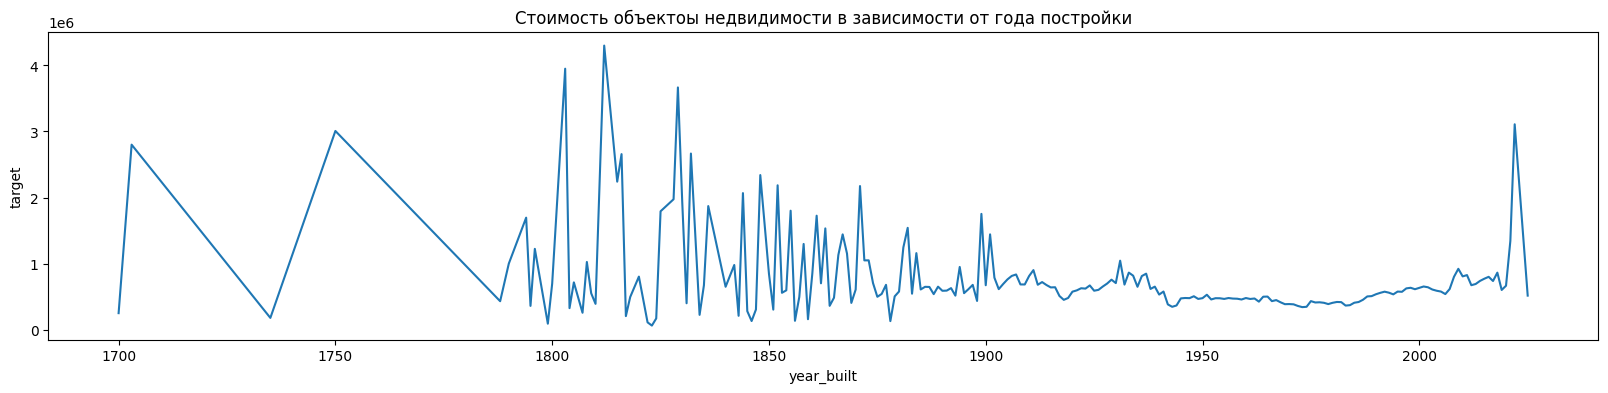

In [143]:
# визуализируем зависимость цены от года постройки
year_built_data = data.groupby('year_built', as_index = False)['target'].mean()
fig = plt.figure(figsize = (20,4))
lineplot = sns.lineplot(data=year_built_data, x="year_built", y="target")
lineplot.set_title('Стоимость объектоы недвидимости в зависимости от года постройки');

Определенной зависимости стоимости недвижимости от года постройки не наблюдается. На объекты до 1900 года стоимость абсолютно разная. После 1950 наблюдается постепенное повышение стоимости и резкий всплеск в районе 2020 года.

#### 3.10.2 Признак remodeled_year - год реконструкции.

In [144]:
# выведем статистику
data['remodeled_year'].describe()

count     313163
unique       152
top             
freq      171725
Name: remodeled_year, dtype: object

In [145]:
# посмотрим на распределение
data['remodeled_year'].value_counts().nlargest(15)

remodeled_year
        171725
2006      5219
2005      4557
2007      4145
2008      3559
2004      3186
1980      3089
1970      2915
2000      2862
1985      2655
2003      2648
2002      2575
1975      2532
1990      2483
1965      2455
Name: count, dtype: int64

In [146]:
data['remodeled_year'].isnull().mean()*100

7.460476936260749

Не смотря на то, что пропусков только 7%, более половины значение пустые. Этот признак удалим.

In [147]:
data = data.drop('remodeled_year', axis = 1)

#### 3.10.3 Признак heating - отопление.

In [148]:
# выведем статистику
data['heating'].describe()

count     334978
unique      1688
top             
freq       82790
Name: heating, dtype: object

In [149]:
# посмотрим на распределение
data['heating'].value_counts().nlargest(15)

heating
                     82790
Forced Air           80474
Forced air           50109
Other                28451
Electric              9373
Gas                   8999
No Data               7966
Central Air           6694
Heat Pump             5979
Central Electric      5973
Central               5115
Central, Electric     3962
Baseboard             3631
Wall                  3116
Heat pump             2710
Name: count, dtype: int64

In [150]:
data['heating'].isnull().mean()*100

1.0141544280606365

In [151]:
data['heating'].sort_values().unique().tolist()

['',
 ' Apply',
 ', Ceiling Heating, Hot Water, Radiator',
 ', Ductless/Mini-Split System, Gas Hot Air/Furnace',
 ', Ductless/Mini-Split System, Heat Pump - Heat, MultiZone Heat',
 ', Electric Baseboard Heat',
 ', Electric Baseboard Heat, Gas Hot Air/Furnace, Natural Gas',
 ', Electric Baseboard Heat, Heat Pump - Heat',
 ', Electric Hot Air',
 ', Electric Hot Air, Gas Floor Furnace, Gas Water Heater',
 ', Electric Hot Air, Gas Floor Furnace, Heat Pump - Heat, Natural Gas',
 ', Electric Hot Air, Gas Hot Air/Furnace',
 ', Electric Hot Air, Gas Hot Air/Furnace, Heat Pump - Heat, MultiZone Heat, Natural Gas',
 ', Electric Hot Air, Gas Water Heater',
 ', Electric Hot Air, Gas Water Heater, Heat Pump - Heat',
 ', Electric Hot Air, Gas Water Heater, Natural Gas',
 ', Electric Hot Air, Heat Pump - Heat',
 ', Electric Hot Air, Heat Pump - Heat, MultiZone Heat',
 ', Electric Hot Air, Heat Pump - Heat, Natural Gas',
 ', Electric Hot Air, Heat Pump - Heat, Propane, Woodstove',
 ', Electric Hot Air

Очень много разной иногда подробной иногда краткой информации об отоплении. Сократим количество значений, пропуски заменим модой, закодируем признак.

In [152]:
data['heating'] = data['heating'].str.lower()
data['heating'] = data['heating'].apply(lambda x: str(x).replace(',', ''))
data['heating'] = data['heating'].apply(lambda x: np.nan if  x == '' or x == 'no data' else x)

In [153]:
data['heating'].isnull().mean()*100

26.818356431547528

Пропусков много, но не достаточно, чтобы удалить весь признак, заменим их на 'unkown'.

In [154]:
data['heating'] = data['heating'].fillna('unkown')

In [155]:
data['heating'].value_counts().nlargest(15)

heating
forced air              130583
unkown                   90756
other                    28451
central electric          9935
electric                  9374
gas                       9002
heat pump                 8689
central air               6694
central                   5115
baseboard                 3631
None                      3432
wall                      3116
heating system            2686
electric heat             2292
forced air heat pump      1734
Name: count, dtype: int64

Выделим 10 самых популярных типов отопления, остальные заменим на 'other'.

In [156]:
popular_heating = data['heating'].value_counts().nlargest(10)
data['heating'] = data['heating'].apply(lambda x: x if x in popular_heating else 'other')

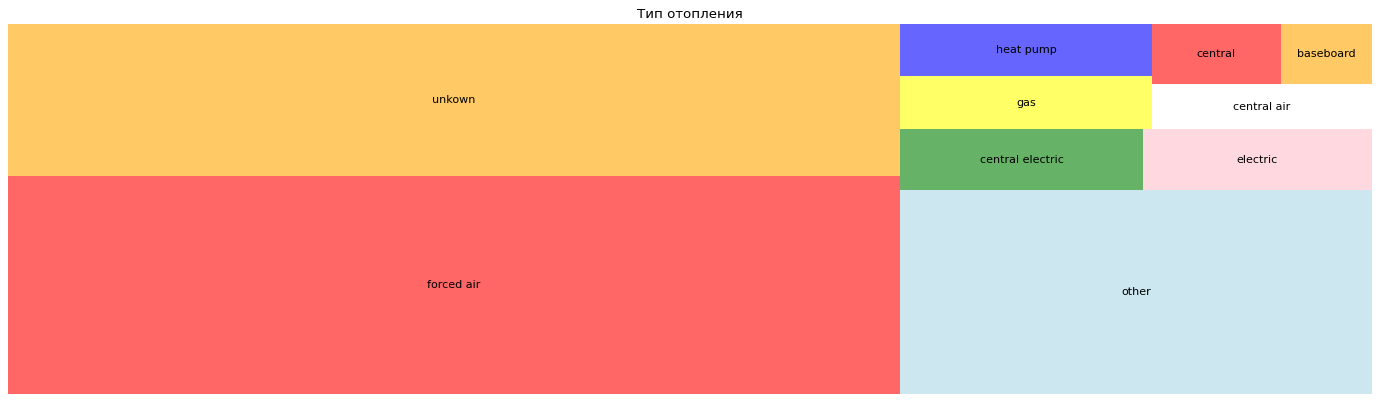

In [157]:
# визуализируем распределение недвижимости по типу отопления
data_heating = data.groupby('heating')['heating'].value_counts()
data_heating = data_heating.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением типов отопления
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_heating.values, label = data_heating.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Тип отопления')
plt.axis('off')
plt.show()

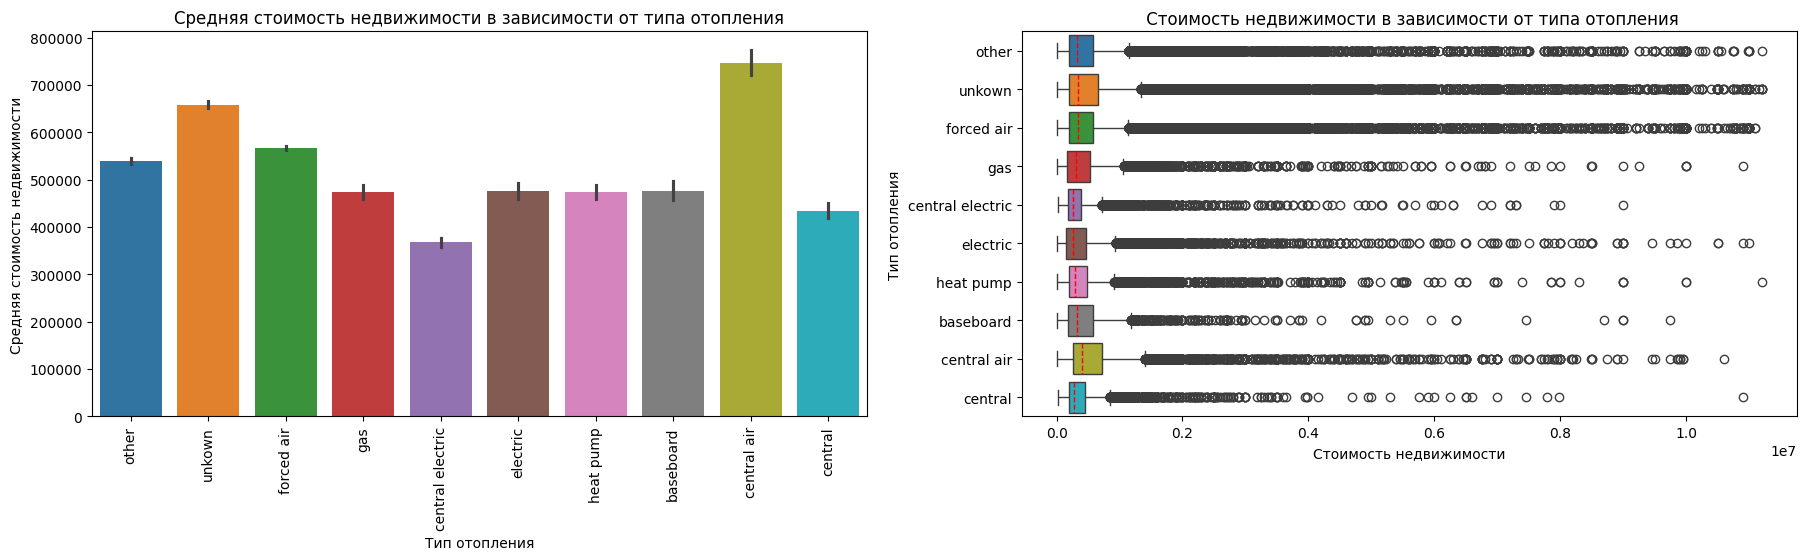

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа отопления
sns.barplot(
            data, 
            x='heating', 
            y='target', 
            hue='heating', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип отопления', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа отопления')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа отопления
sns.boxplot(
            data, 
            x='target', 
            y='heating', 
            orient='h', 
            hue='heating',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип отопления')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа отопления')

plt.show()

Самая высокая средняя цена у объектов с типом отопления central air, самая низкая - central electric (возможно помтоу что электричество - самый дорогой вид топлива). Различие медианной цены не сильные. Из-за того, что скорее всего одни и теже типы отопления записаны в разных форматах достаточно сложно интерпретировать этот признак. Можно отметить, что средняя стоимость зависит от типа отопления.

In [159]:
encoder = ce.OneHotEncoder(cols = ['heating'], use_cat_names=True)
heating_bin = encoder.fit_transform(data['heating'])
data = pd.concat([data, heating_bin], axis=1)

In [160]:
data = data.drop('heating', axis = 1)

#### 3.10.4 Признак cooling - кондиционирование.

In [161]:
# выведем статистику
data['cooling'].describe()

count      334978
unique       1261
top       Central
freq       155401
Name: cooling, dtype: object

In [162]:
# посмотрим на распределение
data['cooling'].value_counts().nlargest(15)

cooling
Central              155401
                      97414
Central Air           12702
No Data                9879
Has Cooling            8335
None                   7048
Central Electric       5806
Wall                   3777
Central Gas            2750
Cooling System         2679
Central A/C            1955
Other                  1668
Central Heating        1595
Refrigeration          1057
Central, Electric      1055
Name: count, dtype: int64

In [163]:
data['cooling'].isnull().mean()*100

1.0141544280606365

In [164]:
data['cooling'].sort_values().unique().tolist()

['',
 ' Apply',
 ', Central A/C',
 ', Gas Hot Air/Furnace',
 ', Gas Hot Air/Furnace, Heat Pump - AC, Natural Gas',
 ', Heat Pump - AC',
 ', Multizone A/C',
 ', Other',
 ', Wall Unit - AC',
 ', Window Unit',
 ', Window Unit(s)',
 '1',
 '1 (Window/Wall Unit)',
 '1 Unit',
 '1 Unit, Baseboard - Cast Iron, Multi-Zone',
 '1 Unit, Baseboard - Hotwater',
 '1 Unit, Baseboard - Hotwater, Multi-Zone',
 '1 Unit, Ceiling Fan, Central Air',
 '1 Unit, Central',
 '1 Unit, Central Air',
 '1 Unit, Central Air, Multi-Zone Cooling',
 '1 Unit, Central Heating',
 '1 Unit, Multi-Zone Cooling, Central Air',
 '2',
 '2 (Window/Wall Unit)',
 '2 Air Conditioners',
 '2 Units',
 '2 Units, Central AC',
 '2 Units, Central AC, Zoned',
 '2 Units, Forced Hot Air',
 '2 Units, Forced Hot Air, Multi-Zone',
 '2 or More Units',
 '2 or More Units, Central',
 '2 or More Units, Central, Electric',
 '2 or More Units, Central, Electric, Whole House Fan',
 '2 or More Units, Central, Electric, Window Unit',
 '2 or More Units, Centr

В значениях этого признака такая же неразбериха как и в признаке heating. Сократим количество значений, пропуски заменим модой, закодируем признак. Хотя оба эти признаки вызывают недоверие в своей надежности и точности для ML.

In [165]:
data['cooling'] = data['cooling'].str.lower()
data['cooling'] = data['cooling'].apply(lambda x: str(x).replace(',', ''))
data['cooling'] = data['cooling'].apply(lambda x: np.nan if  x == '' or x == 'no data' else x)

In [166]:
data['cooling'] = data['cooling'].fillna('unkown')

In [167]:
popular_cooling = data['cooling'].value_counts().nlargest(10)
data['cooling'] = data['cooling'].apply(lambda x: x if x in popular_cooling else 'other')

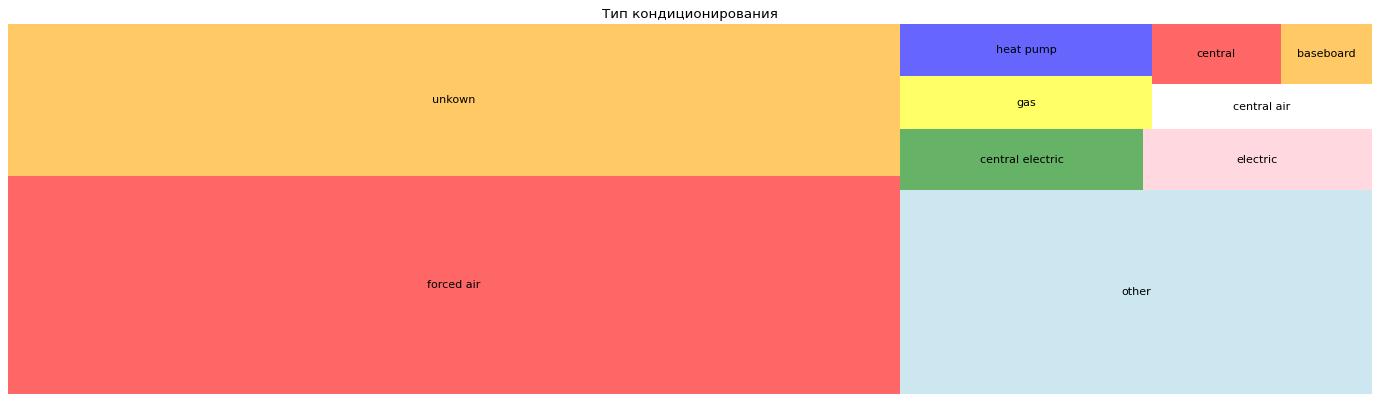

In [168]:
# визуализируем распределение недвижимости по типу кондиционирования
data_cooling = data.groupby('cooling')['cooling'].value_counts()
data_cooling = data_heating.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением типов кондиционирования
plt.figure(figsize=(22,6), dpi= 80)
squarify.plot(sizes = data_cooling.values, label = data_cooling.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Тип кондиционирования')
plt.axis('off')
plt.show()

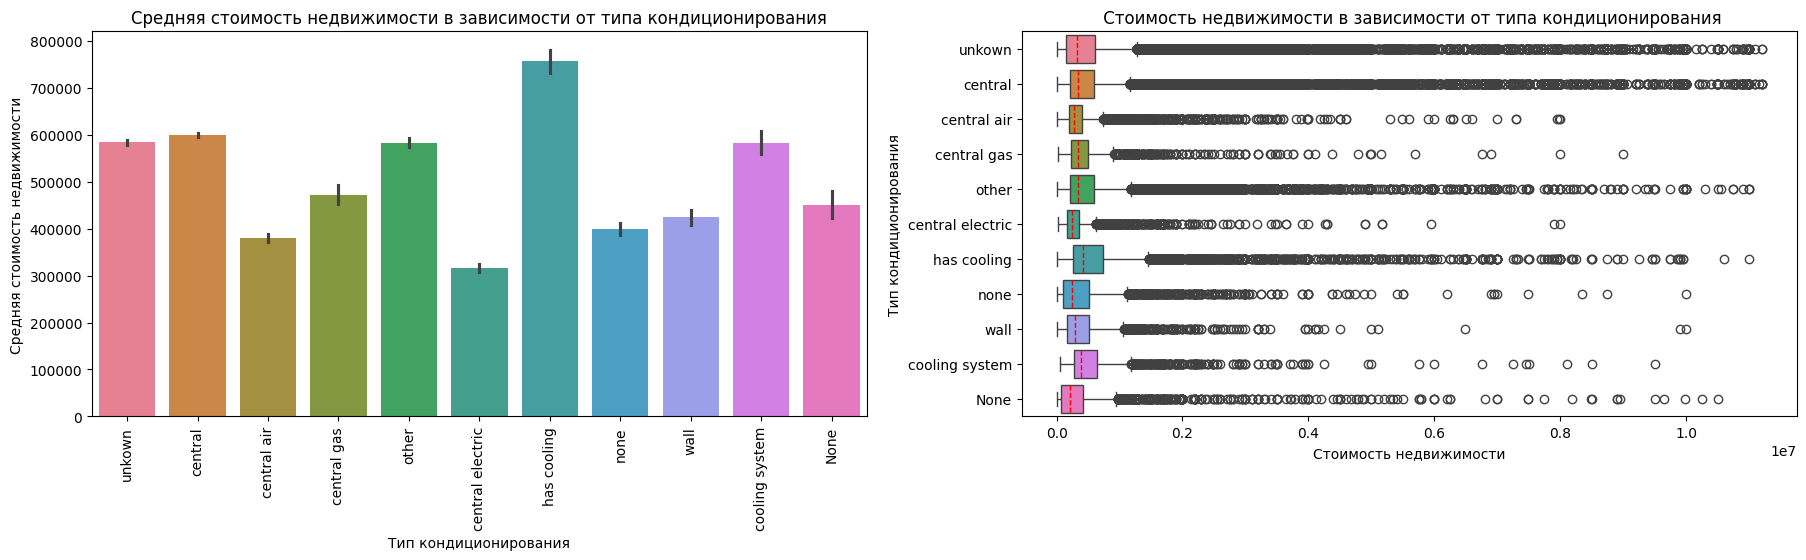

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа кондиционирования
sns.barplot(
            data, 
            x='cooling', 
            y='target', 
            hue='cooling', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип кондиционирования', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа кондиционирования')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа кондиционирования
sns.boxplot(
            data, 
            x='target', 
            y='cooling', 
            orient='h', 
            hue='cooling',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип кондиционирования')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа кондиционирования')

plt.show()

Как и в случае с отоплением недвижимость с центральной системой имеет более высокую стоимость. Также дорого стоят объекты, в которых используется газ, так как это более дешевый вид топлива. Наиболее дешевыми являются объекты, где используется электричество, как самый дорогой вид топлива. Стоимость недвижимости зависит от типа кондиционирования.

In [170]:
encoder = ce.OneHotEncoder(cols = ['cooling'], use_cat_names=True)
cooling_bin = encoder.fit_transform(data['cooling'])
data = pd.concat([data, cooling_bin], axis=1)

In [171]:
data = data.drop('cooling', axis = 1)

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338410 entries, 0 to 377184
Data columns (total 83 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       338410 non-null  float64
 1   schools                     338410 non-null  object 
 2   sqft                        338410 non-null  int32  
 3   beds                        338410 non-null  int32  
 4   target                      338410 non-null  float64
 5   street_ln                   338410 non-null  int64  
 6   street_ave                  338410 non-null  int64  
 7   street_st                   338410 non-null  int64  
 8   street_unkown               338410 non-null  int64  
 9   street_dr                   338410 non-null  int64  
 10  street_rd                   338410 non-null  int64  
 11  street_pl                   338410 non-null  int64  
 12  street_hl                   338410 non-null  int64  
 13  street_blw         

#### 3.10.5 Признак parking - парковка.

In [173]:
# выведем статистику
data['parking'].describe()

count     334978
unique      3199
top             
freq      139927
Name: parking, dtype: object

In [174]:
# посмотрим на распределение
data['parking'].value_counts().nlargest(15)

parking
                            139927
Attached Garage              69162
2 spaces                     27697
1 space                      13871
Detached Garage              12721
No Data                      12244
Carport                       7525
3 spaces                      4631
Off Street                    3488
Carport, Attached Garage      2953
1                             2882
4 spaces                      2819
2                             2718
None                          2233
Off street                    1566
Name: count, dtype: int64

In [175]:
data['parking'].isnull().mean()*100

1.0141544280606365

Предполагаю, что наличие парковки должно влиять на стоимость недвижимости. Но в этом признаке очень много пропусков. Значений np.nan только 1%, но более 40% это пустое значение, кроме того есть еще значение No data - более 3%. Удалим этот признак.

In [176]:
data = data.drop('parking', axis = 1)

#### 3.10.6 Признак lotsize - размер участка.

In [177]:
# выведем статистику
data['lotsize'].describe()

count     311877
unique     33640
top             
freq       31951
Name: lotsize, dtype: object

In [178]:
# посмотрим на распределение
data['lotsize'].value_counts().nlargest(15)

lotsize
               31951
—              19604
No Data         5248
-- sqft lot     3770
0.26 acres      2345
0.28 acres      2033
0.25 acres      2007
0.27 acres      1860
0.29 acres      1822
0.34 acres      1556
6,098 sqft      1460
0.3 acres       1388
7,405 sqft      1306
0.31 acres      1291
6,534 sqft      1245
Name: count, dtype: int64

In [179]:
data['lotsize'].isnull().mean()*100

7.840489347241513

In [180]:
data['lotsize'].sort_values(ascending=False).unique().tolist()

['—',
 'No Data',
 '9999',
 '9998',
 '9997 sqft',
 '9997',
 '9996 sqft',
 '9996',
 '9995 sqft',
 '9994',
 '9990',
 '999.00 acres',
 '999 sqft',
 '999 Sq. Ft.',
 '999',
 '9988 sqft',
 '9988',
 '9985',
 '9984 sqft',
 '9983',
 '9982',
 '998 sqft lot',
 '998 sqft',
 '9979',
 '99752',
 '9975 sqft',
 '9975',
 '9974',
 '9973',
 '99725',
 '9970 sqft',
 '997 sqft',
 '9969',
 '9967',
 '9966',
 '9962 sqft',
 '9962',
 '9960',
 '996 sqft lot',
 '996 sqft',
 '9958',
 '9957 sqft',
 '9950',
 '995 sqft',
 '995',
 '9949',
 '9948 sqft',
 '9948',
 '9945',
 '9944',
 '9941',
 '9940',
 '994 sqft',
 '9938',
 '9933',
 '9932',
 '99317',
 '9931 sqft',
 '993 sqft lot',
 '993 sqft',
 '993 Sq. Ft.',
 '9928',
 '9926',
 '992297',
 '9922',
 '9920',
 '992 sqft lot',
 '992 sqft',
 '992 Sq. Ft.',
 '992',
 '9918 sqft',
 '9915',
 '9914 sqft',
 '9914',
 '9911',
 '9910',
 '991',
 '9909 sqft',
 '9909',
 '9907',
 '9905 sqft',
 '9901 sqft',
 '9901',
 '9900',
 '990 sqft lot',
 '990 sqft',
 '99.66 acres',
 '9899',
 '9898',
 '9897

In [181]:
data['lotsize'] = data['lotsize'].str.lower()

In [182]:
data['lotsize'] = data['lotsize'].apply(lambda x: np.nan if  x == '' or x == '—' or x == '-- sqft lot' or x == 'no data' or x == '-1742' or x == '1' else x)

In [183]:
data['lotsize'].isnull().mean()*100

25.742738098755947

Площадь участка должна влиять на стоимость недвижимости, если это касается отдельно стоящего дома. Непонятно какая может быть площадь участка и как она влияет на стоимость например кваритры. Данные представлены в разных единицах измерения - акрах и кв.футах. Их можно было перевести в единую меру, но в данных присутствуют значения без обозначения единицы измерения, соответственно их нельзя привести к единой мере. Так же много пустых значений и других неинтерпретируемых значений. Удалим этот признак.

In [184]:
data = data.drop('lotsize', axis = 1)

#### 3.11 Признак schools — сведения о школах в районе.

In [185]:
# выведем статистику
data['schools'].describe()

count                                                338410
unique                                               266638
top       [{'rating': [], 'data': {'Distance': [], 'Grad...
freq                                                   2805
Name: schools, dtype: object

In [186]:
# посмотрим на распределение
data['schools'].value_counts().nlargest(15)

schools
[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                                                     2805
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]                                                                               221
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                                                                                               161
[{'rating': ['5/10', '3/10', '5/10'], 

In [187]:
data['schools'].isnull().mean()*100

0.0

Признак состоит из списка словарей, которые содержат следующую информацию о школах:

 - рейтинг школ
 - расстояние до школ
 - градация школ
 - названия школ

 Разделим этот признак на отдельные признаки:

  - из рейтинга школ выделим средний и макисмальный рейтинг.
  - из растояния до школы определим минимальное и используем количество указанных занчений, чтобы вычислить количество школ в районе.

Градация школ - это дет.сад, начальная, средняя и т.д. Это характеристика при покупке недвижимости очень индивидуальна для каждого покупателя. Очень сложно предположить как она может оказывать влияние на стоимость недвижимости. Названия школ также не представляют инетереса для построения модели. Выделять эти данные в отдельные признаки не будем.

In [188]:
data['schools_distance'] = data['schools'].apply(lambda x: eval(x)[0].get('data').get('Distance'))
data['schools_rating'] = data['schools'].apply(lambda x: eval(x)[0].get('rating'))

#### 3.11.1 Признак schools_count — количество школ в районе.

In [189]:
data['schools_count'] = data['schools_distance'].apply(lambda x: len(x) if len(x) > 0 else np.nan)

In [190]:
# выведем статистику
data['schools_count'].describe()

count    335529.000000
mean          4.231250
std           4.657213
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: schools_count, dtype: float64

In [191]:
# посмотрим на распределение
data['schools_count'].value_counts().nlargest(15)

schools_count
3.0     193676
2.0      33523
8.0      33502
5.0      25275
4.0      20269
1.0       8139
6.0       7851
7.0       4880
24.0      1954
22.0       878
63.0       756
10.0       747
13.0       744
11.0       701
12.0       547
Name: count, dtype: int64

In [192]:
data['schools_count'].isnull().mean()*100

0.8513341804320204

Пропусков совсем мало, заменим их на моду, изменим тип признака на числовой, найдем и очистим его от выбросов.

In [193]:
data['schools_count'] = data['schools_count'].fillna(data['schools_count'].mode()[0])
data['schools_count'] = data['schools_count'].astype(int)

Text(0.5, 1.0, 'Признак schools_count до удаления выбросов')

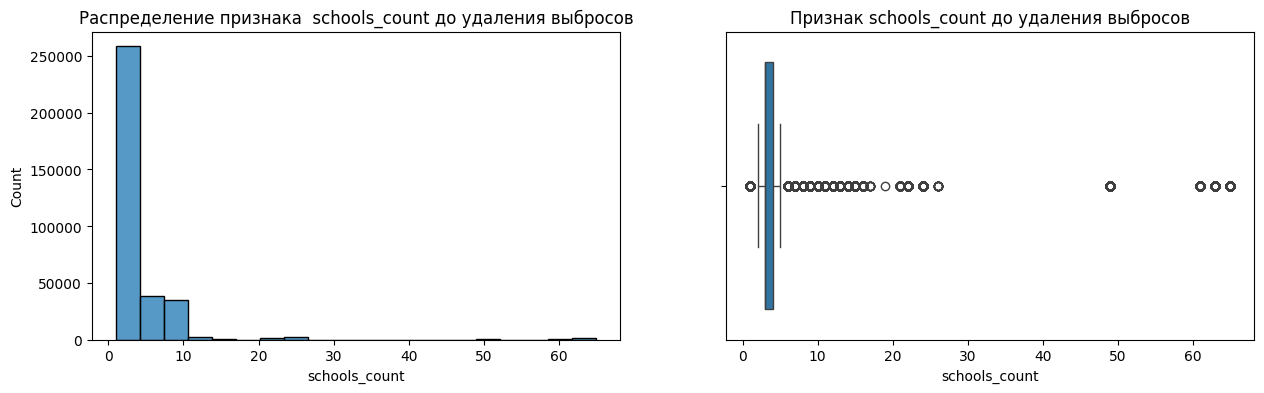

In [194]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_count', bins=20, ax = axes[0]);
histplot.set_title('Распределение признака  schools_count до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_count', ax = axes[1])
boxplot.set_title('Признак schools_count до удаления выбросов')

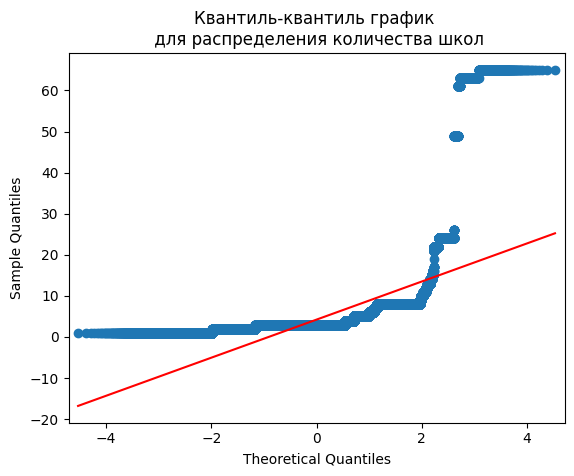

In [195]:
qqplot(data.schools_count, line='s')
plt.title('Квантиль-квантиль график \n для распределения количества школ')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [196]:
alpha=0.5
_,p = stats.normaltest(data['schools_count'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [197]:
outliers, data = outliers_z_score(data, 'schools_count', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 4818
Результирующее число записей: 333592


Text(0.5, 1.0, 'Признак schools_count  удаления выбросов')

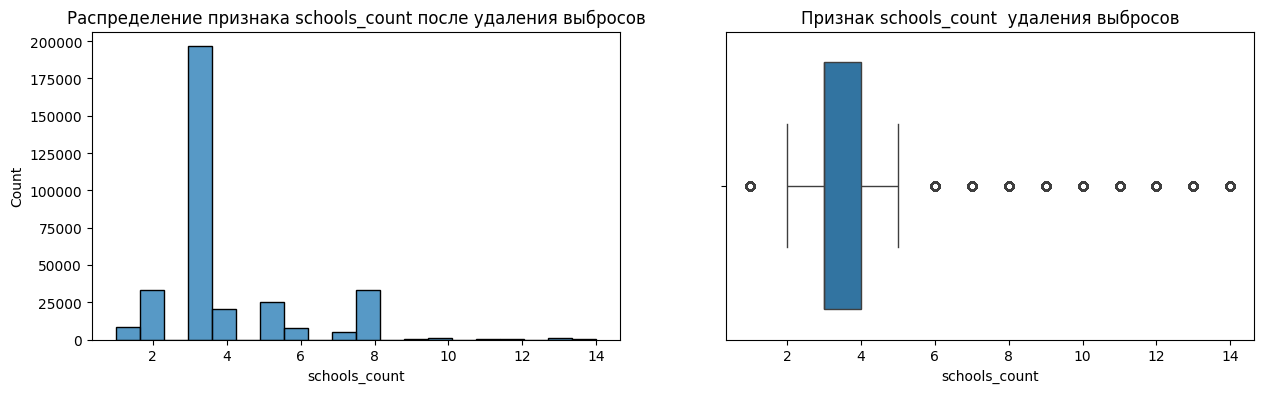

In [198]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_count', bins = 20, ax = axes[0]);
histplot.set_title('Распределение признака schools_count после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_count', ax = axes[1])
boxplot.set_title('Признак schools_count  удаления выбросов')

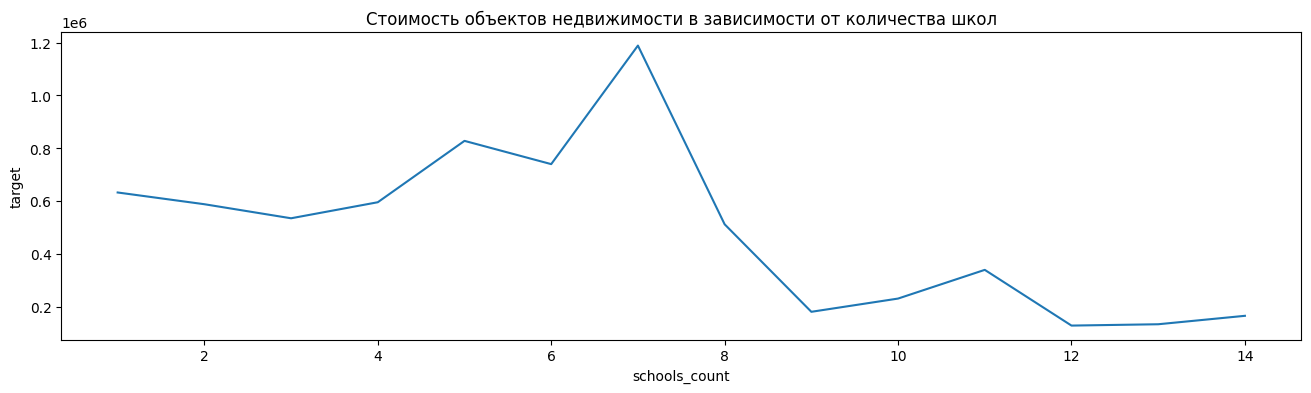

In [199]:
schools_count_data = data.groupby('schools_count', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=schools_count_data, x="schools_count", y="target")
lineplot.set_title('Стоимость объектов недвижимости в зависимости от количества школ');

Количество школ влияет на стоимость недвижимости. Цена растет до 6 школ в районе, затем делает резкий взлет на 7 школах и далее резко падает. Недвижимость с более чем 8 щколами в районе самая дешевая. Возможно клиенты не любят такие районы как раз из-за большого количества школ, а значит детей, подростков и их родителей, которые постоянно будут находится неподалеку.

#### 3.11.2 Признак schools_min_distance — расстояние до ближайшей школы.

Сначала преобразуем признак schools_distance в список чисел, чтобы извлечь из него минимальное расстояние до школы.

In [200]:
data['schools_distance'] = data['schools_distance'].astype(str)
data['schools_distance'] = data['schools_distance'].str.replace('[a-zA-Z]','', regex=True)
data['schools_distance'] = data['schools_distance'].str.findall(r'\b([0-9]+.[0-9]+)')

In [201]:
data['schools_min_distance'] = data['schools_distance'].apply(lambda x: min(x) if len(x) > 0 else np.nan)

In [202]:
# выведем статистику
data['schools_min_distance'].describe()

count     330421
unique      1859
top          0.3
freq       19673
Name: schools_min_distance, dtype: object

In [203]:
# посмотрим на распределение
data['schools_min_distance'].value_counts().nlargest(15)

schools_min_distance
0.3    19673
0.4    18349
0.2    17898
0.5    16457
0.6    13992
0.7    12070
0.1    11237
0.8     9621
0.9     8280
1.1     6574
1.2     5907
1.3     5177
1.4     4486
1.5     4118
1.6     3577
Name: count, dtype: int64

In [204]:
data['schools_min_distance'].isnull().mean()*100

0.9505623636058419

Пропусков совсем мало, заменим их на моду, изменим тип признака на float, найдем и очистим его от выбросов.

In [205]:
data['schools_min_distance'] = data['schools_min_distance'].fillna(data['schools_min_distance'].mode()[0])
data['schools_min_distance'] = data['schools_min_distance'].astype(float)

Text(0.5, 1.0, 'Признак schools_min_distance до удаления выбросов')

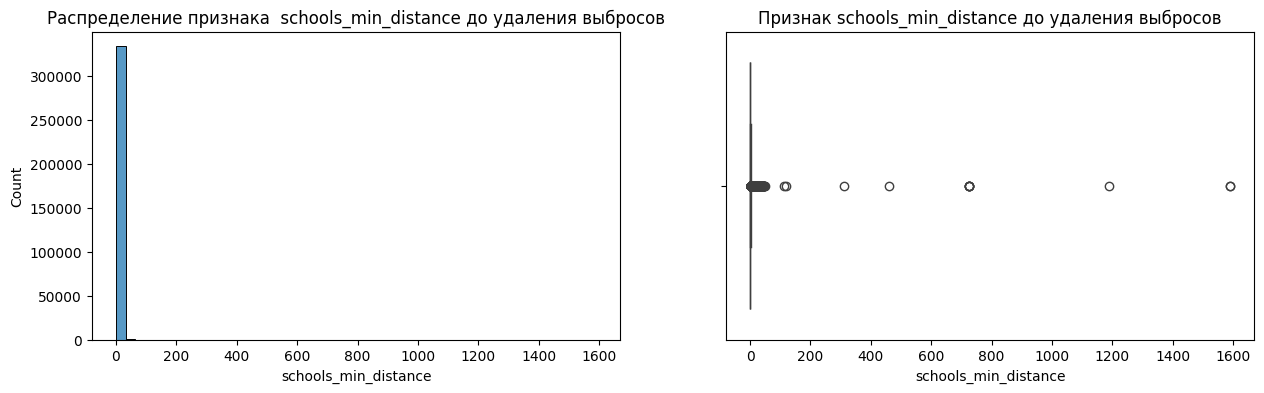

In [206]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_min_distance', bins=50, ax = axes[0]);
histplot.set_title('Распределение признака  schools_min_distance до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_min_distance', ax = axes[1])
boxplot.set_title('Признак schools_min_distance до удаления выбросов')

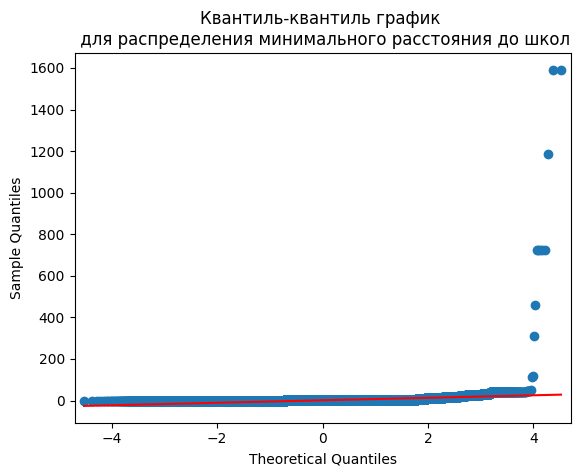

In [207]:
qqplot(data.schools_min_distance, line='s')
plt.title('Квантиль-квантиль график \n для распределения минимального расстояния до школ')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [208]:
alpha=0.5
_,p = stats.normaltest(data['schools_min_distance'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [209]:
outliers, data = outliers_z_score(data, 'schools_min_distance', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 8644
Результирующее число записей: 324948


Text(0.5, 1.0, 'Признак schools_min_distance  удаления выбросов')

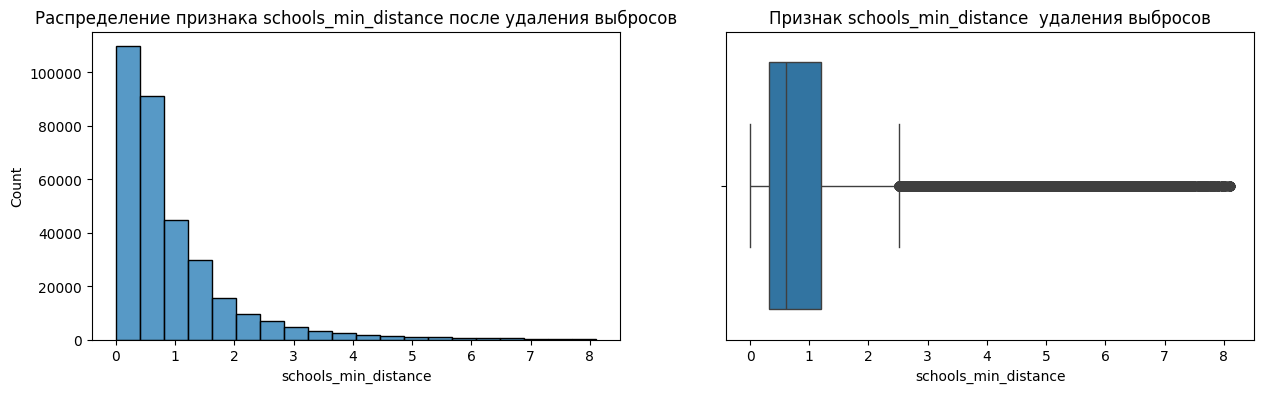

In [210]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_min_distance', bins = 20, ax = axes[0]);
histplot.set_title('Распределение признака schools_min_distance после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_min_distance', ax = axes[1])
boxplot.set_title('Признак schools_min_distance  удаления выбросов')

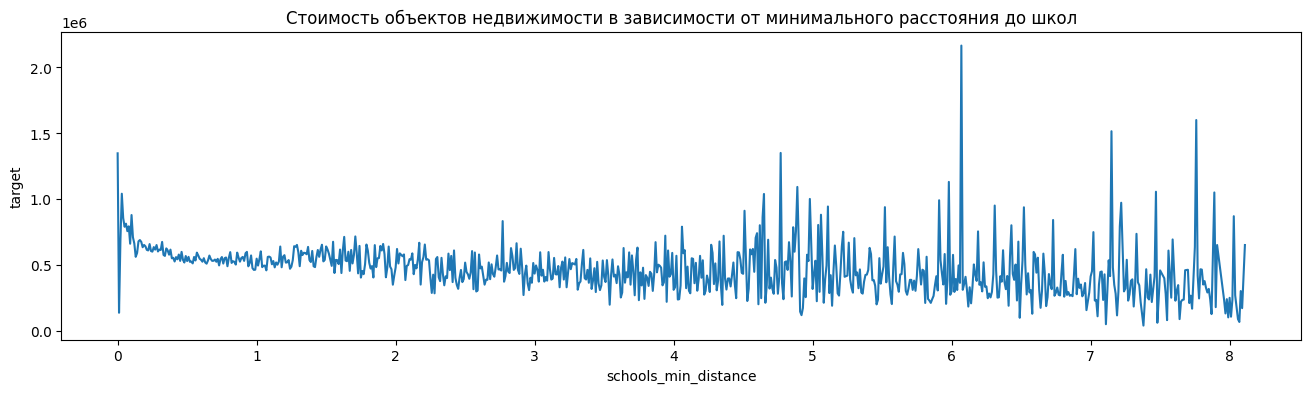

In [211]:
schools_min_distance_data = data.groupby('schools_min_distance', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=schools_min_distance_data, x="schools_min_distance", y="target")
lineplot.set_title('Стоимость объектов недвижимости в зависимости от минимального расстояния до школ');

Визуально сложно определить как минимальное расстояние влияет на стоимость недвижимости. Можно выделить на графике постепенно снижающуюся минимальную цену с увеличением расстояние до школы. Т.е. чем дальше школа, тем ниже минимальная цена, что выглядит логичным. 

#### 3.11.3 Признак schools_average_rating — средний рейтинг школ в районе.

Сначала преобразуем признак schools_rating в список чисел, чтобы извлечь из него средний и максимальный рейтинг школ.

In [212]:
data['schools_rating'] = data['schools_rating'].astype(str)
data['schools_rating'] = data['schools_rating'].str.replace('[a-zA-Z]','', regex=True)
data['schools_rating'] = data['schools_rating'].str.replace('/10','')
data['schools_rating'] = data['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])

In [213]:
data['schools_average_rating'] = data['schools_rating'].apply(lambda x: mean(x) if len(x) > 0 else np.nan)

In [214]:
# выведем статистику
data['schools_average_rating'].describe()

count    321314.000000
mean          5.164466
std           1.955763
min           1.000000
25%           3.666667
50%           5.000000
75%           6.600000
max          10.000000
Name: schools_average_rating, dtype: float64

In [215]:
# посмотрим на распределение
data['schools_average_rating'].value_counts().nlargest(15)

schools_average_rating
6.000000    20575
4.000000    17794
5.000000    16898
3.000000    16181
6.333333    13866
3.333333    13245
7.000000    12304
4.666667    11872
3.666667    11097
4.333333    11083
5.333333    11014
5.666667    10151
8.000000     9869
2.666667     9401
2.000000     9148
Name: count, dtype: int64

In [216]:
data['schools_average_rating'].isnull().mean()*100

1.1183327793985498

Пропусков совсем мало, заменим их на моду, изменим тип признака на float, найдем и очистим его от выбросов.

In [217]:
data['schools_average_rating'] = data['schools_average_rating'].fillna(data['schools_average_rating'].mode()[0])
data['schools_average_rating'] = data['schools_average_rating'].astype(float)

Text(0.5, 1.0, 'Признак schools_average_rating до удаления выбросов')

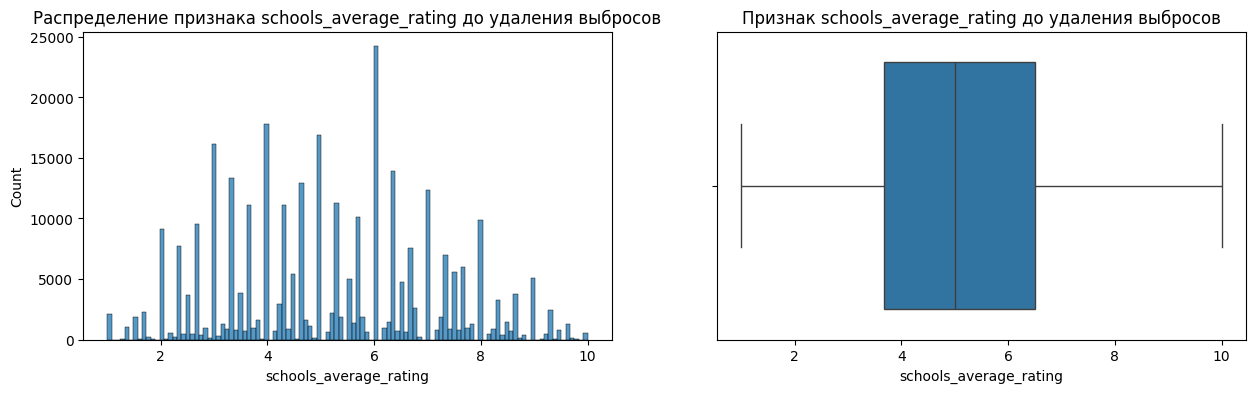

In [218]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_average_rating', ax = axes[0]);
histplot.set_title('Распределение признака schools_average_rating до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_average_rating', ax = axes[1])
boxplot.set_title('Признак schools_average_rating до удаления выбросов')

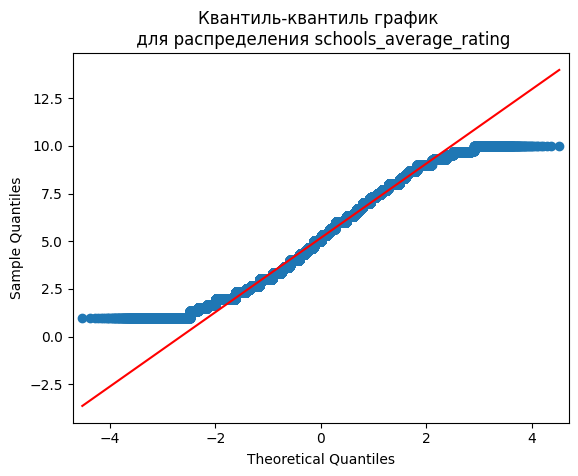

In [219]:
qqplot(data.schools_average_rating, line='s')
plt.title('Квантиль-квантиль график \n для распределения schools_average_rating')
plt.show()

Визуально распределение не выглядит нормальным. Проведем статистический тест на определение нормальности.

In [220]:
alpha=0.5
_,p = stats.normaltest(data['schools_average_rating'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [221]:
outliers, data = outliers_z_score(data, 'schools_average_rating', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {data.shape[0]}')

Число выбросов по методу z-отклонения: 2117
Результирующее число записей: 322831


Text(0.5, 1.0, 'Признак schools_average_rating после удаления выбросов')

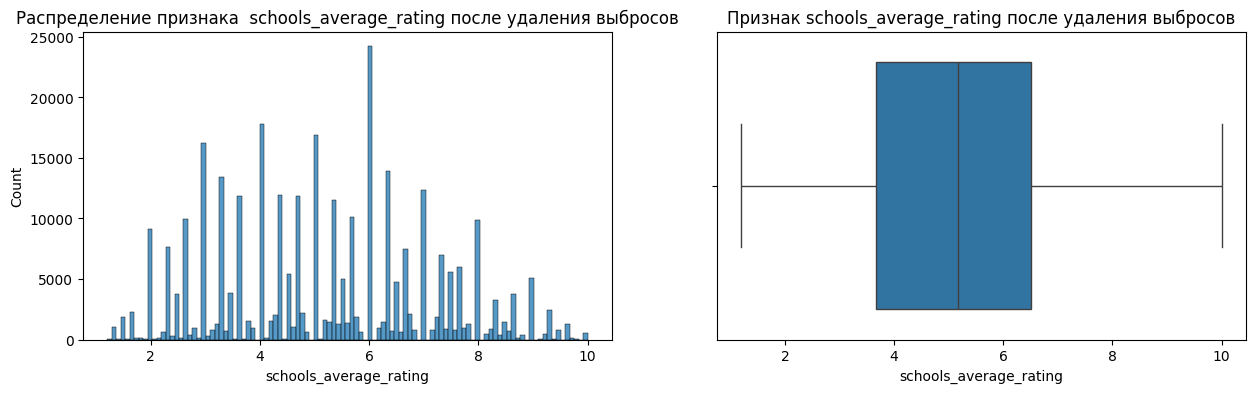

In [222]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_average_rating', ax = axes[0]);
histplot.set_title('Распределение признака  schools_average_rating после удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'schools_average_rating', ax = axes[1])
boxplot.set_title('Признак schools_average_rating после удаления выбросов')

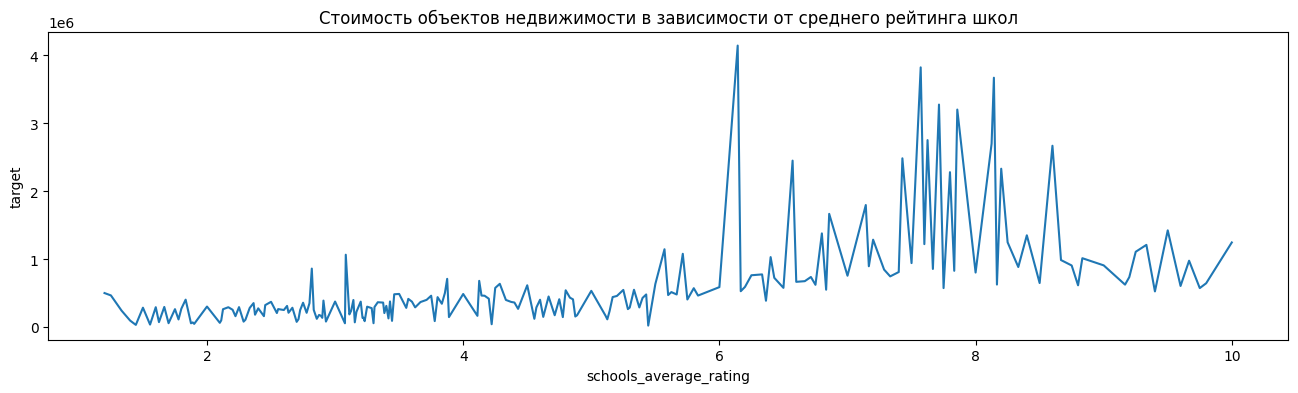

In [223]:
schools_average_rating_data = data.groupby('schools_average_rating', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=schools_average_rating_data, x="schools_average_rating", y="target")
lineplot.set_title('Стоимость объектов недвижимости в зависимости от среднего рейтинга школ');

Как и в случае с минимальным расстояние до школ, визуально сложно определить как стоимость недвижимости зависит от среднего рейтинга школ в районе. Можно отметить постепенное повышение минимальных значений цены с увеличением среднего рейтинга. Так же у недвижимости, в районе которой расположены школы со средним рейтингом более 6 отмечаются резкие всплески стоимости. Логично, что если клиенту нужна школа, то средний рейтинг будет влиять на ее стоимость. И школы с хорошим рейтингом обычно расположены в более благополоучных и дорогих районах.

#### 3.11.4 Признак schools_max_rating — максимальный рейтинг школ в районе.

In [224]:
data['schools_max_rating'] = data['schools_rating'].apply(lambda x: max(x) if len(x) > 0 else np.nan)

In [225]:
# выведем статистику
data['schools_max_rating'].describe()

count    319197.000000
mean          6.721263
std           2.277419
min           2.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          10.000000
Name: schools_max_rating, dtype: float64

In [226]:
# посмотрим на распределение
data['schools_max_rating'].value_counts().nlargest(15)

schools_max_rating
7.0     51634
10.0    49253
6.0     45128
8.0     39197
9.0     35494
4.0     35388
5.0     32288
3.0     23027
2.0      7788
Name: count, dtype: int64

In [227]:
data['schools_max_rating'].isnull().mean()*100

1.125666370329987

Пропусков совсем мало, заменим их на моду, изменим тип признака на int. В призанке всего 9 значений от 2 до 10. Все они актуальны и верны. 

In [228]:
data['schools_max_rating'] = data['schools_max_rating'].fillna(data['schools_max_rating'].mode()[0])
data['schools_max_rating'] = data['schools_max_rating'].astype(int)

Text(0.5, 1.0, 'Признак schools_max_rating')

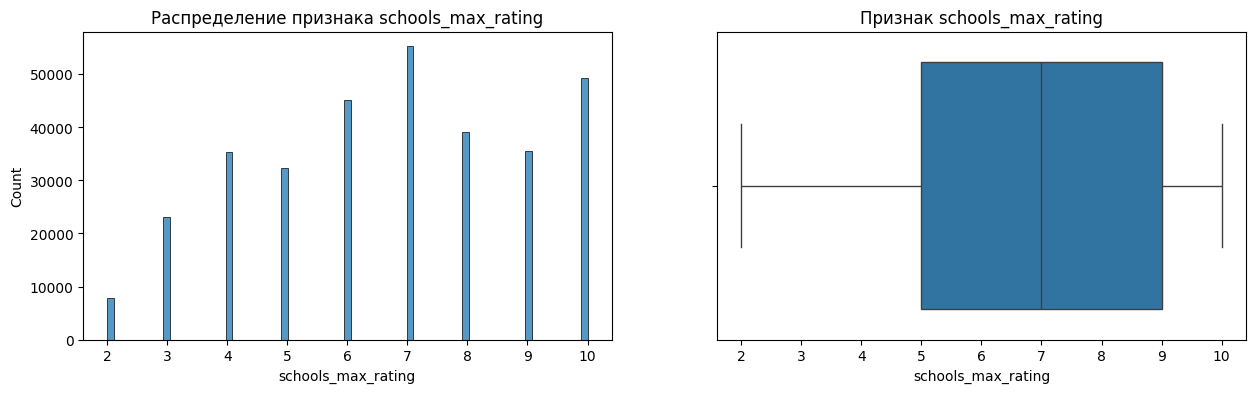

In [229]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'schools_max_rating', ax = axes[0]);
histplot.set_title('Распределение признака schools_max_rating')
boxplot = sns.boxplot( data = data, x = 'schools_max_rating', ax = axes[1])
boxplot.set_title('Признак schools_max_rating')

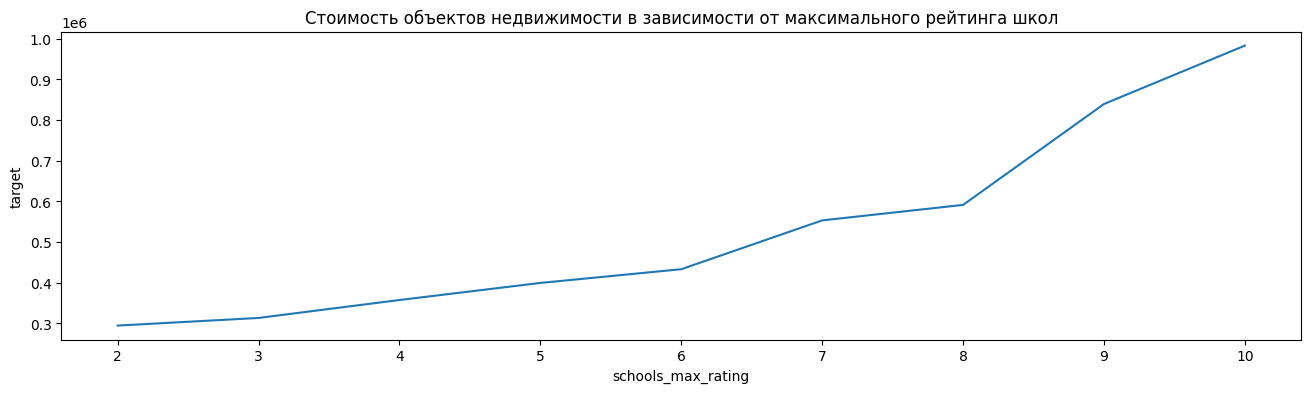

In [230]:
schools_max_rating_data = data.groupby('schools_max_rating', as_index = False)['target'].mean()
fig = plt.figure(figsize = (16,4))
lineplot = sns.lineplot(data=schools_max_rating_data, x="schools_max_rating", y="target")
lineplot.set_title('Стоимость объектов недвижимости в зависимости от максимального рейтинга школ');

Стоимость недвижимости повышается с увеличением макисмального рейтинга школ. Как и в случае со средним рейтингом, это связано с тем, что школы с высоким рейтингом находятся в более престижных районах с дорогой недвижимостью.

In [231]:
# удаляем ненужные признаки
data = data.drop(['schools', 'schools_rating', 'schools_distance'], axis = 1)

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322831 entries, 1 to 377184
Data columns (total 84 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       322831 non-null  float64
 1   sqft                        322831 non-null  int32  
 2   beds                        322831 non-null  int32  
 3   target                      322831 non-null  float64
 4   street_ln                   322831 non-null  int64  
 5   street_ave                  322831 non-null  int64  
 6   street_st                   322831 non-null  int64  
 7   street_unkown               322831 non-null  int64  
 8   street_dr                   322831 non-null  int64  
 9   street_rd                   322831 non-null  int64  
 10  street_pl                   322831 non-null  int64  
 11  street_hl                   322831 non-null  int64  
 12  street_blw                  322831 non-null  int64  
 13  street_hwy         

В итоге получили 84 признака с типом данных float и int. Сохраним полученный датасет.

In [233]:
data.to_csv('data/data_cleaned.csv', index=False)

### 4. Решение задачи регрессии.

In [234]:
# загружаем данные
data_cleaned = pd.read_csv('data/data_cleaned.csv')
data_cleaned.head()

baths  sqft  beds     target  street_ln  street_ave  street_st  \
0    3.0  1947     3   310000.0          0           1          0   
1    2.0  3000     3  2895000.0          0           0          1   
2    8.0  6457     5  2395000.0          0           1          0   
3    2.0   897     2   209000.0          0           0          1   
4    2.0  1507     3   181500.0          0           0          0   

   street_unkown  street_dr  street_rd  ...  cooling_central electric  \
0              0          0          0  ...                         0   
1              0          0          0  ...                         0   
2              0          0          0  ...                         0   
3              0          0          0  ...                         0   
4              1          0          0  ...                         0   

   cooling_has cooling  cooling_none  cooling_wall  cooling_cooling system  \
0                    0             0             0                       0   
1                    0             0             0                       0   
2                    0             0             0                       0   
3                    0             0             0                       0   
4                    0             0             0                       0   

   cooling_None  schools_count  schools_min_distance  schools_average_rating  \
0             0              3                  1.01                4.000000   
1             0              3                  1.19                6.666667   
2             0              4                  0.10                9.250000   
3             0              3                  0.30                6.000000   
4             0              4                  0.80                2.333333   

   schools_max_rating  
0                   4  
1                   8  
2                  10  
3                   7  
4                   3  

[5 rows x 84 columns]

Построим корреляционную матрицу, чтобы оценить данные на предмет мультиколлинеарности.

baths      sqft      beds    target  street_ln  \
baths                   1.000000  0.282514  0.607095  0.414117   0.046958   
sqft                    0.282514  1.000000  0.228254  0.221383   0.020996   
beds                    0.607095  0.228254  1.000000  0.221163   0.039078   
target                  0.414117  0.221383  0.221163  1.000000  -0.026989   
street_ln               0.046958  0.020996  0.039078 -0.026989   1.000000   
...                          ...       ...       ...       ...        ...   
cooling_None           -0.035059 -0.011271 -0.020617 -0.016034  -0.000294   
schools_count          -0.059269 -0.005061 -0.003539  0.010763   0.014557   
schools_min_distance    0.054513  0.026951  0.014975 -0.047627   0.038951   
schools_average_rating  0.215499  0.125200  0.114733  0.247228   0.047717   
schools_max_rating      0.157413  0.092876  0.054985  0.239111   0.023717   

                        street_ave  street_st  street_unkown  street_dr  \
baths                    -0.055211  -0.063247       0.029186   0.038386   
sqft                     -0.032086  -0.020565       0.011302   0.014637   
beds                     -0.039742  -0.058599       0.014886   0.029324   
target                    0.013675   0.012533       0.033796  -0.022059   
street_ln                -0.119008  -0.149518      -0.126294  -0.122873   
...                            ...        ...            ...        ...   
cooling_None             -0.018648   0.013756       0.011059  -0.005521   
schools_count            -0.000351   0.005047       0.002090   0.002088   
schools_min_distance     -0.111154  -0.133573       0.061644   0.062488   
schools_average_rating   -0.082822  -0.125887       0.109712   0.039750   
schools_max_rating       -0.037474  -0.071619       0.078137   0.021465   

                        street_rd  ...  cooling_central electric  \
baths                   -0.000965  ...                 -0.034937   
sqft                     0.009589  ...                 -0.010526   
beds                     0.003681  ...                 -0.011488   
target                  -0.011171  ...                 -0.042764   
street_ln               -0.079039  ...                  0.041463   
...                           ...  ...                       ...   
cooling_None             0.010908  ...                 -0.014735   
schools_count            0.004769  ...                  0.198210   
schools_min_distance     0.089761  ...                 -0.006753   
schools_average_rating   0.016207  ...                 -0.021920   
schools_max_rating      -0.012067  ...                  0.018794   

                        cooling_has cooling  cooling_none  cooling_wall  \
baths                             -0.081360     -0.046103     -0.045343   
sqft                              -0.015256     -0.025804     -0.028456   
beds                              -0.038767     -0.010553     -0.042790   
target                             0.032631     -0.020666     -0.017964   
street_ln                         -0.021142     -0.023371     -0.020044   
...                                     ...           ...           ...   
cooling_None                      -0.016544     -0.014156     -0.010938   
schools_count                      0.091309     -0.064591     -0.044417   
schools_min_distance              -0.023641     -0.048684     -0.029360   
schools_average_rating             0.076982     -0.084970     -0.029339   
schools_max_rating                 0.176799     -0.096396     -0.025366   

                        cooling_cooling system  cooling_None  schools_count  \
baths                                 0.021690     -0.035059      -0.059269   
sqft                                  0.011322     -0.011271      -0.005061   
beds                                  0.012437     -0.020617      -0.003539   
target                                0.000660     -0.016034       0.010763   
street_ln                             0.007734     -0.000294       0.014557   
...      

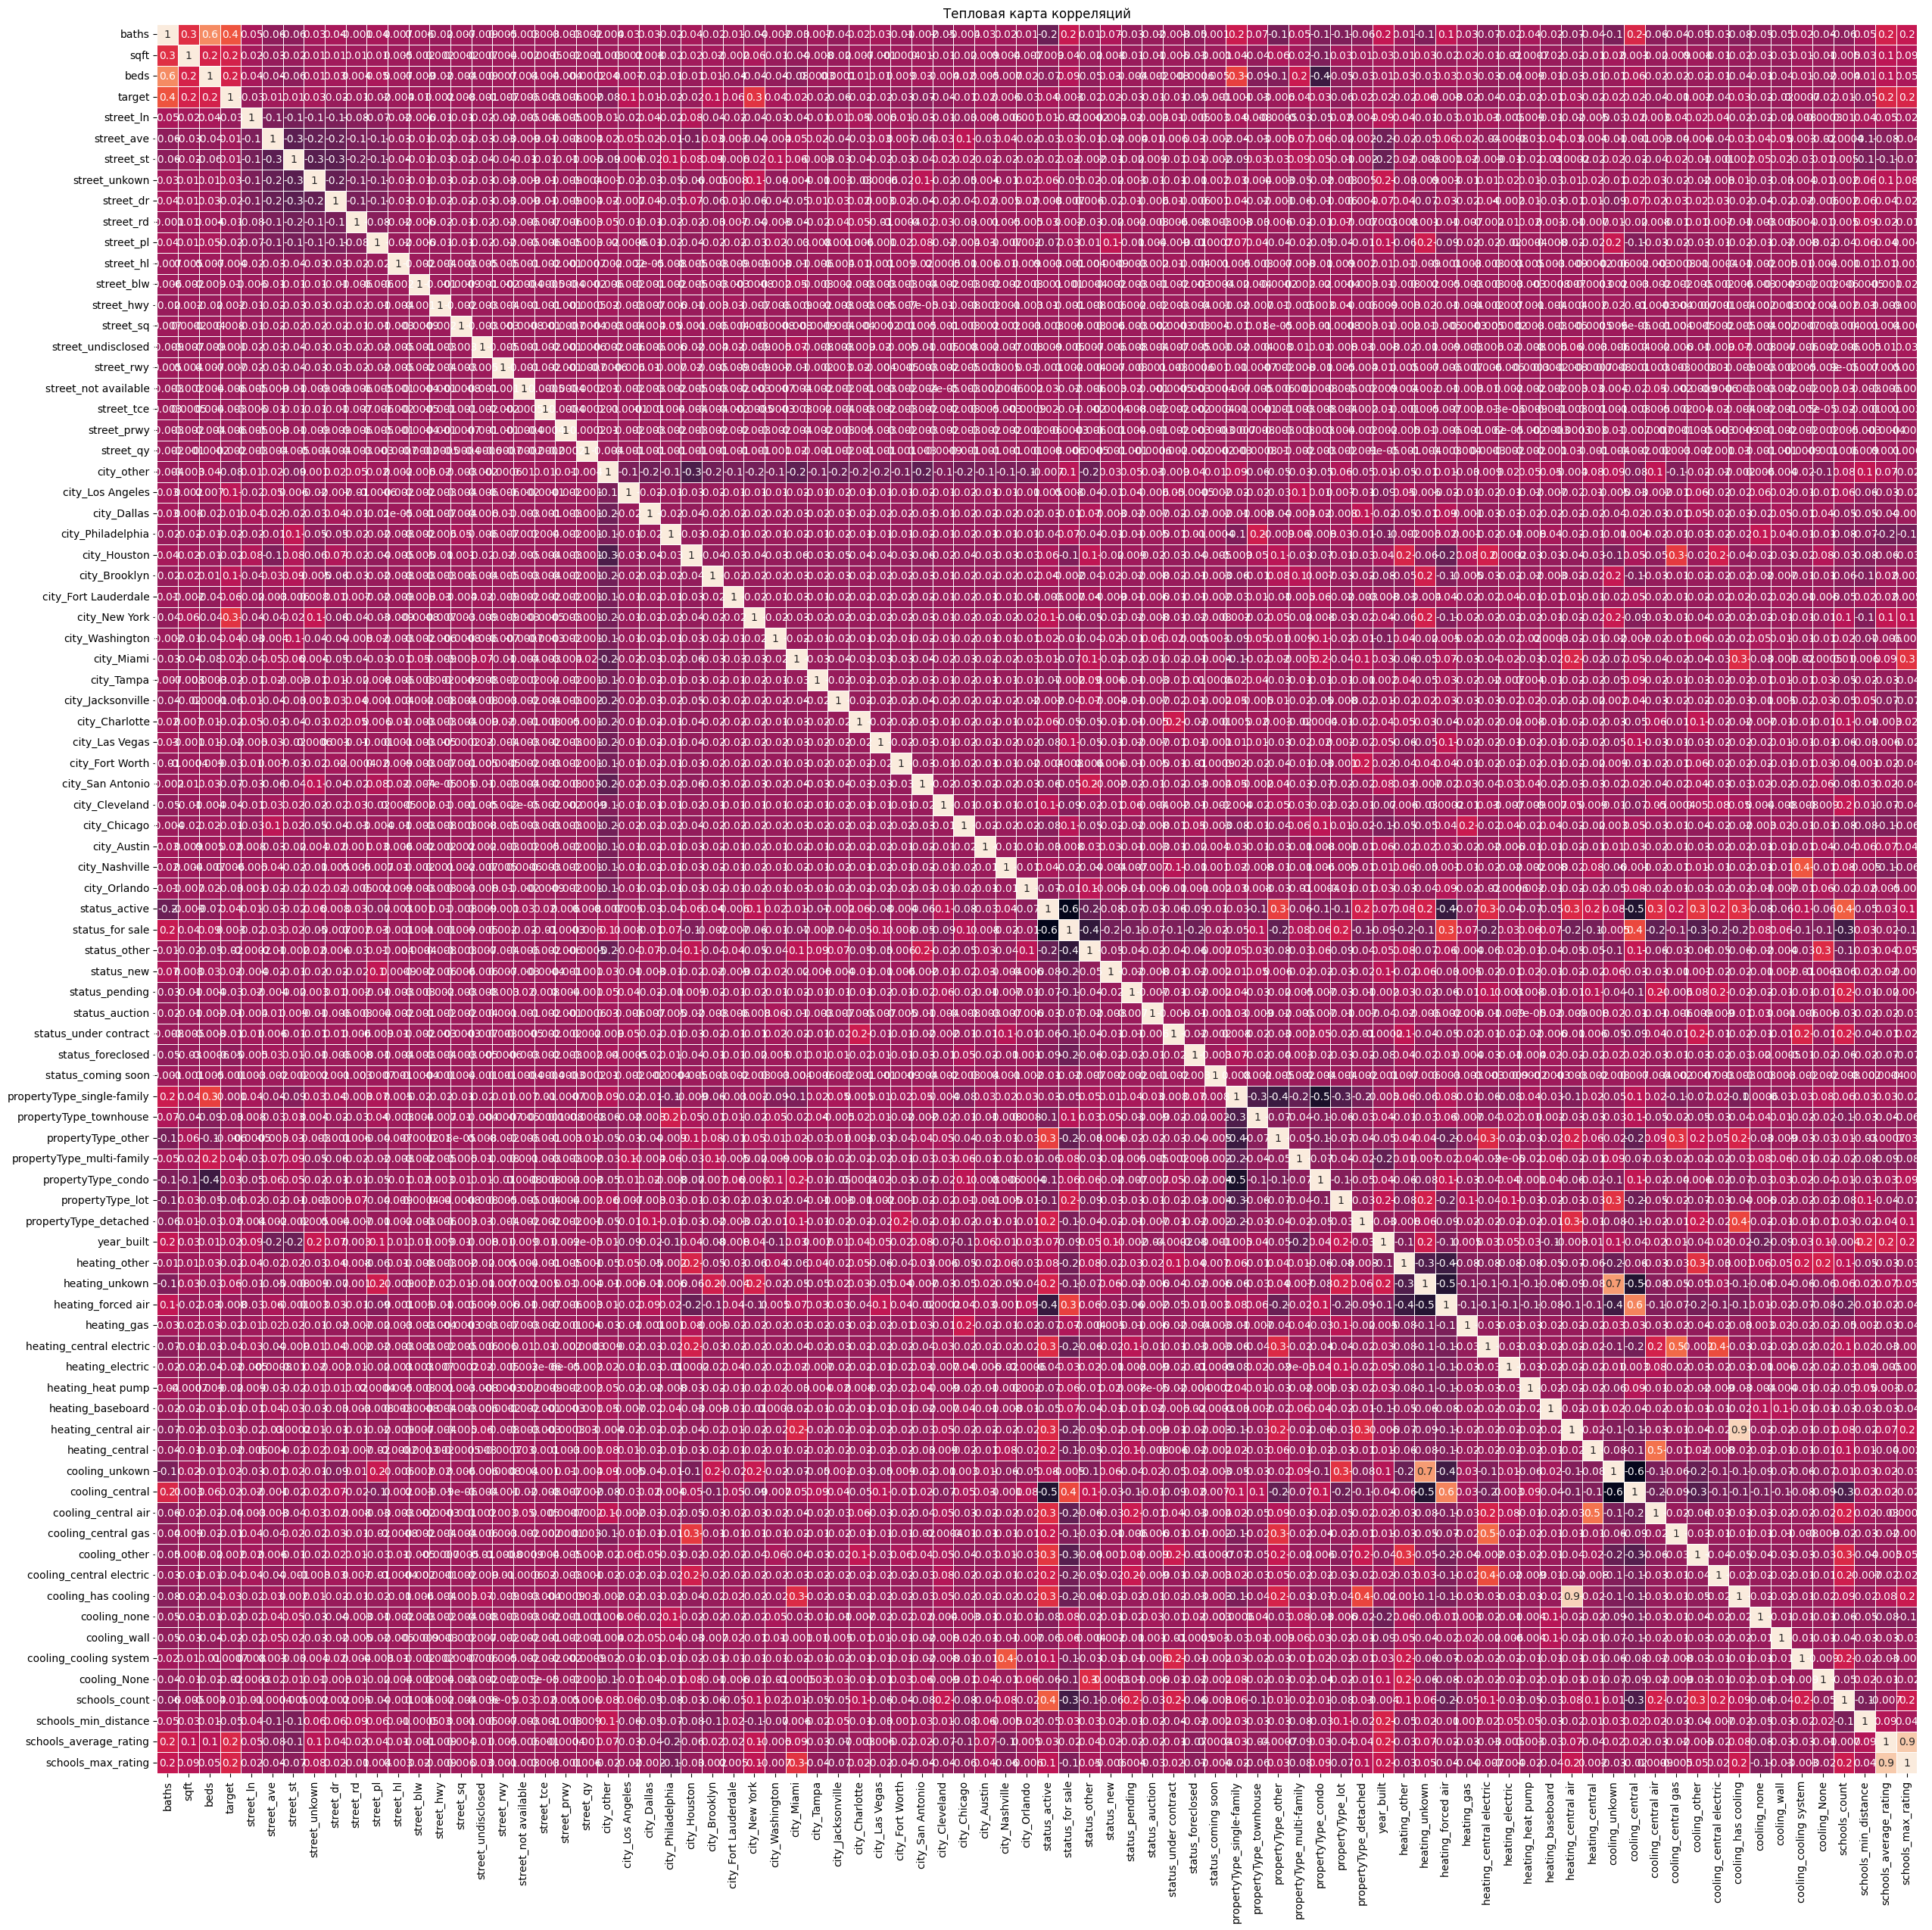

In [235]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data_cleaned.corr(), linewidth=.5, annot=True, fmt='.1g', cbar=False, ax=ax)
ax.set_title('Тепловая карта корреляций')
data_cleaned.corr()

Удалим признаки с коэффициентом корреляции больше +/- 0.7:
 - 0.7 cooling_unkown и heating_unkown
 - 0.9 cooling_has cooling и heating_central air
 - 0.9 schools_average_rating и schools_max_rating

In [236]:
data_cleaned = data_cleaned.drop(['cooling_unkown', 'heating_central air', 'schools_average_rating'], axis = 1)

Сформируем матрицу наблюдений X, вектор целевой переменной y. Разобьем выборку на обучающую и тестовую в соотношении 80/20.

In [237]:
X = data_cleaned.drop('target', axis=1)
y = data_cleaned['target']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,  random_state = 42, test_size = 0.2)
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 258264
Размер тестовой выборки: 64567


У нас 81 признак, отберем 60, наилучшим образом подходящих для предсказания целевой переменной.

Построение моделей на основе не всех признаков ухудшал результаты, поэтому в итоговом варианте оставлены все признаки. Но это не позволило строить модели на полиномиальных признаках. При этом такие модели на отобранных признаках показывали худшие результаты, чем случайный лес, градиентный бустинг и cat бустинг.

In [238]:
# отбираем признаки
#selector = feature_selection.SelectKBest(
#    score_func = feature_selection.f_regression,
#    k = 60
#)
#selector.fit(X_train, y_train)

# оставляем только полученные 60 признаков
#best_features = selector.get_feature_names_out()
#X_train = X_train[best_features]
#X_test = X_test[best_features]
#print('Признаки, которые вошли в список отобранных:\n', best_features)

In [239]:
# нормализуем данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
X_train_sc = mm_scaler.fit_transform(X_train)
X_test_sc = mm_scaler.transform(X_test)

#### 4.1 Линейная регрессия.

Обучим самую простую модель линейной регрессии с параметрами по умолчанию.

В качестве метрики будем использовать:
 - R2 - коэффициент детерминации (какую долю разнообразия смогла уловить модель в данных). Показывает насколько модель лучше, чем если бы все предсказания были средними.
Такой выбор сделан, так как у нас нет данных о том какая ошибка в реальных числах или процентах будет считаться приемлимой. Для R2 удовлетворительным считается показатель выше 0.5.

In [240]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_sc, y_train)
y_train_predict_lr = lr_model.predict(X_train_sc)
y_test_predict_lr = lr_model.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_lr),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_lr),3)}')

R2 train score:0.356
R2 test score:0.357


Модель линейной регрессии слабая, метрики низкие.
Использум кросс-валидацию.

In [241]:
#Создаём модель
model = linear_model.LinearRegression()
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, 
    X=X, 
    y=y, 
    cv=kf, 
    scoring='r2', 
    return_train_score=True 
)
print('Train k-fold mean R2: {:.3f}'.format(np.mean(cv_metrics['train_score'])))
print('Test k-fold mean R2: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean R2: 0.356
Test k-fold mean R2: 0.356


Метрика R2 при использовании кросс-валидации не улучшилась. Используем полиномиальную регрессию.

In [242]:
#poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#poly.fit(X_train_sc)
#X_train_poly = poly.transform(X_train_sc)
#X_test_poly = poly.transform(X_test_sc)
#lr_model_poly = linear_model.LinearRegression()
#lr_model_poly.fit(X_train_poly, y_train)
#y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#y_test_predict_poly = lr_model_poly.predict(X_test_poly)
#print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_poly),3)}')
#print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_poly),3)}')

При использовании полинимиальной регрессии метрики на обучающей выборке улучшились, а на тестовой намного ухудшились. Используем регуляризацию.

In [243]:
#lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#lasso_lr_poly.fit(X_train_poly, y_train)
#y_train_predict_lasso = lasso_lr_poly.predict(X_train_poly)
#y_test_predict_lasso = lasso_lr_poly.predict(X_test_poly)
#print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_lasso),3)}')
#print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_lasso),3)}')

Использование L1 регуляризации решило проблему переобучения, повысило качество модели и улучшило метрики.

#### 4.2 Дерево решений.

Построим модель дерева решений с параметрами по умолчанию.

In [244]:
dtr_model = tree.DecisionTreeRegressor(random_state=42)
dtr_model.fit(X_train_sc, y_train)
y_train_predict_dtr = dtr_model.predict(X_train_sc)
y_test_predict_dtr = dtr_model.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_dtr),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_dtr),3)}')

R2 train score:0.931
R2 test score:0.366


На тренировочной выборке получились прекрасные результаты, а на тестовой метрики намного хуже - налицо переобучение. Воспользуемся GridSearch для подбора оптимальных параметров для дерева решений.

In [245]:
param_grid = {
    'min_samples_split': list(np.linspace(5, 40, 5, dtype=int)),
    'max_depth': list(np.linspace(5, 30, 5, dtype=int))
    }
grid_search = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_sc, y_train)
print(f'Наилучшее значение параметров: {grid_search.best_params_}')
%time grid_search.fit(X_train_sc, y_train)

Наилучшее значение параметров: {'max_depth': 17, 'min_samples_split': 40}
CPU times: total: 7.06 s
Wall time: 3min 54s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 11, 17, 23, 30],
                         'min_samples_split': [5, 13, 22, 31, 40]})

In [246]:
y_train_pred_gs = grid_search.predict(X_train_sc)
y_test_pred_gs = grid_search.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_pred_gs),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_pred_gs),3)}')

R2 train score:0.659
R2 test score:0.531


Подбор гиперпараметров решил проблему переобучения и улучшил метрики.

#### 4.3 Случайный лес

Построим модель случайного леса с параметрами:
- n_estimators=200,
- max_depth=14,
- min_samples_split=20,
- random_state=42

In [247]:
rf_model = ensemble.RandomForestRegressor(
                                         n_estimators=200, 
                                         max_depth=14, 
                                         min_samples_split=20,
                                         random_state=42
                                         )
rf_model.fit(X_train_sc, y_train)
y_train_pred_rf = rf_model.predict(X_train_sc)
y_test_pred_rf = rf_model.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_pred_rf),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_pred_rf),3)}')

R2 train score:0.67
R2 test score:0.594


Случайный лес помог улучшить метрики.

Подберем параметры случайного леса с помощью Optuna

In [248]:
def optuna_rf(trial):
  
  """Функция, обучающая модель RandomForestRegressor
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score: метрика R2
      """
  
  n_estimators = trial.suggest_int('n_estimators', 40, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 29, 2)
  min_samples_leaf = trial.suggest_int('min_samples_split', 5, 40, 5)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_sc, y_train)
  score = metrics.r2_score(y_train, model.predict(X_train_sc))

  return score

!!! Код может выполняться более 60 минут!!!

In [249]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2025-01-15 13:47:17,008] A new study created in memory with name: RandomForestRegressor
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\2948875437.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\2948875437.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 5, 29, 2)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\2948875437.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_split', 5, 40, 5)
[I 2025-01-15 13:55:40,452] Trial 0 finished with value: 0.6277186619657256 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_sa

Наилучшие значения гиперпараметров {'n_estimators': 80, 'max_depth': 23, 'min_samples_split': 5}
CPU times: total: 1h 49min 15s
Wall time: 1h 49min 38s


In [250]:
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42, )
model.fit(X_train_sc, y_train)
y_train_pred_opt = model.predict(X_train_sc)
y_test_pred_opt = model.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_pred_opt),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_pred_opt),3)}')

R2 train score:0.825
R2 test score:0.631


С подобранными с помощью Оптуна параметрами метрики еще повысились.

#### 4.4 Градиентный бустинг.

In [251]:
gb_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    min_samples_split=10,
    verbose=True,
    random_state=42
)
gb_model.fit(X_train_sc, y_train)
y_train_predict_gb = gb_model.predict(X_train_sc)
y_test_predict_gb = gb_model.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_gb),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_gb),3)}')

      Iter       Train Loss   Remaining Time 
         1 701671090733.6157            9.04m
         2 626997051593.3916            8.94m
         3 565178516980.1053            8.93m
         4 514640874566.6341            8.94m
         5 472273158122.5176            8.88m
         6 437129241897.0589            8.76m
         7 407534436588.9556            8.71m
         8 382099833728.8314            8.63m
         9 360551086550.6508            8.61m
        10 342967300189.0700            8.55m
        20 254133616872.5383            8.55m
        30 224886307412.7763            7.89m
        40 209938822974.6193            7.27m
        50 201909162843.3615            6.65m
        60 195741153043.4479            6.09m
        70 190573905413.4665            5.55m
        80 186247598862.8854            5.06m
        90 182315499692.5273            4.58m
       100 179109544994.0197            4.12m
       200 154139460865.6937            0.00s
R2 train score:0.806
R2 test score

In [252]:
def optuna_gb(trial):
  
  """Функция, обучающая модель GradientBoostingRegressor
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score: метрика R2
      """
  
  n_estimators = trial.suggest_int('n_estimators', 20, 200, 20)
  max_depth = trial.suggest_int('max_depth', 1, 9, 1)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 1)

  # создаем модель
  model_gb = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          learning_rate=learning_rate,
                                          random_state=42)
  # обучаем модель
  model_gb.fit(X_train_sc, y_train)
  score = metrics.r2_score(y_train, model_gb.predict(X_train_sc))

  return score

In [253]:
%%time
# cоздаем объект исследования
study_gb = optuna.create_study(study_name="GradientBoostingRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_gb.optimize(optuna_gb, n_trials=15)
print("Наилучшие значения гиперпараметров {}".format(study_gb.best_params))

[I 2025-01-15 15:49:44,029] A new study created in memory with name: GradientBoostingRegressor
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\3937763502.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 20, 200, 20)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\3937763502.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 1, 9, 1)
[I 2025-01-15 15:54:12,927] Trial 0 finished with value: 0.870326167496962 and parameters: {'n_estimators': 140, 'max_depth': 9, 'learning_rate': 0.7149793983079469}. Best is trial 0 with value: 0.870326167496962.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\3937763502.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword ar

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 9, 'learning_rate': 0.9704780913414007}
CPU times: total: 43min 20s
Wall time: 43min 25s


In [254]:
model_gb = ensemble.GradientBoostingRegressor(**study_gb.best_params,random_state=42, )
model_gb.fit(X_train_sc, y_train)
y_train_pred_opt_gb = model_gb.predict(X_train_sc)
y_test_pred_opt_gb = model_gb.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_pred_opt_gb),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_pred_opt_gb),3)}')

R2 train score:0.874
R2 test score:0.47


Подбор параметров градиентного бустинга с помощью optuna не улучшил метрики на тестовой выборке.

#### 4.5 Cat бустинг

In [255]:
regressor = CatBoostRegressor(iterations=200, depth=14, learning_rate=0.4, random_state=42)
regressor.fit(X_train_sc, y_train, verbose=False)

y_train_predict_cat = regressor.predict(X_train_sc)
y_test_predict_cat = regressor.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_predict_cat),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_predict_cat),3)}')

R2 train score:0.823
R2 test score:0.647


In [256]:
def optuna_cat(trial):
  
  """Функция, обучающая модель CatBoostRegressor
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score: метрика R2
      """
  
  iterations = trial.suggest_int('iterations', 40, 200, 10)
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)
  learning_rate = trial.suggest_float('learning_rate', 0.05, 1)

  # создаем модель
  model_cat = CatBoostRegressor(iterations=iterations,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                random_state=42)
  # обучаем модель
  model_cat.fit(X_train_sc, y_train)
  score = metrics.r2_score(y_train, model_cat.predict(X_train_sc))

  return score

In [257]:
%%time
# cоздаем объект исследования
study_cat = optuna.create_study(study_name="CatBoostRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_cat.optimize(optuna_cat, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study_cat.best_params))

[I 2025-01-15 16:38:51,594] A new study created in memory with name: CatBoostRegressor
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 639503.2179622	total: 1.5s	remaining: 4m 27s
1:	learn: 582836.2764246	total: 2.77s	remaining: 4m 6s
2:	learn: 563011.2034355	total: 4.17s	remaining: 4m 6s
3:	learn: 542355.1656988	total: 5.62s	remaining: 4m 7s
4:	learn: 529278.5923760	total: 6.96s	remaining: 4m 3s
5:	learn: 521380.2267601	total: 8.27s	remaining: 3m 59s
6:	learn: 514406.8909639	total: 9.61s	remaining: 3m 57s
7:	learn: 510223.5298765	total: 10.9s	remaining: 3m 55s
8:	learn: 504077.9599402	total: 12.2s	remaining: 3m 51s
9:	learn: 496725.8248574	total: 13.6s	remaining: 3m 50s
10:	learn: 492762.7587100	total: 15s	remaining: 3m 49s
11:	learn: 490447.4250080	total: 16.4s	remaining: 3m 50s
12:	learn: 485670.8079036	total: 17.8s	remaining: 3m 48s
13:	learn: 482340.2302413	total: 19s	remaining: 3m 45s
14:	learn: 477580.6607681	total: 20.2s	remaining: 3m 42s
15:	learn: 474417.0938813	total: 21.6s	remaining: 3m 41s
16:	learn: 473055.3336500	total: 22.8s	remaining: 3m 38s
17:	learn: 470230.3547575	total: 24.1s	remaining: 

[I 2025-01-15 16:42:59,200] Trial 0 finished with value: 0.8845500533121429 and parameters: {'iterations': 180, 'max_depth': 16, 'learning_rate': 0.8472655582717753}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 642484.6314303	total: 99.3ms	remaining: 5.86s
1:	learn: 605029.7867437	total: 197ms	remaining: 5.71s
2:	learn: 590636.9298410	total: 289ms	remaining: 5.48s
3:	learn: 578137.7935910	total: 402ms	remaining: 5.63s
4:	learn: 566012.4198564	total: 511ms	remaining: 5.62s
5:	learn: 559986.7806252	total: 616ms	remaining: 5.54s
6:	learn: 554264.5951427	total: 735ms	remaining: 5.57s
7:	learn: 551257.5683430	total: 842ms	remaining: 5.47s
8:	learn: 549011.2409614	total: 951ms	remaining: 5.39s
9:	learn: 546386.1164795	total: 1.05s	remaining: 5.24s
10:	learn: 541771.1544523	total: 1.16s	remaining: 5.14s
11:	learn: 538394.3273730	total: 1.25s	remaining: 5.01s
12:	learn: 533339.0770398	total: 1.36s	remaining: 4.93s
13:	learn: 528543.9495961	total: 1.48s	remaining: 4.87s
14:	learn: 525551.3203772	total: 1.61s	remaining: 4.83s
15:	learn: 522102.3617332	total: 1.77s	remaining: 4.88s
16:	learn: 519451.1032066	total: 1.88s	remaining: 4.76s
17:	learn: 518325.1481846	total: 1.97s	remaining: 4.6s
18

[I 2025-01-15 16:43:06,389] Trial 1 finished with value: 0.7472239239071833 and parameters: {'iterations': 60, 'max_depth': 12, 'learning_rate': 0.9440509378514729}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 792773.2633550	total: 49.6ms	remaining: 7.38s
1:	learn: 732104.3290836	total: 74.6ms	remaining: 5.52s
2:	learn: 692418.1158046	total: 96.7ms	remaining: 4.74s
3:	learn: 669893.5328520	total: 117ms	remaining: 4.26s
4:	learn: 652566.7226308	total: 140ms	remaining: 4.05s
5:	learn: 640424.2499457	total: 162ms	remaining: 3.9s
6:	learn: 631630.2249364	total: 184ms	remaining: 3.76s
7:	learn: 625257.6703538	total: 206ms	remaining: 3.66s
8:	learn: 620035.7460415	total: 228ms	remaining: 3.57s
9:	learn: 614757.0342323	total: 251ms	remaining: 3.51s
10:	learn: 611976.2227729	total: 274ms	remaining: 3.46s
11:	learn: 608632.2615391	total: 296ms	remaining: 3.4s
12:	learn: 605709.8251555	total: 318ms	remaining: 3.35s
13:	learn: 603098.5281356	total: 338ms	remaining: 3.28s
14:	learn: 600128.6178760	total: 358ms	remaining: 3.23s
15:	learn: 597748.2872543	total: 379ms	remaining: 3.17s
16:	learn: 595767.1691433	total: 399ms	remaining: 3.12s
17:	learn: 594091.5605648	total: 421ms	remaining: 3.09s
1

[I 2025-01-15 16:43:10,447] Trial 2 finished with value: 0.6379624187414309 and parameters: {'iterations': 150, 'max_depth': 6, 'learning_rate': 0.32574933462286454}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 676668.7667235	total: 27.1ms	remaining: 4.31s
1:	learn: 634018.4006572	total: 56.2ms	remaining: 4.44s
2:	learn: 620484.3200464	total: 84.2ms	remaining: 4.41s
3:	learn: 609981.3997975	total: 111ms	remaining: 4.33s
4:	learn: 600360.4041958	total: 138ms	remaining: 4.29s
5:	learn: 594259.7550669	total: 166ms	remaining: 4.25s
6:	learn: 589531.2396844	total: 192ms	remaining: 4.2s
7:	learn: 585285.9487112	total: 222ms	remaining: 4.21s
8:	learn: 582818.2249199	total: 249ms	remaining: 4.18s
9:	learn: 580270.4026048	total: 279ms	remaining: 4.18s
10:	learn: 578252.4625833	total: 304ms	remaining: 4.12s
11:	learn: 575400.3422255	total: 332ms	remaining: 4.09s
12:	learn: 573216.2021534	total: 358ms	remaining: 4.05s
13:	learn: 571411.2963893	total: 384ms	remaining: 4s
14:	learn: 568563.2726856	total: 411ms	remaining: 3.98s
15:	learn: 566954.7234652	total: 437ms	remaining: 3.93s
16:	learn: 565395.9182553	total: 464ms	remaining: 3.9s
17:	learn: 563108.0374282	total: 493ms	remaining: 3.89s
18:	

[I 2025-01-15 16:43:15,634] Trial 3 finished with value: 0.7192726728425104 and parameters: {'iterations': 160, 'max_depth': 8, 'learning_rate': 0.9135228587518248}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 771054.8174321	total: 17.2ms	remaining: 2.91s
1:	learn: 721702.8222463	total: 38.6ms	remaining: 3.25s
2:	learn: 692106.7587035	total: 58.2ms	remaining: 3.24s
3:	learn: 671782.6842965	total: 74.9ms	remaining: 3.11s
4:	learn: 660226.7412625	total: 92.3ms	remaining: 3.05s
5:	learn: 649969.7210181	total: 110ms	remaining: 3.01s
6:	learn: 641086.0112670	total: 128ms	remaining: 2.99s
7:	learn: 632323.3454376	total: 147ms	remaining: 2.98s
8:	learn: 628188.4297254	total: 168ms	remaining: 3s
9:	learn: 625225.1659602	total: 194ms	remaining: 3.11s
10:	learn: 622088.2111984	total: 216ms	remaining: 3.12s
11:	learn: 619011.4776011	total: 235ms	remaining: 3.1s
12:	learn: 616740.2519523	total: 260ms	remaining: 3.14s
13:	learn: 614827.5064472	total: 285ms	remaining: 3.17s
14:	learn: 612450.1805303	total: 311ms	remaining: 3.21s
15:	learn: 610498.4215265	total: 335ms	remaining: 3.22s
16:	learn: 607390.7614599	total: 363ms	remaining: 3.27s
17:	learn: 606012.1930011	total: 385ms	remaining: 3.25s
1

[I 2025-01-15 16:43:19,603] Trial 4 finished with value: 0.6149877296633752 and parameters: {'iterations': 170, 'max_depth': 4, 'learning_rate': 0.48540735972989923}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 812860.2802374	total: 18.3ms	remaining: 713ms
1:	learn: 765345.0990773	total: 38.1ms	remaining: 723ms
2:	learn: 730076.8078069	total: 57ms	remaining: 704ms
3:	learn: 707674.1711202	total: 74.4ms	remaining: 669ms
4:	learn: 689576.8576972	total: 94.9ms	remaining: 664ms
5:	learn: 677257.6232220	total: 113ms	remaining: 642ms
6:	learn: 666779.8790529	total: 131ms	remaining: 618ms
7:	learn: 658711.1613836	total: 150ms	remaining: 600ms
8:	learn: 652295.1684254	total: 169ms	remaining: 583ms
9:	learn: 647134.1902269	total: 189ms	remaining: 566ms
10:	learn: 641431.2667626	total: 207ms	remaining: 546ms
11:	learn: 638235.9284434	total: 226ms	remaining: 527ms
12:	learn: 634676.9913596	total: 250ms	remaining: 518ms
13:	learn: 630158.4776127	total: 271ms	remaining: 504ms
14:	learn: 627588.2751478	total: 294ms	remaining: 490ms
15:	learn: 625057.6581120	total: 316ms	remaining: 473ms
16:	learn: 623440.9760956	total: 335ms	remaining: 454ms
17:	learn: 620885.9399248	total: 354ms	remaining: 432ms

[I 2025-01-15 16:43:20,997] Trial 5 finished with value: 0.5514385576224456 and parameters: {'iterations': 40, 'max_depth': 4, 'learning_rate': 0.2859658029086232}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 706644.6298518	total: 1.13s	remaining: 3m 11s
1:	learn: 627245.8854197	total: 2.46s	remaining: 3m 26s
2:	learn: 590154.1533567	total: 3.69s	remaining: 3m 25s
3:	learn: 568886.6394935	total: 4.97s	remaining: 3m 26s
4:	learn: 554957.6403369	total: 6.29s	remaining: 3m 27s
5:	learn: 545213.0539034	total: 7.8s	remaining: 3m 33s
6:	learn: 536776.2358588	total: 9s	remaining: 3m 29s
7:	learn: 525961.6154456	total: 10.3s	remaining: 3m 29s
8:	learn: 518407.9914572	total: 11.6s	remaining: 3m 28s
9:	learn: 513693.7146604	total: 13s	remaining: 3m 28s
10:	learn: 511181.8757374	total: 14.3s	remaining: 3m 26s
11:	learn: 507040.3991776	total: 15.7s	remaining: 3m 26s
12:	learn: 504805.1575746	total: 16.9s	remaining: 3m 24s
13:	learn: 501080.7651003	total: 18.3s	remaining: 3m 24s
14:	learn: 498330.3058035	total: 19.6s	remaining: 3m 22s
15:	learn: 496046.6879738	total: 20.9s	remaining: 3m 21s
16:	learn: 490239.5578050	total: 22.2s	remaining: 3m 19s
17:	learn: 487413.6599292	total: 23.6s	remainin

[I 2025-01-15 16:47:05,607] Trial 6 finished with value: 0.8558013609979604 and parameters: {'iterations': 170, 'max_depth': 16, 'learning_rate': 0.5211510673585824}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 675652.4097009	total: 29.9ms	remaining: 5.66s
1:	learn: 634343.8995620	total: 61.9ms	remaining: 5.82s
2:	learn: 620573.7773465	total: 91.9ms	remaining: 5.73s
3:	learn: 612280.8151318	total: 121ms	remaining: 5.63s
4:	learn: 603147.7814599	total: 152ms	remaining: 5.61s
5:	learn: 597212.0147864	total: 179ms	remaining: 5.5s
6:	learn: 593976.5265582	total: 208ms	remaining: 5.44s
7:	learn: 587960.9987827	total: 236ms	remaining: 5.38s
8:	learn: 584148.0840786	total: 271ms	remaining: 5.46s
9:	learn: 581065.4526017	total: 300ms	remaining: 5.39s
10:	learn: 578682.9411333	total: 329ms	remaining: 5.35s
11:	learn: 575386.8293690	total: 358ms	remaining: 5.31s
12:	learn: 572916.9895554	total: 385ms	remaining: 5.25s
13:	learn: 571560.9172079	total: 412ms	remaining: 5.18s
14:	learn: 570523.2583923	total: 437ms	remaining: 5.1s
15:	learn: 568796.2143665	total: 465ms	remaining: 5.05s
16:	learn: 566701.1596788	total: 494ms	remaining: 5.03s
17:	learn: 564150.8773320	total: 524ms	remaining: 5s
18:	

[I 2025-01-15 16:47:11,621] Trial 7 finished with value: 0.7336188411872445 and parameters: {'iterations': 190, 'max_depth': 8, 'learning_rate': 0.9358857464512121}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 842873.9873137	total: 15.6ms	remaining: 1.85s
1:	learn: 806661.5706418	total: 34.3ms	remaining: 2.02s
2:	learn: 777581.2653478	total: 52.9ms	remaining: 2.06s
3:	learn: 755364.8732185	total: 70.4ms	remaining: 2.04s
4:	learn: 737098.1171337	total: 87.7ms	remaining: 2.02s
5:	learn: 722594.1633758	total: 104ms	remaining: 1.98s
6:	learn: 710303.7044689	total: 122ms	remaining: 1.97s
7:	learn: 699860.3744530	total: 139ms	remaining: 1.94s
8:	learn: 691318.5152506	total: 156ms	remaining: 1.93s
9:	learn: 683085.3862839	total: 173ms	remaining: 1.91s
10:	learn: 676227.4658392	total: 191ms	remaining: 1.89s
11:	learn: 670229.3135091	total: 208ms	remaining: 1.87s
12:	learn: 665273.8205573	total: 226ms	remaining: 1.86s
13:	learn: 660808.9232771	total: 246ms	remaining: 1.86s
14:	learn: 656951.1548284	total: 265ms	remaining: 1.86s
15:	learn: 652616.9805764	total: 282ms	remaining: 1.83s
16:	learn: 648844.5626001	total: 298ms	remaining: 1.8s
17:	learn: 645790.3806845	total: 315ms	remaining: 1.78

[I 2025-01-15 16:47:14,472] Trial 8 finished with value: 0.5728656157892704 and parameters: {'iterations': 120, 'max_depth': 4, 'learning_rate': 0.16686681879115814}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 774545.0941723	total: 98.7ms	remaining: 16.7s
1:	learn: 704408.2212160	total: 190ms	remaining: 15.9s
2:	learn: 660100.8421919	total: 286ms	remaining: 15.9s
3:	learn: 632313.5410638	total: 398ms	remaining: 16.5s
4:	learn: 613181.6662363	total: 504ms	remaining: 16.6s
5:	learn: 599153.8944901	total: 612ms	remaining: 16.7s
6:	learn: 589241.2357981	total: 709ms	remaining: 16.5s
7:	learn: 581925.5912154	total: 805ms	remaining: 16.3s
8:	learn: 577201.8128912	total: 901ms	remaining: 16.1s
9:	learn: 571776.6230241	total: 994ms	remaining: 15.9s
10:	learn: 568245.1411122	total: 1.09s	remaining: 15.7s
11:	learn: 564410.0398192	total: 1.19s	remaining: 15.6s
12:	learn: 561461.3770149	total: 1.28s	remaining: 15.5s
13:	learn: 558512.3853245	total: 1.39s	remaining: 15.5s
14:	learn: 556886.3071070	total: 1.51s	remaining: 15.6s
15:	learn: 554442.8351488	total: 1.61s	remaining: 15.5s
16:	learn: 551708.8389502	total: 1.72s	remaining: 15.5s
17:	learn: 549402.8477845	total: 1.83s	remaining: 15.5s
1

[I 2025-01-15 16:47:32,248] Trial 9 finished with value: 0.7541094422650918 and parameters: {'iterations': 170, 'max_depth': 12, 'learning_rate': 0.30652767494563865}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 657136.6623574	total: 1.08s	remaining: 1m 57s
1:	learn: 595041.7682793	total: 2.32s	remaining: 2m 5s
2:	learn: 563281.6344415	total: 3.59s	remaining: 2m 8s
3:	learn: 549963.2564892	total: 4.79s	remaining: 2m 6s
4:	learn: 537213.0944204	total: 6.03s	remaining: 2m 6s
5:	learn: 529424.7330594	total: 7.29s	remaining: 2m 6s
6:	learn: 521576.2243464	total: 8.52s	remaining: 2m 5s
7:	learn: 516300.4339907	total: 9.75s	remaining: 2m 4s
8:	learn: 511016.9669150	total: 11s	remaining: 2m 3s
9:	learn: 506386.3402614	total: 12.2s	remaining: 2m 2s
10:	learn: 499733.4726672	total: 13.5s	remaining: 2m 1s
11:	learn: 496226.2350316	total: 14.8s	remaining: 2m
12:	learn: 494193.3287081	total: 15.9s	remaining: 1m 58s
13:	learn: 490581.8219707	total: 17.2s	remaining: 1m 57s
14:	learn: 483747.5273574	total: 18.4s	remaining: 1m 56s
15:	learn: 478455.7326589	total: 19.7s	remaining: 1m 56s
16:	learn: 473148.2775398	total: 21s	remaining: 1m 54s
17:	learn: 469416.4774976	total: 22.3s	remaining: 1m 53s
18

[I 2025-01-15 16:49:52,455] Trial 10 finished with value: 0.8523871942612147 and parameters: {'iterations': 110, 'max_depth': 16, 'learning_rate': 0.7356016872786417}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 677791.2979240	total: 1.22s	remaining: 4m 3s
1:	learn: 605919.3683778	total: 2.31s	remaining: 3m 48s
2:	learn: 575292.5647995	total: 3.52s	remaining: 3m 51s
3:	learn: 558113.2403096	total: 4.62s	remaining: 3m 46s
4:	learn: 543382.9467151	total: 5.9s	remaining: 3m 50s
5:	learn: 535257.2709576	total: 7.15s	remaining: 3m 51s
6:	learn: 529394.7865361	total: 8.47s	remaining: 3m 53s
7:	learn: 523256.8037268	total: 9.65s	remaining: 3m 51s
8:	learn: 517794.7710818	total: 10.9s	remaining: 3m 51s
9:	learn: 509742.9950770	total: 12.2s	remaining: 3m 51s
10:	learn: 503245.1239847	total: 13.4s	remaining: 3m 50s
11:	learn: 498995.8090333	total: 14.6s	remaining: 3m 49s
12:	learn: 496435.7214660	total: 15.9s	remaining: 3m 48s
13:	learn: 492341.9413213	total: 17.2s	remaining: 3m 48s
14:	learn: 490608.1531936	total: 18.5s	remaining: 3m 48s
15:	learn: 486962.7664686	total: 20s	remaining: 3m 49s
16:	learn: 482991.5802033	total: 21.2s	remaining: 3m 48s
17:	learn: 479365.2097771	total: 22.6s	remain

[I 2025-01-15 16:54:07,603] Trial 11 finished with value: 0.8763283332794038 and parameters: {'iterations': 200, 'max_depth': 16, 'learning_rate': 0.6357577401542386}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 670506.1122645	total: 318ms	remaining: 1m 3s
1:	learn: 607093.1189322	total: 657ms	remaining: 1m 5s
2:	learn: 581125.8914222	total: 974ms	remaining: 1m 3s
3:	learn: 568685.3968144	total: 1.26s	remaining: 1m 1s
4:	learn: 557938.3151198	total: 1.57s	remaining: 1m 1s
5:	learn: 550015.2413626	total: 1.86s	remaining: 1m
6:	learn: 540310.3333252	total: 2.13s	remaining: 58.9s
7:	learn: 535502.3445757	total: 2.46s	remaining: 59.1s
8:	learn: 530242.5904627	total: 2.76s	remaining: 58.5s
9:	learn: 526214.2804359	total: 3.03s	remaining: 57.7s
10:	learn: 522732.5548790	total: 3.35s	remaining: 57.5s
11:	learn: 519589.6942015	total: 3.66s	remaining: 57.3s
12:	learn: 514801.3938244	total: 3.94s	remaining: 56.7s
13:	learn: 511877.4323433	total: 4.22s	remaining: 56.1s
14:	learn: 508909.0209809	total: 4.55s	remaining: 56.1s
15:	learn: 506324.5568549	total: 4.83s	remaining: 55.6s
16:	learn: 504212.8729160	total: 5.11s	remaining: 55s
17:	learn: 501620.6147945	total: 5.44s	remaining: 55s
18:	learn

[I 2025-01-15 16:55:07,500] Trial 12 finished with value: 0.8527452834065437 and parameters: {'iterations': 200, 'max_depth': 14, 'learning_rate': 0.6823808691099743}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 662933.4257935	total: 286ms	remaining: 56.9s
1:	learn: 604447.1661895	total: 611ms	remaining: 1m
2:	learn: 579205.0076113	total: 960ms	remaining: 1m 3s
3:	learn: 567619.3656755	total: 1.23s	remaining: 1m
4:	learn: 555991.7678060	total: 1.54s	remaining: 1m
5:	learn: 549582.9976355	total: 1.84s	remaining: 59.5s
6:	learn: 541726.5999782	total: 2.11s	remaining: 58.2s
7:	learn: 532466.5420190	total: 2.44s	remaining: 58.5s
8:	learn: 528750.1761361	total: 2.74s	remaining: 58.1s
9:	learn: 526319.6189626	total: 3s	remaining: 57.1s
10:	learn: 523184.8570438	total: 3.28s	remaining: 56.4s
11:	learn: 521771.4866410	total: 3.61s	remaining: 56.6s
12:	learn: 519461.1836226	total: 3.9s	remaining: 56.1s
13:	learn: 516127.5088905	total: 4.2s	remaining: 55.9s
14:	learn: 512471.1763330	total: 4.56s	remaining: 56.2s
15:	learn: 508678.5266335	total: 4.86s	remaining: 55.9s
16:	learn: 504525.3838421	total: 5.13s	remaining: 55.3s
17:	learn: 502709.7959911	total: 5.42s	remaining: 54.8s
18:	learn: 49903

[I 2025-01-15 16:56:07,748] Trial 13 finished with value: 0.8565728443801643 and parameters: {'iterations': 200, 'max_depth': 14, 'learning_rate': 0.722592256733048}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 647075.0798939	total: 1.08s	remaining: 2m 30s
1:	learn: 587498.2695477	total: 2.37s	remaining: 2m 43s
2:	learn: 561912.8356533	total: 3.64s	remaining: 2m 46s
3:	learn: 548078.4830743	total: 4.88s	remaining: 2m 46s
4:	learn: 536662.8094872	total: 6.1s	remaining: 2m 44s
5:	learn: 525366.9214936	total: 7.39s	remaining: 2m 45s
6:	learn: 517952.2245512	total: 8.64s	remaining: 2m 44s
7:	learn: 511555.6636112	total: 9.89s	remaining: 2m 43s
8:	learn: 501972.7794787	total: 11.1s	remaining: 2m 41s
9:	learn: 497690.8593777	total: 12.4s	remaining: 2m 41s
10:	learn: 494692.4067786	total: 13.7s	remaining: 2m 40s
11:	learn: 490848.0766625	total: 14.9s	remaining: 2m 39s
12:	learn: 487849.2084191	total: 16.2s	remaining: 2m 37s
13:	learn: 479611.7587726	total: 17.5s	remaining: 2m 37s
14:	learn: 477540.7982400	total: 18.7s	remaining: 2m 36s
15:	learn: 471424.8604269	total: 20s	remaining: 2m 35s
16:	learn: 467789.0186514	total: 21.2s	remaining: 2m 33s
17:	learn: 464917.9754953	total: 22.5s	remai

[I 2025-01-15 16:59:04,482] Trial 14 finished with value: 0.8682265567016949 and parameters: {'iterations': 140, 'max_depth': 16, 'learning_rate': 0.7945660236241002}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 687860.0348520	total: 116ms	remaining: 10.3s
1:	learn: 621378.2893155	total: 231ms	remaining: 10.2s
2:	learn: 595800.9852178	total: 346ms	remaining: 10s
3:	learn: 583891.0067489	total: 484ms	remaining: 10.4s
4:	learn: 573350.9844279	total: 595ms	remaining: 10.1s
5:	learn: 566032.9213761	total: 716ms	remaining: 10s
6:	learn: 559264.6629884	total: 811ms	remaining: 9.61s
7:	learn: 555167.9093173	total: 914ms	remaining: 9.37s
8:	learn: 552932.6405886	total: 1.01s	remaining: 9.08s
9:	learn: 548442.3233594	total: 1.11s	remaining: 8.88s
10:	learn: 544249.6114478	total: 1.21s	remaining: 8.67s
11:	learn: 540991.9762890	total: 1.3s	remaining: 8.46s
12:	learn: 538416.8696005	total: 1.4s	remaining: 8.32s
13:	learn: 536659.0728703	total: 1.51s	remaining: 8.19s
14:	learn: 534721.4845971	total: 1.61s	remaining: 8.08s
15:	learn: 532894.0361253	total: 1.74s	remaining: 8.02s
16:	learn: 530693.1577016	total: 1.84s	remaining: 7.89s
17:	learn: 528372.7613036	total: 1.94s	remaining: 7.76s
18:	lear

[I 2025-01-15 16:59:14,421] Trial 15 finished with value: 0.7573446096382996 and parameters: {'iterations': 90, 'max_depth': 12, 'learning_rate': 0.6153842612588921}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 646107.6400469	total: 293ms	remaining: 55.3s
1:	learn: 597271.5204371	total: 595ms	remaining: 55.9s
2:	learn: 577305.0739422	total: 904ms	remaining: 56.4s
3:	learn: 568225.7289059	total: 1.17s	remaining: 54.3s
4:	learn: 560856.4212165	total: 1.46s	remaining: 54.2s
5:	learn: 548835.3713516	total: 1.81s	remaining: 55.5s
6:	learn: 541348.3730665	total: 2.17s	remaining: 56.9s
7:	learn: 535581.9864381	total: 2.45s	remaining: 55.8s
8:	learn: 526214.2398799	total: 2.78s	remaining: 55.9s
9:	learn: 523729.8227934	total: 3.08s	remaining: 55.4s
10:	learn: 516461.8334783	total: 3.39s	remaining: 55.2s
11:	learn: 511619.4709130	total: 3.74s	remaining: 55.5s
12:	learn: 508985.9632950	total: 4.06s	remaining: 55.3s
13:	learn: 504495.5123488	total: 4.36s	remaining: 54.8s
14:	learn: 500471.1558668	total: 4.69s	remaining: 54.7s
15:	learn: 496514.2284805	total: 4.98s	remaining: 54.2s
16:	learn: 492683.1020563	total: 5.25s	remaining: 53.5s
17:	learn: 491001.2361642	total: 5.55s	remaining: 53.1s
18

[I 2025-01-15 17:00:12,009] Trial 16 finished with value: 0.8581688801986008 and parameters: {'iterations': 190, 'max_depth': 14, 'learning_rate': 0.8336119181826309}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 697308.7192503	total: 50.6ms	remaining: 7.04s
1:	learn: 633380.5174315	total: 103ms	remaining: 7.09s
2:	learn: 612515.3929310	total: 151ms	remaining: 6.91s
3:	learn: 599883.1632751	total: 200ms	remaining: 6.8s
4:	learn: 589965.4175228	total: 250ms	remaining: 6.75s
5:	learn: 584513.0873745	total: 305ms	remaining: 6.81s
6:	learn: 580816.4440317	total: 363ms	remaining: 6.9s
7:	learn: 576555.3867257	total: 413ms	remaining: 6.81s
8:	learn: 573771.3558809	total: 459ms	remaining: 6.68s
9:	learn: 570401.5492261	total: 507ms	remaining: 6.59s
10:	learn: 567627.7322069	total: 557ms	remaining: 6.54s
11:	learn: 565481.6370323	total: 619ms	remaining: 6.6s
12:	learn: 562578.0567961	total: 667ms	remaining: 6.52s
13:	learn: 558753.7690900	total: 713ms	remaining: 6.42s
14:	learn: 555702.0117224	total: 762ms	remaining: 6.35s
15:	learn: 553511.4191147	total: 814ms	remaining: 6.31s
16:	learn: 552370.7846029	total: 870ms	remaining: 6.29s
17:	learn: 548032.1647479	total: 921ms	remaining: 6.24s
18:	

[I 2025-01-15 17:00:19,960] Trial 17 finished with value: 0.7417366674895614 and parameters: {'iterations': 140, 'max_depth': 10, 'learning_rate': 0.6035598009677801}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 733766.8143003	total: 1.22s	remaining: 1m 48s
1:	learn: 651117.4079312	total: 2.29s	remaining: 1m 40s
2:	learn: 608481.9057780	total: 3.59s	remaining: 1m 44s
3:	learn: 582449.7430954	total: 4.86s	remaining: 1m 44s
4:	learn: 564790.4151438	total: 6.11s	remaining: 1m 43s
5:	learn: 553641.3730778	total: 7.3s	remaining: 1m 42s
6:	learn: 546186.7508244	total: 8.45s	remaining: 1m 40s
7:	learn: 536570.0973889	total: 9.69s	remaining: 1m 39s
8:	learn: 530608.7055162	total: 10.8s	remaining: 1m 36s
9:	learn: 526477.5600474	total: 12s	remaining: 1m 35s
10:	learn: 521892.9589881	total: 13.1s	remaining: 1m 33s
11:	learn: 515940.5452419	total: 14.3s	remaining: 1m 33s
12:	learn: 511307.2035956	total: 15.6s	remaining: 1m 32s
13:	learn: 507168.0630038	total: 16.7s	remaining: 1m 30s
14:	learn: 504527.4545364	total: 17.9s	remaining: 1m 29s
15:	learn: 501988.7151377	total: 19.1s	remaining: 1m 28s
16:	learn: 496313.7508826	total: 20.3s	remaining: 1m 27s
17:	learn: 493920.0285626	total: 21.6s	remai

[I 2025-01-15 17:02:11,408] Trial 18 finished with value: 0.8095407244075306 and parameters: {'iterations': 90, 'max_depth': 16, 'learning_rate': 0.4278510546633013}. Best is trial 0 with value: 0.8845500533121429.
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = trial.suggest_int('iterations', 40, 200, 10)
C:\Users\Настенька\AppData\Local\Temp\ipykernel_6120\4182509747.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 4, 16, 2)


0:	learn: 646281.3108653	total: 290ms	remaining: 51.9s
1:	learn: 598595.6861058	total: 590ms	remaining: 52.5s
2:	learn: 577088.9426861	total: 873ms	remaining: 51.5s
3:	learn: 566257.9631735	total: 1.14s	remaining: 50s
4:	learn: 556461.3805203	total: 1.44s	remaining: 50.3s
5:	learn: 544265.4135349	total: 1.78s	remaining: 51.7s
6:	learn: 538952.9840005	total: 2.06s	remaining: 50.9s
7:	learn: 534328.2494939	total: 2.32s	remaining: 50s
8:	learn: 528443.1604729	total: 2.65s	remaining: 50.3s
9:	learn: 525567.1964502	total: 2.96s	remaining: 50.4s
10:	learn: 522545.9460264	total: 3.23s	remaining: 49.7s
11:	learn: 516870.2519557	total: 3.54s	remaining: 49.6s
12:	learn: 515104.1055448	total: 3.84s	remaining: 49.3s
13:	learn: 510124.5702747	total: 4.11s	remaining: 48.7s
14:	learn: 506612.4550196	total: 4.39s	remaining: 48.3s
15:	learn: 503386.2306579	total: 4.74s	remaining: 48.6s
16:	learn: 500735.9934280	total: 5.01s	remaining: 48s
17:	learn: 496606.0709576	total: 5.27s	remaining: 47.5s
18:	lear

[I 2025-01-15 17:03:05,144] Trial 19 finished with value: 0.8562507228362333 and parameters: {'iterations': 180, 'max_depth': 14, 'learning_rate': 0.8322106325576333}. Best is trial 0 with value: 0.8845500533121429.


Наилучшие значения гиперпараметров {'iterations': 180, 'max_depth': 16, 'learning_rate': 0.8472655582717753}
CPU times: total: 1h 25min 2s
Wall time: 24min 13s


In [258]:
model_cat = CatBoostRegressor(**study_cat.best_params,random_state=42, )
model_cat.fit(X_train_sc, y_train)
y_train_pred_opt_cat = model_cat.predict(X_train_sc)
y_test_pred_opt_cat = model_cat.predict(X_test_sc)
print(f'R2 train score:{round(metrics.r2_score(y_train, y_train_pred_opt_cat),3)}')
print(f'R2 test score:{round(metrics.r2_score(y_test, y_test_pred_opt_cat),3)}')

0:	learn: 639503.2179622	total: 1.24s	remaining: 3m 42s
1:	learn: 582836.2764246	total: 2.34s	remaining: 3m 28s
2:	learn: 563011.2034355	total: 3.54s	remaining: 3m 29s
3:	learn: 542355.1656988	total: 4.83s	remaining: 3m 32s
4:	learn: 529278.5923760	total: 6.05s	remaining: 3m 31s
5:	learn: 521380.2267601	total: 7.26s	remaining: 3m 30s
6:	learn: 514406.8909639	total: 8.5s	remaining: 3m 30s
7:	learn: 510223.5298765	total: 9.76s	remaining: 3m 29s
8:	learn: 504077.9599402	total: 11s	remaining: 3m 28s
9:	learn: 496725.8248574	total: 12.2s	remaining: 3m 26s
10:	learn: 492762.7587100	total: 13.4s	remaining: 3m 25s
11:	learn: 490447.4250080	total: 14.6s	remaining: 3m 24s
12:	learn: 485670.8079036	total: 15.8s	remaining: 3m 22s
13:	learn: 482340.2302413	total: 17s	remaining: 3m 22s
14:	learn: 477580.6607681	total: 18.2s	remaining: 3m 20s
15:	learn: 474417.0938813	total: 19.4s	remaining: 3m 18s
16:	learn: 473055.3336500	total: 20.6s	remaining: 3m 17s
17:	learn: 470230.3547575	total: 21.8s	remaini

Подбор параметров с помощью Optuna не помог улучшить метрики при использовании cat бустинга.

In [259]:
result = pd.DataFrame(
    {'data': ['train', 'test'], 
     'linear_regression': ['0.356', '0.357'],
     'decision_tree': ['0.659', '0.531'],
     'random_forest': ['0.825', '0.631'],
     'gradient_boosting': ['0.806', '0.653'],
     'cat_boosting': ['0.823', '0.647']}
    )
result

data linear_regression decision_tree random_forest gradient_boosting  \
0  train             0.356         0.659         0.825             0.806   
1   test             0.357         0.531         0.631             0.653   

  cat_boosting  
0        0.823  
1        0.647

Таким образом лучшую метрику R2 на тестовой выборке показала модель градиентного бустинга.

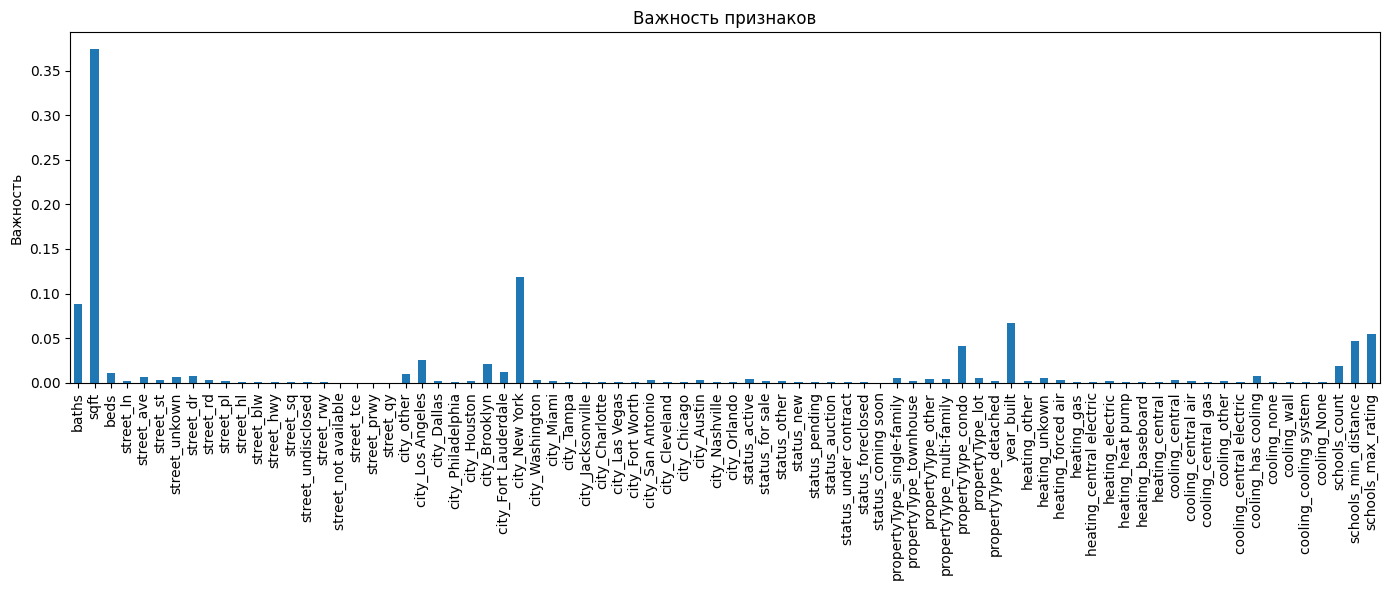

In [260]:
coef = pd.Series(gb_model.feature_importances_, X_train.columns)
fig, ax = plt.subplots(figsize=(14,6))
coef.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Можно отметить, что по коэффициенту значимости признаков лидируют признаки, которые не были закодированы и имеют понятную числовую интерпретацию:
- площадь объекта
- количество ванных
- количество спален
- год постройки
- количество школ в районе
- минимальное расстояние до школы
- максимальный рейтинг школы

### 5. Подготовка модели к продакшену.

In [261]:
# создаем пайплайн, которые включает все преобразования с данными
pipeline = Pipeline([
    ('Scaling', preprocessing.MinMaxScaler()),
    ('gb_model', ensemble.GradientBoostingRegressor())
])
pipeline.fit(X_train_sc, y_train)

Pipeline(steps=[('Scaling', MinMaxScaler()),
                ('gb_model', GradientBoostingRegressor())])

In [263]:
# сохраним сериализованный объект в файл
with open('./app/models/model.pkl', 'wb') as output:
    pickle.dump(pipeline, output)